<a href="https://colab.research.google.com/github/Yash-11/are/blob/main/are.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Use 'ctrl+]' to collapse all** 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# ARGPARSE

In [ ]:
import argparse
import torch  
parser = argparse.ArgumentParser('ASE demo')
parser.add_argument('--operation_mode', type=str, choices=['offline', 'online'], default='offline')  
parser.add_argument('--data_type', type=str, choices=['periodic', 'transient'], default='periodic')
parser.add_argument('--RNN', type=str, choices=['lstm', 'rnn'], default='lstm')
parser.add_argument('--gpu', type=int, default=0)
parser.add_argument('--adjoint', action='store_true')
parser.add_argument('--noise', default=False)
parser.add_argument('--SNR', type=int, default=10) 
args = parser.parse_args("")

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

In [ ]:
import time
import numpy as np
import os
import os.path as osp

folder1 = '../content/drive/My Drive/Data/FlowPastCylinderData'
# folder = 'My Drive/Data/FlowPastCylinderData'
a = 'G:'
path1 = folder1#osp.join(a + os.sep, folder)


start_time = time.time()
if args.data_type == 'transient':
  print('loading transient flow past cylinder data...')
  td180 = np.load(osp.join(path1, 'data180.npy'))
  td190 = np.load(osp.join(path1, 'data190.npy'))
  td200 = np.load(osp.join(path1, 'data200.npy'))
  td185 = np.load(osp.join(path1, 'data185.npy'))
  td195 = np.load(osp.join(path1, 'data195.npy'))
  print('data loaded')

elif args.data_type == 'periodic':
  td = np.load(osp.join(path1, 'data190+.npy'))
  print('data loaded')

else:
  print('data_type is not recognised')

print("--- %s seconds --" % (time.time() - start_time))  

data loaded
--- 0.08987998962402344 seconds --


In [ ]:
import torch
if args.operation_mode == 'offline':
  if args.data_type == 'periodic':
      if args.RNN == 'rnn':
        dir1 = 'Pr'
        dir2 = 'Pr/PrOffline'
        dir3 = 'Pr/PrOffline/rnn'
      elif args.RNN == 'lstm':
        dir1 = 'Pr'
        dir2 = 'Pr/PrOffline'
        dir3 = 'Pr/PrOffline/lstm'
  elif args.data_type == 'transient':
      if args.RNN == 'rnn':
        dir1 = 'Tr'
        dir2 = 'Tr/TrOffline'
        dir3 = 'Tr/TrOffline/rnn'
      elif args.RNN == 'lstm':
        dir1 = 'Tr'
        dir2 = 'Tr/TrOffline'
        dir3 = 'Tr/TrOffline/lstm'


elif args.operation_mode == 'online':
  if args.data_type == 'periodic':
      if args.RNN == 'rnn':
          dir1 = 'Pr'
          dir2 = 'Pr/PrOnline'
          dir3 = 'Pr/PrOnline/rnn'
      elif args.RNN == 'lstm':
          dir1 = 'Pr'
          dir2 = 'Pr/PrOnline'
          dir3 = 'Pr/PrOnline/lstm'

  elif args.data_type == 'transient':
      if args.RNN == 'rnn':
          dir1 = 'Tr'
          dir2 = 'Tr/TrOnline'
          dir3 = 'Tr/TrOnline/rnn'
      elif args.RNN == 'lstm':
          dir1 = 'Tr'
          dir2 = 'Tr/TrOnline'
          dir3 = 'Tr/TrOnline/lstm'

# folder = '/My Drive/Colab Notebooks/Weights'
folder = '../content/drive/My Drive/Colab Notebooks/Weights'
folder2 = osp.join(folder, dir1)
folder3 = osp.join(folder, dir2)
folder4 = osp.join(folder, dir3)
folder_save_results = '../content/drive/My Drive/Colab Notebooks/contours'
a = 'G:'
path2 = folder2#osp.join(a + os.sep, folder)
path3 = folder4
# path4 = folder4

In [ ]:
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal

def awgn(s,SNRdB,L=1):
    """
    AWGN channel
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power 
    spectral density N0 of noise added
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB) for the received signal
        L : oversampling factor (applicable for waveform simulation) default L = 1.
    Returns:
        r : received signal vector (r=s+n)
"""
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal
    return r

# td_n2 = np.zeros((300,42168))
# # td_n2 = awgn(td,10)
# for i in range(len(td)):
#   td_n2[i,:] = awgn(td[i],1)

#**NETWORKS**

In [ ]:
import pandas as pd
import numpy as np

import os
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
import matplotlib.pyplot as pt

## Autoencoder Net

In [ ]:
if args.data_type == 'transient':
  class autoencoder(nn.Module):
      def __init__(self,bottle_neck, **kwargs):
          super(autoencoder, self).__init__()
          k = 252*502 
          self.k = kwargs.get('drop',None)
          # print('in autoencoder',kwargs.get('drop',None))

          if kwargs.get('drop',None):
            print('autoencoder oprating with drop layer')
            self.encoder = nn.Sequential(
                # nn.Dropout(p =0.5),
                nn.Linear(k, 2000),
                nn.BatchNorm1d(num_features = 2000),
                nn.ReLU(True),
                # nn.Dropout(p =0.5),
                nn.Linear(2000, 300),
                nn.BatchNorm1d(num_features =300), #before relu and after linear 
                nn.ReLU(True),
                nn.Dropout(p =0.35),
                nn.Linear(300, bottle_neck)) #nn.ReLU(True), nn.Linear(12, 3))
            self.decoder = nn.Sequential(
                nn.Linear(bottle_neck, 300),
                # nn.BatchNorm1d(num_features=256),
                nn.ReLU(True),
                # nn.Dropout(p =0.5),
                nn.Linear(300, 2000),
                # nn.BatchNorm1d(num_features =1024),           
                nn.ReLU(True),
                nn.Linear(2000, k)) #n.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh())

          else:
            print('autoencoder oprating without drop layer')
            self.encoder = nn.Sequential(
                nn.Linear(k, 2000),
                nn.ReLU(True),
                nn.Linear(2000, 300), 
                nn.ReLU(True),
                nn.Linear(300, bottle_neck)) #nn.ReLU(True), nn.Linear(12, 3))
            self.decoder = nn.Sequential(
                nn.Linear(bottle_neck, 300),
                nn.ReLU(True),
                nn.Linear(300, 2000),
                nn.ReLU(True),
                nn.Linear(2000, k)) #n.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh())

      def forward(self, x):
        try :
          w = self.decoder(x)
          return w
        except :
          y = self.encoder(x)
          z = self.decoder(y)
          return z,y

elif args.data_type == 'periodic':
 class autoencoder(nn.Module):
    def __init__(self,bottle_neck,**kwargs):
        super(autoencoder, self).__init__()
        k = 168*251 
        self.k = kwargs.get('drop',None)

        if kwargs.get('drop',None):
          print('autoencoder oprating with drop layer')
          self.encoder = nn.Sequential(
              # nn.Dropout(p =0.5),
              nn.Linear(k, 1024),
              nn.BatchNorm1d(num_features = 1024),
              nn.ReLU(True),
              # nn.Dropout(p =0.5),
              nn.Linear(1024, 256),
              nn.BatchNorm1d(num_features =256), #before relu and after linear 
              nn.ReLU(True),
              nn.Dropout(p =0.35),
              nn.Linear(256, bottle_neck)) #nn.ReLU(True), nn.Linear(12, 3))
          self.decoder = nn.Sequential(
              nn.Linear(bottle_neck, 256),
              # nn.BatchNorm1d(num_features=256),
              nn.ReLU(True),
              # nn.Dropout(p =0.5),
              nn.Linear(256, 1024),
              # nn.BatchNorm1d(num_features =1024),           
              nn.ReLU(True),
              nn.Linear(1024, k)) #n.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh())
        else:
          print('without_drop')
          self.encoder = nn.Sequential(
              nn.Linear(k, 1024),
              nn.ReLU(True),
              nn.Linear(1024, 256),
              nn.ReLU(True),
              nn.Linear(256, bottle_neck)) #nn.ReLU(True), nn.Linear(12, 3))
          self.decoder = nn.Sequential(
              nn.Linear(bottle_neck, 256),
              nn.ReLU(True),
              nn.Linear(256, 1024),
              nn.ReLU(True),
              nn.Linear(1024, k)) #n.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
      try :
        w = self.decoder(x)
        return w
      except :
        # print('self.k',self.k)
        # if self.k :
        #   print('1')
        y = self.encoder(x)
        z = self.decoder(y)
        return z,y
        

## PDS and ADS Net

In [ ]:
if args.data_type == 'transient':
  class ADSnetwork(nn.Module): ####### DS network

      def __init__(self, sensor_number,bottle_neck):
          super(ADSnetwork, self).__init__()
          self.layer1 = nn.Linear(in_features=sensor_number, out_features=200, bias=True)
          self.layer2 = nn.Linear(in_features=200, out_features=200, bias=True)
          #self.layer3 = nn.Linear(in_features=500, out_features=100, bias=True)
          self.output = nn.Linear(in_features=200, out_features=bottle_neck, bias=True)
          #self.dropout = nn.Dropout(p=0.2)  # dropout after relu
          #self.bn = nn.BatchNorm1d(num_features=500)  # bn before relu

      def forward(self, x):
          x = F.relu(self.layer1(x))
          x = F.relu(self.layer2(x))
          #x = F.relu(self.layer3(x))
          x = self.output(x)
          return x

  class PDSnetwork(nn.Module):

      def __init__(self, sensor_number, bottle_neck):
          super(PDSnetwork, self).__init__()
          # Final feed-forward layer
          self.l1 = nn.Linear(in_features=sensor_number, out_features=200, bias=True)
          self.l2 = nn.Linear(in_features=200, out_features=200, bias=True)
          #self.output = nn.Linear(in_features=200, out_features=bottle_neck, bias=True)
          self.output = nn.Linear(in_features=200, out_features=bottle_neck, bias=True)
          #self.l4 = nn.Linear(in_features=500, out_features=bottle_neck, bias=True)
          #self.dropout = nn.Dropout(p=0.2)  # dropout after relu
          #self.bn = nn.BatchNorm1d(num_features=100)  # bn before relu

      def forward(self, leading_dna):
          l1_out = F.relu(self.l1(leading_dna))
          l2_out = F.relu(self.l2(l1_out))
          #l3_out = F.relu(self.l3(l2_out))
          output = self.output(l2_out)        
          #l4_out = F.relu(self.l4(l3_out))
          return output

if args.data_type == 'periodic':
  class ADSnetwork(nn.Module): ####### DS network

      def __init__(self, sensor_number,bottle_neck):
          super(ADSnetwork, self).__init__()
          self.layer1 = nn.Linear(in_features=sensor_number, out_features=50, bias=True)
          self.layer2 = nn.Linear(in_features=50, out_features=50, bias=True)
          #self.layer3 = nn.Linear(in_features=500, out_features=100, bias=True)
          self.output = nn.Linear(in_features=50, out_features=bottle_neck, bias=True)
          #self.dropout = nn.Dropout(p=0.2)  # dropout after relu
          #self.bn = nn.BatchNorm1d(num_features=500)  # bn before relu

      def forward(self, x):
          x = F.relu(self.layer1(x))
          x = F.relu(self.layer2(x))
          #x = F.relu(self.layer3(x))
          x = self.output(x)
          return x

  class PDSnetwork(nn.Module):

      def __init__(self, sensor_number, bottle_neck):
          super(PDSnetwork, self).__init__()
          # Final feed-forward layer
          self.l1 = nn.Linear(in_features=sensor_number, out_features=50, bias=True)
          self.l2 = nn.Linear(in_features=50, out_features=50, bias=True)
          #self.output = nn.Linear(in_features=200, out_features=bottle_neck, bias=True)
          self.output = nn.Linear(in_features=50, out_features=bottle_neck, bias=True)
          #self.l4 = nn.Linear(in_features=500, out_features=bottle_neck, bias=True)
          #self.dropout = nn.Dropout(p=0.2)  # dropout after relu
          #self.bn = nn.BatchNorm1d(num_features=100)  # bn before relu

      def forward(self, leading_dna):
          l1_out = F.relu(self.l1(leading_dna))
          l2_out = F.relu(self.l2(l1_out))
          #l3_out = F.relu(self.l3(l2_out))
          output = self.output(l2_out)        
          #l4_out = F.relu(self.l4(l3_out))
          return output

## RNN Net

In [ ]:
if args.data_type == 'transient':   
  class RNNv3network(nn.Module):

      def __init__(self, hidden_size,sensor_number, bottle_neck, layers, seq_len,**kwargs):
          super(RNNv3network, self).__init__()
          self.hidden_size = hidden_size
          # self.AREdrop = kwargs.get('AREdrop',None)
          print('args.data_type == transient', '\n', 'using rnn cell')

          if args.operation_mode == 'online':      
            self.rl = nn.LSTM(input_size=sensor_number , hidden_size=self.hidden_size, num_layers=layers)#, nonlinearity = 'relu')#)
            self.l1 = nn.Linear(in_features=hidden_size, out_features=200, bias=True)

          elif args.operation_mode == 'offline':
            self.rl = nn.LSTM(input_size=sensor_number , hidden_size=self.hidden_size, num_layers=layers)#, nonlinearity = 'relu')#)
            self.rlr = nn.LSTM(input_size=sensor_number, hidden_size=self.hidden_size, num_layers=layers)#, nonlinearity = 'relu')#)
            self.l1 = nn.Linear(in_features=hidden_size*2, out_features=200, bias=True)

          
          self.l2 = nn.Linear(in_features=200, out_features=200, bias=True)
          self.l3 = nn.Linear(in_features=200, out_features=bottle_neck, bias=True)
          
          # self.bn_25 = nn.BatchNorm1d(num_features=25)
          #self.reset_hidden_states()


      def reset_hidden_states(self, for_batch=None):
          if for_batch is not None:
              batch_size = for_batch.shape[1]

          # Initialize recurrent hidden states
          if args.operation_mode == 'online':    
            self.rl_h = self.init_hidden(batch_size=batch_size)
            self.rl_c = self.init_hidden(batch_size=batch_size)

          if args.operation_mode == 'offline':
            self.rl_h = self.init_hidden(batch_size=batch_size)
            self.rlr_h = self.init_hidden(batch_size=batch_size)
            self.rl_c = self.init_hidden(batch_size=batch_size)
            self.rlr_c = self.init_hidden(batch_size=batch_size)

          if for_batch is not None:
              device = for_batch.device
              if args.operation_mode == 'online':    
                self.rl_h = self.rl_h.to(device)
                self.rl_c = self.rl_c.to(device)
                
              if args.operation_mode == 'offline':
                self.rl_h = self.rl_h.to(device)
                self.rlr_h = self.rlr_h.to(device)
                self.rl_c = self.rl_c.to(device)
                self.rlr_c = self.rlr_c.to(device)


      def init_hidden(self, batch_size):
          layers =1
          return Variable(torch.zeros(layers, batch_size, self.hidden_size))


      def forward(self, leading_dna):
          self.reset_hidden_states(for_batch=leading_dna)
          
          batch = len(leading_dna[0,:,0])
          #print(batch)
          sensor_number = len(leading_dna[0,0,:])
          #print(sensor_number)
          seq_len = len(leading_dna[:,0,0])
          #print(seq_len)
          seq_impct = int((seq_len-1)/2)

          if args.operation_mode == 'online':    
            split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data1 = leading_dna[0:seq_impct+1,:,:] 

            rl_out, self.rl_h= self.rl(split_data1, (self.rl_h, self.rl_c))
            r_out = rl_out[seq_impct]  


          if args.operation_mode == 'offline':
            split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data2 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data1 = leading_dna[0:seq_impct+1,:,:] #(seq_impct+1,batch,sensor_number)
            split_data2 = leading_dna[seq_impct:seq_len,:,:]

            rl_out, self.rl_h= self.rl(split_data1, (self.rl_h, self.rl_c))
            rlr_out, self.rlr_h = self.rlr(self.flip_input(split_data2), (self.rlr_h, self.rlr_c))
            r_out = torch.cat((rl_out[seq_impct], rlr_out[seq_impct]), 1)
            
          l1_out = F.relu(self.l1(r_out))
          l2_out = F.relu(self.l2(l1_out))
          l3_out = self.l3(l2_out)
          return l3_out


      def flip_input(self, input):
          device = input.device
          flipped_array = np.flip(input.data.cpu().numpy(), 0).copy()
          return Variable(torch.from_numpy(flipped_array).to(device))

if args.data_type == 'periodic':     
  class RNNv3network(nn.Module):

      def __init__(self, hidden_size,sensor_number, bottle_neck, layers, seq_len,**kwargs):
          super(RNNv3network, self).__init__()
          self.hidden_size = hidden_size
          # self.AREdrop = kwargs.get('AREdrop',None)
          print('args.data_type == periodic', '\n', 'using rnn cell')

          if args.operation_mode == 'online':      
            self.rl = nn.LSTM(input_size=sensor_number , hidden_size=self.hidden_size, num_layers=layers)#, nonlinearity = 'relu')#)
            self.l1 = nn.Linear(in_features=hidden_size, out_features=50, bias=True)


          if args.operation_mode == 'offline':
            self.rl = nn.LSTM(input_size=sensor_number , hidden_size=self.hidden_size, num_layers=layers)#, nonlinearity = 'relu')#)
            self.rlr = nn.LSTM(input_size=sensor_number, hidden_size=self.hidden_size, num_layers=layers)#, nonlinearity = 'relu')#)
            self.l1 = nn.Linear(in_features=hidden_size*2, out_features=50, bias=True)

          
          self.l2 = nn.Linear(in_features=50, out_features=50, bias=True)
          self.l3 = nn.Linear(in_features=50, out_features=bottle_neck, bias=True)
          
          # self.bn_25 = nn.BatchNorm1d(num_features=25)
          #self.reset_hidden_states()


      def reset_hidden_states(self, for_batch=None):
          if for_batch is not None:
              batch_size = for_batch.shape[1]

          # Initialize recurrent hidden states
          if args.operation_mode == 'online':    
            self.rl_h = self.init_hidden(batch_size=batch_size)
            self.rl_c = self.init_hidden(batch_size=batch_size)

          if args.operation_mode == 'offline':
            self.rl_h = self.init_hidden(batch_size=batch_size)
            self.rlr_h = self.init_hidden(batch_size=batch_size)
            self.rl_c = self.init_hidden(batch_size=batch_size)
            self.rlr_c = self.init_hidden(batch_size=batch_size)

          if for_batch is not None:
              device = for_batch.device
              if args.operation_mode == 'online':    
                self.rl_h = self.rl_h.to(device)
                self.rl_c = self.rl_c.to(device)
                
              if args.operation_mode == 'offline':
                self.rl_h = self.rl_h.to(device)
                self.rlr_h = self.rlr_h.to(device)
                self.rl_c = self.rl_c.to(device)
                self.rlr_c = self.rlr_c.to(device)


      def init_hidden(self, batch_size):
          layers =1
          return Variable(torch.zeros(layers, batch_size, self.hidden_size))


      def forward(self, leading_dna):
          self.reset_hidden_states(for_batch=leading_dna)
          
          batch = len(leading_dna[0,:,0])
          #print(batch)
          sensor_number = len(leading_dna[0,0,:])
          #print(sensor_number)
          seq_len = len(leading_dna[:,0,0])
          #print(seq_len)
          seq_impct = int((seq_len-1)/2)

          if args.operation_mode == 'online':    
            split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data1 = leading_dna[0:seq_impct+1,:,:] 

            rl_out, self.rl_h= self.rl(split_data1, (self.rl_h, self.rl_c))
            r_out = rl_out[seq_impct]  


          if args.operation_mode == 'offline':
            split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data2 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data1 = leading_dna[0:seq_impct+1,:,:] #(seq_impct+1,batch,sensor_number)
            split_data2 = leading_dna[seq_impct:seq_len,:,:]

            rl_out, self.rl_h= self.rl(split_data1, (self.rl_h, self.rl_c))
            rlr_out, self.rlr_h = self.rlr(self.flip_input(split_data2), (self.rlr_h, self.rlr_c))
            r_out = torch.cat((rl_out[seq_impct], rlr_out[seq_impct]), 1)
            
          l1_out = F.relu(self.l1(r_out))
          l2_out = F.relu(self.l2(l1_out))
          l3_out = self.l3(l2_out)
          return l3_out


      def flip_input(self, input):
          device = input.device
          flipped_array = np.flip(input.data.cpu().numpy(), 0).copy()
          return Variable(torch.from_numpy(flipped_array).to(device))
                

## LSTM Net 

In [ ]:
if args.data_type == 'transient':  
  class LSTMv3network(nn.Module):

      def __init__(self, hidden_size,sensor_number, bottle_neck, layers, seq_len):
          super(LSTMv3network, self).__init__()
          self.hidden_size = hidden_size
          print('args.data_type == transient', '\n', 'using lstm cell')

          if args.operation_mode == 'online':      
            self.rl = nn.LSTM(input_size=sensor_number , hidden_size=self.hidden_size, num_layers=layers)#, dropout=0.5)#, nonlinearity = 'relu')#)
            self.l1 = nn.Linear(in_features=hidden_size, out_features=200, bias=True)

            self.l2 = nn.Linear(in_features=200, out_features=200, bias=True)
            self.l3 = nn.Linear(in_features=200, out_features=bottle_neck, bias=True)

          if args.operation_mode == 'offline':
            self.rl = nn.LSTM(input_size=sensor_number , hidden_size=self.hidden_size, num_layers=layers)#, dropout=0.5)#, nonlinearity = 'relu')#)
            self.rlr = nn.LSTM(input_size=sensor_number, hidden_size=self.hidden_size, num_layers=layers)#, dropout=0.5)#, nonlinearity = 'relu')#)
            self.l1 = nn.Linear(in_features=hidden_size*2, out_features=200, bias=True)
            
            self.l2 = nn.Linear(in_features=200, out_features=200, bias=True)
            self.l3 = nn.Linear(in_features=200, out_features=bottle_neck, bias=True)


      def reset_hidden_states(self, for_batch=None):
          if for_batch is not None:
              batch_size = for_batch.shape[1]

          # Initialize recurrent hidden states
          if args.operation_mode == 'online':      
            self.rl_h = self.init_hidden(batch_size=batch_size)
            self.rl_c = self.init_hidden(batch_size=batch_size)

          if args.operation_mode == 'offline':
            self.rl_h = self.init_hidden(batch_size=batch_size)
            self.rlr_h = self.init_hidden(batch_size=batch_size)
            self.rl_c = self.init_hidden(batch_size=batch_size)
            self.rlr_c = self.init_hidden(batch_size=batch_size)

          if for_batch is not None:
              device = for_batch.device

              if args.operation_mode == 'online':      
                self.rl_h = self.rl_h.to(device)
                self.rl_c = self.rl_c.to(device)

              if args.operation_mode == 'offline':
                  self.rl_h = self.rl_h.to(device)
                  self.rlr_h = self.rlr_h.to(device)
                  self.rl_c = self.rl_c.to(device)
                  self.rlr_c = self.rlr_c.to(device)


      def init_hidden(self, batch_size):
          layers =1
          return Variable(torch.zeros(layers, batch_size, self.hidden_size))

      def forward(self, leading_dna):
          self.reset_hidden_states(for_batch=leading_dna)
          
          batch = len(leading_dna[0,:,0])
          sensor_number = len(leading_dna[0,0,:])
          seq_len = len(leading_dna[:,0,0])
          seq_impct = int((seq_len-1)/2)

          if args.operation_mode == 'online':      
            split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data1 = leading_dna[0:seq_impct+1,:,:] 

            rl_out, self.rl_h= self.rl(split_data1, (self.rl_h, self.rl_c))
            r_out = rl_out[seq_impct]

          if args.operation_mode == 'offline':
            split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data2 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data1 = leading_dna[0:seq_impct+1,:,:] #(seq_impct+1,batch,sensor_number)
            split_data2 = leading_dna[seq_impct:seq_len,:,:]

            rl_out, self.rl_h= self.rl(split_data1, (self.rl_h, self.rl_c))
            rlr_out, self.rlr_h = self.rlr(self.flip_input(split_data2), (self.rlr_h, self.rlr_c))
            r_out = torch.cat((rl_out[seq_impct], rlr_out[seq_impct]), 1)

          l1_out = F.relu(self.l1(r_out))
          l2_out = F.relu(self.l2(l1_out))
          l3_out = self.l3(l2_out)
          return l3_out


      def flip_input(self, input):
          device = input.device
          flipped_array = np.flip(input.data.cpu().numpy(), 0).copy()
          return Variable(torch.from_numpy(flipped_array).to(device))

elif args.data_type == 'periodic': 
  class LSTMv3network(nn.Module):

      def __init__(self, hidden_size,sensor_number, bottle_neck, layers, seq_len):
          super(LSTMv3network, self).__init__()
          self.hidden_size = hidden_size
          print('args.data_type == periodic', '\n', 'using lstm cell')

          if args.operation_mode == 'online':      
            self.rl = nn.LSTM(input_size=sensor_number , hidden_size=self.hidden_size, num_layers=layers)#, dropout=0.5)#, nonlinearity = 'relu')#)
            self.l1 = nn.Linear(in_features=hidden_size, out_features=50, bias=True)            
            
            self.l2 = nn.Linear(in_features=50, out_features=50, bias=True)
            self.l3 = nn.Linear(in_features=50, out_features=bottle_neck, bias=True)

          if args.operation_mode == 'offline':
            self.rl = nn.LSTM(input_size=sensor_number , hidden_size=self.hidden_size, num_layers=layers)#, dropout=0.5)#, nonlinearity = 'relu')#)
            self.rlr = nn.LSTM(input_size=sensor_number, hidden_size=self.hidden_size, num_layers=layers)#, dropout=0.5)#, nonlinearity = 'relu')#)
            self.l1 = nn.Linear(in_features=hidden_size*2, out_features=50, bias=True)

            self.l2 = nn.Linear(in_features=50, out_features=50, bias=True)
            self.l3 = nn.Linear(in_features=50, out_features=bottle_neck, bias=True)


      def reset_hidden_states(self, for_batch=None):
          if for_batch is not None:
              batch_size = for_batch.shape[1]

          # Initialize recurrent hidden states
          if args.operation_mode == 'online':      
            self.rl_h = self.init_hidden(batch_size=batch_size)
            self.rl_c = self.init_hidden(batch_size=batch_size)

          if args.operation_mode == 'offline':
            self.rl_h = self.init_hidden(batch_size=batch_size)
            self.rlr_h = self.init_hidden(batch_size=batch_size)
            self.rl_c = self.init_hidden(batch_size=batch_size)
            self.rlr_c = self.init_hidden(batch_size=batch_size)

          if for_batch is not None:
              device = for_batch.device

              if args.operation_mode == 'online':      
                self.rl_h = self.rl_h.to(device)
                self.rl_c = self.rl_c.to(device)

              if args.operation_mode == 'offline':
                  self.rl_h = self.rl_h.to(device)
                  self.rlr_h = self.rlr_h.to(device)
                  self.rl_c = self.rl_c.to(device)
                  self.rlr_c = self.rlr_c.to(device)


      def init_hidden(self, batch_size):
          layers =1
          return Variable(torch.zeros(layers, batch_size, self.hidden_size))

      def forward(self, leading_dna):
          self.reset_hidden_states(for_batch=leading_dna)
          
          batch = len(leading_dna[0,:,0])
          sensor_number = len(leading_dna[0,0,:])
          seq_len = len(leading_dna[:,0,0])
          seq_impct = int((seq_len-1)/2)

          if args.operation_mode == 'online':      
            split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data1 = leading_dna[0:seq_impct+1,:,:] 

            rl_out, self.rl_h= self.rl(split_data1, (self.rl_h, self.rl_c))
            r_out = rl_out[seq_impct]

          if args.operation_mode == 'offline':
            split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data2 = torch.zeros(seq_impct+1,batch,sensor_number)
            split_data1 = leading_dna[0:seq_impct+1,:,:] #(seq_impct+1,batch,sensor_number)
            split_data2 = leading_dna[seq_impct:seq_len,:,:]

            rl_out, self.rl_h= self.rl(split_data1, (self.rl_h, self.rl_c))
            rlr_out, self.rlr_h = self.rlr(self.flip_input(split_data2), (self.rlr_h, self.rlr_c))
            r_out = torch.cat((rl_out[seq_impct], rlr_out[seq_impct]), 1)

          l1_out = F.relu(self.l1(r_out))
          l2_out = F.relu(self.l2(l1_out))
          l3_out = self.l3(l2_out)
          return l3_out


      def flip_input(self, input):
          device = input.device
          flipped_array = np.flip(input.data.cpu().numpy(), 0).copy()
          return Variable(torch.from_numpy(flipped_array).to(device))
          


## Other RNN Net variants

In [ ]:

class RNNvnetwork(nn.Module):

    DROPOUT = 0.5

    def __init__(self, hidden_size,sensor_number, bottle_neck, layers, seq_len):
        super(RNNv3network, self).__init__()
        self.hidden_size = hidden_size

        # Recurrent layers
        self.rl = nn.RNN(input_size=sensor_number , hidden_size=self.hidden_size, num_layers=layers, nonlinearity = 'relu')#, dropout=self.DROPOUT)
        self.rlr = nn.RNN(input_size=sensor_number, hidden_size=self.hidden_size, num_layers=layers, nonlinearity = 'relu')#, dropout=self.DROPOUT)

        # Final feed-forward layer
        self.l1 = nn.Linear(in_features=hidden_size*2, out_features=500, bias=True)
        self.l2 = nn.Linear(in_features=500, out_features=500, bias=True)
        self.l3 = nn.Linear(in_features=500, out_features=bottle_neck, bias=True)
        #self.l3 = nn.Linear(in_features=200, out_features=25, bias=True)
        #self.reset_hidden_states()


    def reset_hidden_states(self, for_batch=None):
        if for_batch is not None:
            batch_size = for_batch.shape[1]

        # Initialize recurrent hidden states
        self.rl_h = self.init_hidden(batch_size=batch_size)
        self.rlr_h = self.init_hidden(batch_size=batch_size)

        if for_batch is not None:
            device = for_batch.device
            self.rl_h = self.rl_h.to(device)
            self.rlr_h = self.rlr_h.to(device)


    def init_hidden(self, batch_size):
        layers = 1
        return Variable(torch.zeros(layers, batch_size, self.hidden_size))


    def forward(self, leading_dna):
        self.reset_hidden_states(for_batch=leading_dna)
        
        batch = len(leading_dna[0,:,0])
        #print(batch)
        sensor_number = len(leading_dna[0,0,:])
        #print(sensor_number)
        seq_len = len(leading_dna[:,0,0])
        #print(seq_len)
        seq_impct = int((seq_len-1)/2)

        split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
        split_data2 = torch.zeros(seq_impct+1,batch,sensor_number)
        split_data1 = leading_dna[0:seq_impct+1,:,:] #(seq_impct+1,batch,sensor_number)
        split_data2 = leading_dna[seq_impct:seq_len,:,:]

        rl_out, self.rl_h = self.rl(split_data1, self.rl_h)
        #print('forward_in')
        #print(split_data1)
        #print('first_layer_out')
        #print(rl_out)
        rlr_out, self.rlr_h = self.rlr(self.flip_input(split_data2), self.rlr_h)
        #print('fliped_input')
        #print(self.flip_input(split_data2))
        #print('fliped_output')
        #print(rlr_out)
        r_out = torch.cat((rl_out[seq_impct], rlr_out[seq_impct]), 1)
        #print('concated_middel_layer output')
        #print(r_out)
        l1_out = F.relu(self.l1(r_out))
        l2_out = F.relu(self.l2(l1_out))
        l3_out = self.l3(l2_out)
        return l3_out


    def flip_input(self, input):
        device = input.device
        flipped_array = np.flip(input.data.cpu().numpy(), 0).copy()
        return Variable(torch.from_numpy(flipped_array).to(device))


class RNNnetwork(nn.Module):

    DROPOUT = 0.5

    def __init__(self, hidden_size,sensor_number, bottle_neck, layers):
        super(RNNnetwork, self).__init__()
        self.hidden_size = hidden_size

        # Recurrent layers
        self.rl = nn.RNN(input_size=sensor_number , hidden_size=self.hidden_size, num_layers=layers, nonlinearity = 'relu', dropout=self.DROPOUT)
        self.rlr = nn.RNN(input_size=sensor_number, hidden_size=self.hidden_size, num_layers=layers, nonlinearity = 'relu', dropout=self.DROPOUT)

        # Final feed-forward layer
        self.l1 = nn.Linear(in_features=hidden_size*2, out_features=200, bias=True)
        self.l2 = nn.Linear(in_features=200, out_features=bottle_neck, bias=True)
        #self.l3 = nn.Linear(in_features=200, out_features=25, bias=True)
        #self.reset_hidden_states()


    def reset_hidden_states(self, for_batch=None):
        if for_batch is not None:
            batch_size = for_batch.shape[1]

        # Initialize recurrent hidden states
        self.rl_h = self.init_hidden(batch_size=batch_size)
        self.rlr_h = self.init_hidden(batch_size=batch_size)

        if for_batch is not None:
            device = for_batch.device
            self.rl_h = self.rl_h.to(device)
            self.rlr_h = self.rlr_h.to(device)


    def init_hidden(self, batch_size):
        return Variable(torch.zeros(layers, batch_size, self.hidden_size))


    def forward(self, leading_dna):
        self.reset_hidden_states(for_batch=leading_dna)

        rl_out, self.rl_h = self.rl(leading_dna, self.rl_h)
        #print('forward_in')
        #print(leading_dna)
        #print('first_layer_out')
        #print(rl_out)
        rlr_out, self.rlr_h = self.rlr(self.flip_input(leading_dna), self.rlr_h)
        #print('fliped_input')
        #print(self.flip_input(leading_dna))
        #print('fliped_output')
        #print(rlr_out)
        r_out = torch.cat((rl_out[1], rlr_out[1]), 1)
        #print('concated_middel_layer output')
        #print(r_out)
        l1_out = F.relu(self.l1(r_out))
        l2_out = self.l2(l1_out)
        #l3_out = self.l3(l2_out)
        return l2_out


    def flip_input(self, input):
        device = input.device
        flipped_array = np.flip(input.data.cpu().numpy(), 0).copy()
        return Variable(torch.from_numpy(flipped_array).to(device))

class RNNv2network(nn.Module):
    DROPOUT = 0.5

    def __init__(self, hidden_size,sensor_number, bottle_neck, layers, seq_len):
        super(RNNv2network, self).__init__()
        self.hidden_size = hidden_size
        
        # Recurrent layers
        self.rl = nn.RNN(input_size=sensor_number, bidirectional =True, hidden_size=self.hidden_size, num_layers= layers, nonlinearity = 'relu', dropout=self.DROPOUT)
        
        # Final feed-forward layer
        self.l1 = nn.Linear(in_features=hidden_size*2*seq_len, out_features=200, bias=True)
        self.l2 = nn.Linear(in_features=200, out_features=bottle_neck, bias=True)
        #self.l3 = nn.Linear(in_features=200, out_features=25, bias=True)
        #self.reset_hidden_states()


    def reset_hidden_states(self, for_batch=None):
        if for_batch is not None:
            batch_size = for_batch.shape[1]

        # Initialize recurrent hidden states
        self.rl_h = self.init_hidden(batch_size=batch_size)
        
        if for_batch is not None:
            device = for_batch.device
            self.rl_h = self.rl_h.to(device)

    def init_hidden(self, batch_size):
        return Variable(torch.zeros(layers*2, batch_size, self.hidden_size))


    def forward(self, leading_dna):
        self.reset_hidden_states(for_batch=leading_dna)

        rl_out, self.rl_h = self.rl(leading_dna, self.rl_h)
        #print(rl_out.shape)
        if seq_len == 3:
          r_out = torch.cat((rl_out[0], rl_out[1], rl_out[2]), 1)
        elif seq_len == 5:
          r_out = torch.cat((rl_out[0], rl_out[1], rl_out[2], rl_out[3], rl_out[4]), 1)
        elif seq_len == 7:
          r_out = torch.cat((rl_out[0], rl_out[1], rl_out[2], rl_out[3], rl_out[4], rl_out[5], rl_out[6]), 1)
        #print('concated_middel_layer output')
        #print(r_out)
        l1_out = F.relu(self.l1(r_out))
        l2_out = self.l2(l1_out)
        #l3_out = self.l3(l2_out)
        return l2_out


# Utils

In [ ]:
pip install cmocean

     |████████████████████████████████| 225kB 5.6MB/s 


In [ ]:
if args.data_type == 'transient':
  def contour_select(i, t_out_tensor, t, statsAE, x_cord, s, seq_len, seq_impct, **kwargs):
    if s in kwargs.get('plot_s_list', None):
      if seq_len in kwargs.get('plot_seq_len_list', None):
        if i in kwargs.get('plot_contour_idx', None)-seq_impct:
          save_path = osp.join(folder_save_results, dir3)
          plot1image(t_out_tensor, 
                     t, 
                     statsAE, 
                     x_cord, 
                     name = 'im_{}_s{:d}_sq{:d}_i{:d}_SNR{:d}_Tr.eps'.format(args.RNN, s,seq_len,i+seq_impct, kwargs.get('SNR', None)), 
                     plot1=1, save=0,
                     plot2=0, save2=0, 
                     name2 = 'im_{}_true_s{:d}_sq{:d}_i{:d}_SNR{:d}_Tr.eps'.format(args.RNN, s,seq_len,i+seq_impct, kwargs.get('SNR', None)), 
                     save_path=save_path)


  def plot1image(output,img,stats,sensor_locations, **kwargs):
    name1 = kwargs.get('name', None)
    save = kwargs.get('save', None)
    save2  = kwargs.get('save2', None)
    name2 = kwargs.get('name2', None) #'im_RNNv3_true_s{:d}_sq{:d}_{:d}_D3'.format(sensor_number,seq_len,i) 
    x_cord = sensor_locations
    t_pred = output.cpu().data.numpy()
    t_true = img.cpu().data.numpy()
    t_pred = t_pred * stats[1, :] + stats[0, :]
    #print(t_pred.shape)
    #print(t_true.shape)
    t_true = t_true * stats[1, :] + stats[0, :]
    m,n = mn()
    nx=n
    ny=m
    ns = nx*ny
    x2 = np.arange(0, ny, 1)
    y2 = np.arange(0, nx, 1)
    mX, mY = np.meshgrid(x2, y2)

    if kwargs.get('plot1', None):
    # for i in range(250,325):
    #   try:
    #     t_predd = t_pred[i,:].reshape((ny, nx))
    #     print('reconstruction',i)
    #     minmax = np.max(np.abs(t_predd)) * 0.65
    #     pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    #     im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    #     pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
    #     pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
    #     pt.show()
    #     #pt.pcolormesh(t_pred[i, :ns].reshape((ny, nx),order ='F'), cmap=pt.cm.jet, vmin=-0.0003, vmax=0.0003)
    #     #pt.pcolormesh(t_pred[i,:].reshape((384, 199)))
    #   except :
        t_predd = t_pred[0,:].reshape((ny, nx))
        print('reconstruction',i)
        minmax = np.max(np.abs(t_predd)) * 0.65
        pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
        im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
        pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
        pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
        if save ==1:
          pt.savefig(osp.join(kwargs.get('save_path', None), '{}'.format(name1)),format='eps')
          print('SAVED -',osp.join(kwargs.get('save_path', None), '{}'.format(name1)))
        pt.show()
        # break
      
    if kwargs.get('plot2', None):
    # for i in range(250,325):
    #   try:
    #     t_truee = t_true[i,:].reshape((ny, nx))
    #     minmax = np.max(np.abs(t_truee)) * 0.65
    #     pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    #     im = pt.imshow(t_truee.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    #     pt.contourf(mX, mY, t_truee.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
    #     #pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
    #     pt.show()
    #   except:
        t_truee = t_true[0,:].reshape((ny, nx))
        minmax = np.max(np.abs(t_truee)) * 0.65
        pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
        im = pt.imshow(t_truee.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
        pt.contourf(mX, mY, t_truee.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
        #pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
        if save2 ==1:
          mm=0
          pt.savefig(osp.join(kwargs.get('save_path', None), '{}'.format(name2)),format='eps')
          print('SAVED -',osp.join(kwargs.get('save_path', None), '{}'.format(name1)))
          # pt.savefig('../content/drive/My Drive/Colab Notebooks/results4//tr{}'.format(name2),format='eps')
          # print('SAVED -','../content/drive/My Drive/Colab Notebooks/results4/tr/{}'.format(name2) )
        pt.show()
        # break

if args.data_type == 'periodic':
  def contour_select(i, t_out_tensor, t, statsAE, x_cord, s, seq_len, seq_impct, **kwargs):
    if s in kwargs.get('plot_s_list', None):
      if seq_len in kwargs.get('plot_seq_len_list', None):
        if i in kwargs.get('plot_contour_idx', None)-seq_impct:
          save_path = osp.join(folder_save_results, dir3)
          plot1image(t_out_tensor, 
                      t, 
                      statsAE, 
                      x_cord, 
                      name = 'im_{}_s{:d}_sq{:d}_i{:d}_SNR{:d}_Pr.eps'.format(args.RNN, s,seq_len,i+seq_impct, kwargs.get('SNR', None)), 
                      plot1=1, save=0,
                      plot2=0, save2=0, 
                      name2 = 'im_{}_true_s{:d}_sq{:d}_i{:d}_SNR{:d}_Pr.eps'.format(args.RNN, s,seq_len,i+seq_impct, kwargs.get('SNR', None)), 
                      save_path=save_path )

  def plot1image(output,img,stats,sensor_locations, **kwargs):
    name1 = kwargs.get('name', None)
    save = kwargs.get('save', None)
    save2  = kwargs.get('save2', None)
    name2 = kwargs.get('name2', None) #'im_RNNv3_true_s{:d}_sq{:d}_{:d}_D3'.format(sensor_number,seq_len,i) 

    x_cord = sensor_locations
    t_pred = output.cpu().data.numpy()
    t_true = img.cpu().data.numpy()
    t_pred = t_pred * stats[1, :] + stats[0, :]
    #print(t_pred.shape)
    #print(t_true.shape)
    t_true = t_true * stats[1, :] + stats[0, :]
    nx=168
    ny=251
    ns = nx*ny
    x2 = np.arange(0, ny, 1)
    y2 = np.arange(0, nx, 1)
    mX, mY = np.meshgrid(x2, y2)

    if kwargs.get('plot1', None):
    # for i in range(250,325):
    #   try:
    #     t_predd = t_pred[i,:].reshape((ny, nx))
    #     print('reconstruction',i)
    #     minmax = np.max(np.abs(t_predd)) * 0.65
    #     pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    #     im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    #     pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
    #     pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
    #     pt.show()
    #     #pt.pcolormesh(t_pred[i, :ns].reshape((ny, nx),order ='F'), cmap=pt.cm.jet, vmin=-0.0003, vmax=0.0003)
    #     #pt.pcolormesh(t_pred[i,:].reshape((384, 199)))
    #   except :
        t_predd = t_pred[0,:].reshape((ny, nx))
        #print('reconstruction',i)
        minmax = np.max(np.abs(t_predd)) * 0.65
        pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
        im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
        pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
        pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
        if save ==1:
          pt.savefig(osp.join(kwargs.get('save_path', None), '{}'.format(name1)),format='eps')
          print('SAVED -',osp.join(kwargs.get('save_path', None), '{}'.format(name1)))
          # pt.savefig('../content/drive/My Drive/Colab Notebooks/results4/pr/{}'.format(im_name),format='eps')
          # print('SAVED -','../content/drive/My Drive/Colab Notebooks/results4/pr/{}'.format(im_name))
        pt.show()
        # break
      
    if kwargs.get('plot2', None):
    # for i in range(250,325):
    #   try:
    #     t_truee = t_true[i,:].reshape((ny, nx))
    #     minmax = np.max(np.abs(t_truee)) * 0.65
    #     pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    #     im = pt.imshow(t_truee.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    #     pt.contourf(mX, mY, t_truee.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
    #     #pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
    #     pt.show()
    #   except:
        t_truee = t_true[0,:].reshape((ny, nx))
        minmax = np.max(np.abs(t_truee)) * 0.65
        pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
        im = pt.imshow(t_truee.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
        pt.contourf(mX, mY, t_truee.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)#vmin=-minmax+3, vmax=minmax-3)
        #pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
        if save2 ==1:
          pt.savefig(osp.join(kwargs.get('save_path', None), '{}'.format(name1)),format='eps')
          print('SAVED -',osp.join(kwargs.get('save_path', None), '{}'.format(name1)))
          # pt.savefig('../content/drive/My Drive/Colab Notebooks/results4/pr{}'.format(name2),format='eps')
          # print('SAVED -','../content/drive/My Drive/Colab Notebooks/results4/pr/{}'.format(name2) )      
        pt.show()
        # break


#**DEF DATASET**

In [ ]:
x2 = np.arange(0, 10, 1)
y2 = np.arange(0, 6, 1)
mX, mY = np.meshgrid(x2, y2)
for i in range(4):
  print('%s',i)

%s 0
%s 1
%s 2
%s 3


In [ ]:
class sensorgcdatasetAE(Dataset):

    def __init__(self, in_file,  stats, transform=None):
        self.sensor_frame = in_file
        self.stats = stats
        self.transform = transform

    def __len__(self):
        return len(self.sensor_frame)

    def __getitem__(self, idx):
        sensor = self.sensor_frame[idx, :]
        sensor = (sensor - self.stats[0, :]) / self.stats[1, :]
        sensor = torch.from_numpy(sensor).float()
        return sensor

class sensorgcdatasetAA(Dataset):
    def __init__(self, in_file, out_file, stats, transform=None):
        self.sensor_frame = in_file
        self.gc_frame = out_file
        self.stats = stats
        self.transform = transform

    def __len__(self):
        return len(self.sensor_frame)

    def __getitem__(self, idx):
        senso = self.sensor_frame[idx, :]
        gcc = self.gc_frame[idx, :]
        #sensor = (sensor - self.stats[0][0, :]) / self.stats[0][1, :]
        gcc = (gcc - self.stats[0, :])/self.stats[1, :]
        senso = torch.from_numpy(senso).float()
        gcc = torch.from_numpy(gcc).float()
        return senso, gcc

class sensorgcdatasetRNN(Dataset):

    def __init__(self, in_file, out_file,  transform=None):
        self.sensor_frame = in_file
        self.gc_frame = out_file
        self.transform = transform

    def __len__(self):
        return len(self.sensor_frame)

    def __getitem__(self, idx):
        sensor = self.sensor_frame[idx, :]
        #print(idx)
        #print(sensor.shape)
        gc = self.gc_frame[idx, :]
        #print(idx)
        #print(gc.shape)
        sensor = torch.from_numpy(sensor).float()
        gc = torch.from_numpy(gc).float()
        return sensor, gc

class sensorgcdatasetDS(Dataset):

    def __init__(self, in_file, out_file, transform=None):
        self.in_frame = in_file
        self.out_frame = out_file
        self.transform = transform

    def __len__(self):
        return len(self.in_frame)

    def __getitem__(self, idx):
        inn = self.in_frame[idx, :]
        out = self.out_frame[idx, :]
        inn = torch.from_numpy(inn).float()
        out = torch.from_numpy(out).float()
        return inn, out

# **DEF TRAIN DATA**

## Autoencoder_train_data

In [ ]:
import random

if args.data_type == 'transient':
  def autoencoder_train_data(**kwargs):
    if kwargs.get('drop',None):
      print('in autoencoder_train_data--noise data', 'SNR =',kwargs.get('SNR',10))
      
      td1_n2 = np.zeros((399,126504))
      td2_n2 = np.zeros((399,126504))
      td3_n2 = np.zeros((399,126504))
      td4_n2 = np.zeros((399,126504))
      td5_n2 = np.zeros((399,126504))
      for i in range(len(td1_n2)):
        td1_n2[i,:] = awgn(td180[i],kwargs.get('SNR',10))
        td2_n2[i,:] = awgn(td190[i],kwargs.get('SNR',10))
        td3_n2[i,:] = awgn(td200[i],kwargs.get('SNR',10))
        td4_n2[i,:] = awgn(td185[i],kwargs.get('SNR',10))
        td5_n2[i,:] = awgn(td195[i],kwargs.get('SNR',10))

      trainAE = np.concatenate((td1_n2, td2_n2, td3_n2), axis=0)
      validAE = td4_n2
      testAE = td5_n2 

    else :
      print('in autoencoder_train_data-- no noise data')
      trainAE = np.concatenate((td180, td190, td200), axis=0)
      #del(td180, td190, td200)
      #trainAE = trainAE.reshape(len(trainAE[:,0]),-1)
      validAE = td185
      testAE = td195

    AE_mean = np.mean(trainAE.reshape(len(trainAE[:,0]),-1), axis = 0)
    AE_std = np.std(trainAE.reshape(len(trainAE[:,0]),-1), axis = 0) 
    stats = np.array([AE_mean, AE_std])
    stats[stats==0] = 0.0000001
    return trainAE, validAE, testAE, stats

  def mn():
    m = 502
    n= 252
    return m,n

  def sensor_cord_data(m,n,sensor_num):
    theata = np.linspace(0, 2*np.pi, 300)
    x_cord = np.round(24 * np.cos(theata)) + 0
    y_cord = np.round(24 * np.sin(theata)) + n/2
    cords = np.vstack((x_cord,y_cord)).T
    x_cord = np.unique(cords, axis=0)
    idx = x_cord[:,0] > 0
    x_cord = x_cord[idx,:]
    np.random.seed(323)
    idx = np.random.choice(range(x_cord.shape[0]), sensor_num, False)
    #print(idx,'idx')
    x_cord = np.int64(x_cord[idx,:])
    return x_cord

if args.data_type == 'periodic':
  def autoencoder_train_data(**kwargs):
    if kwargs.get('drop',None):
      print('in autoencoder_train_data--noise data', 'SNR =',kwargs.get('SNR',10))
      
      td_n2 = np.zeros((300,42168))
      # td_n2 = awgn(td,10)
      for i in range(len(td)):
        td_n2[i,:] = awgn(td[i],kwargs.get('SNR',10))

      trainAE = td_n2[0:180,:]
      len_tr = len(trainAE)
      validAE = td_n2[180:240,:]
      testAE = td_n2[240:300,:]  

      nx=168
      ny=251
      ns = nx*ny
      x2 = np.arange(0, ny, 1)
      y2 = np.arange(0, nx, 1)
      mX, mY = np.meshgrid(x2, y2)

      # t_predd = testAE[39,:].reshape((ny, nx))
      # #print('reconstruction',i)
      # minmax = np.max(np.abs(t_predd)) * 0.65
      # pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
      # im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
      # # pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
      # # pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
      # im_name = 'im_true_39_noise_SNR{:d}.eps'.format(kwargs.get('SNR',10))
      # pt.savefig('../content/drive/My Drive/Colab Notebooks/results4/noise/{}'.format(im_name),format='eps')
      # print('SAVED -','../content/drive/My Drive/Colab Notebooks/results4/noise/{}'.format(im_name))
      # pt.show()


    else :
      print('in autoencoder_train_data-- no noise data')
      len_tr =180
      trainAE = td[0:len_tr,:]
      validAE = td[180:240,:]
      testAE = td[240:300,:]

    AE_mean = np.mean(td[0:len_tr,:], axis = 0)
    AE_std = np.std(td[0:len_tr,:], axis = 0) 
    stats = np.array([AE_mean, AE_std])
    stats[stats==0] = 0.0000001
    #pt.figure()
    #pt.imshow(trainAE.reshape(90, 384, 199)[2,:,:])
    #pt.show
    return trainAE, validAE, testAE, stats

  def mn():
    m = 251
    n= 168
    return m,n

  def sensor_cord_data(sensor_num):
    m,n = mn()
    theata = np.linspace(0, 2*np.pi, 300)
    x_cord = np.round(25 * np.cos(theata)) + 0
    y_cord = np.round(25 * np.sin(theata)) + 169/2
    cords = np.vstack((x_cord,y_cord)).T
    x_cord = np.unique(cords, axis=0)
    idx = x_cord[:,0] > 0
    x_cord = x_cord[idx,:]
    np.random.seed(3265)
    idx = np.random.choice(range(x_cord.shape[0]), sensor_num, False)
    #print(idx,'idx')
    x_cord = np.int64(x_cord[idx,:])
    return x_cord


## Data Sample

In [ ]:
import cmocean
import matplotlib.pyplot as pt

if args.data_type == 'transient':
  m,n = mn()
  nx=n
  ny=m
  ns = nx*ny
  x2 = np.arange(0, ny, 1)
  y2 = np.arange(0, nx, 1)
  mX, mY = np.meshgrid(x2, y2)

  m, n = mn()
  sensor_num = 2
  x_cord = sensor_cord_data(m,n,sensor_num)

  for i in range(375,376):
      t_predd = td180[i,:].reshape((ny, nx))
      print('reconstruction',i)
      minmax = np.max(np.abs(t_predd)) * 0.65
      pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
      im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
      pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1,vmin=-minmax+3, vmax=minmax-3)
      pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
      
      # pt.savefig('../content/drive/My Drive/kl/random{:d}'.format(535))#########***********#############
      pt.show()
  for i in range(375,376):
      #t_predd = td190[i,:].reshape((ny, nx))
      print('reconstruction',i)
      minmax = np.max(np.abs(t_predd)) * 0.65
      pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
      im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
      pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
      pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
      # pt.savefig('../content/drive/My Drive/kl/random{:d}'.format(551))###########*************#############
      pt.show()
  for i in range(375,376):
      #t_predd = td200[i,:].reshape((ny, nx))
      print('reconstruction',i)
      minmax = np.max(np.abs(t_predd)) * 0.65
      pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
      im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
      pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
      pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
      pt.show()

if args.data_type == 'periodic':
  trainAE, validAE, testAE, stats = autoencoder_train_data(drop=0, SNR=10)
  # trainAE_stan = trainAE
  trainAE_stan = (trainAE - stats[0, :])/stats[1, :]
  # print(np.mean(stats[1, :]),stats[1, :])

  nx=168
  ny=251
  ns = nx*ny
  x2 = np.arange(0, ny, 1)
  y2 = np.arange(0, nx, 1)
  mX, mY = np.meshgrid(x2, y2)
  x_cord = sensor_cord_data(sensor_num = 1)

  for i in [0,9,19,25,27,30]:
      t_predd = td[i,:].reshape((ny, nx))
      print('reconstruction',i)
      minmax = np.max(np.abs(t_predd)) * 0.65
      pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,5.29))
      im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
      pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
      pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
      pt.show()
  # for i in range(30,31):
      # td_n2[i,300:500] =-867.88
      # t_predd = td_n2[i].reshape((ny, nx))
      # t_predd = trainAE_stan[i].reshape((ny, nx))
      # minmax = np.log(np.max(np.abs(t_predd)) * .65)
      # t_preddp = np.log(trainAE_stan[i].reshape((ny, nx)))
      # t_preddn = np.log(-trainAE_stan[i].reshape((ny, nx)))
      # t_predd = t_preddp - t_preddn
      # minmax = np.log(np.max(np.abs(t_predd)) * .65)
      # print('reconstruction',i)
      # pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,5.29))
      # im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
      # # pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax)
      # pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
      # pt.show()
  # for i in range(77,78):
  #     t_predd = td[i,:].reshape((ny, nx))
  #     print('reconstruction',i)
  #     minmax = np.max(np.abs(t_predd)) * 0.65
  #     pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,5.29))
  #     im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
  #     pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax)
  #     #pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
  #     pt.show()

## ADS_train_data

In [ ]:
if args.data_type == 'transient':
  def ADS_train_data(sensor_num, bottle_neck):

    trainAE, validAE, testAE, stats = autoencoder_train_data()
    n_pix = len(trainAE[0,:])
    total = np.concatenate((trainAE, validAE, testAE), axis=0)
    train = sensorgcdatasetAE(total, stats)
    pretrained_weightsAE = osp.join(path2, 'nnv2_D3_bn{:d}_weights'.format(bottle_neck);

    train_data_gen = torch.utils.data.DataLoader(train, shuffle =False, batch_size=len(total[:,0]), num_workers=1)
    model = autoencoder(bottle_neck).cuda()
    model.load_state_dict(torch.load(pretrained_weightsAE))
    model.eval()
    for data in enumerate(train_data_gen):
      img = data[1]
      img = Variable(img).cuda()
      waste,gg = model(img)
      gtotal_out = gg.cpu().data.numpy()
      del(img,waste,gg)
      #print(gtotal_out,gtotal_out.shape)
      #print(gtotal_out.shape,'gtotal_out')

    del(model,total,train,data)
    len_train_and_valid = len(trainAE[:,0])+ len(validAE[:,0])
    len_train = len(trainAE[:,0])

    gstats = np.array([np.mean(gtotal_out[0:len(trainAE[:,0]),:],axis = 0),np.std(gtotal_out[0:len(trainAE[:,0]),:], axis = 0)])
    gtotal = (gtotal_out - np.mean(gtotal_out[0:len_train,:],axis = 0))/np.std(gtotal_out[0:len_train,:], axis = 0)
    #print(gtotal.shape)
    del(gtotal_out,pretrained_weightsAE)

    gtrain_out = gtotal[:len_train, :]
    #print(gtrain_out.shape)
    gvalid_out = gtotal[len_train: len_train_and_valid,:]
    #print(gvalid_out.shape)
    gtest = gtotal[len_train_and_valid : len(gtotal[:,0]),:]
    #print(gtest.shape)
    del(gtotal)
    ###################################################################
    #m, n = 502, 252
    #sensor_num = sensor_num

    #mask = np.zeros((m,n))
    #x_cord = sensor_cord_data(m,n,sensor_num)
    #gc_pred = gvalid_out * gstats[1, :] + gstats[0, :]

    #kAA =  502*252

    #pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnvalid_D3_bn25_weights';

    #trainAE, validAE, testAE, statsAE = autoencoder_train_data()
    #del(trainAE,testAE)
    #statsAE = stats
    #model = autoencoder(bottle_neck)

    #model.load_state_dict(torch.load(pretrained_weightsAE))
    #del(pretrained_weightsAE)
    #model.eval()

    #testAA = sensorgcdatasetAA(gc_pred, validAE[:,:], statsAE)
    #train_data_genn = torch.utils.data.DataLoader(testAA, shuffle=False, batch_size=1, num_workers=1)

    #t_pred = np.zeros([399, kAA])
    #t_true = np.zeros([399, kAA])
    #print('jijijij')

    #for i, (gc_pre, t) in enumerate(train_data_genn):
    #    t_out_tensor = model(gc_pre[None, :])
    #    t_out = t_out_tensor.data.numpy()
    #    t_pred[i, :] = t_out
    #    t_true[i, :] = t
    #    #print(t_out_tensor.shape)
    #    if i == 60 or i ==340 or i ==380 or i ==200 or i==300:
    #      plot1image(t_out_tensor, t, statsAE, x_cord)
    #del(t_pred,t_true,testAA)
    ######################################################################

    trainAE_stan = (trainAE - stats[0, :])/stats[1, :]
    validAE_stan = (validAE - stats[0, :])/stats[1, :]
    testAE_stan = (testAE - stats[0, :])/stats[1, :]
    del(trainAE,validAE,testAE)

    n_snapshots_train, n_pix = trainAE_stan.shape
    n_snapshots_valid, _ = validAE_stan.shape
    n_snapshots_test, __ = testAE_stan.shape

    m, n =mn()
    sensor_num = sensor_num

    mask = np.zeros((m,n))
    x_cord = sensor_cord_data(m,n,sensor_num)
    mask[x_cord[:,0], x_cord[:,1]] = 1
    pivots = np.where(mask.reshape(-1) == 1)
    pivots = np.asarray(pivots).ravel()

    strain_in = trainAE_stan[:, pivots].reshape(n_snapshots_train, sensor_num)
    svalid_in = validAE_stan[:, pivots].reshape(n_snapshots_valid, sensor_num)
    stest_in = testAE_stan[:, pivots].reshape(n_snapshots_test, sensor_num)
    #print(svalid_in.shape)
    del(trainAE_stan,validAE_stan,testAE_stan)

    return gtrain_out, gvalid_out, strain_in, svalid_in, gtest, stest_in, gstats, x_cord

if args.data_type == 'periodic':
  def ADS_train_data(sensor_num, bottle_neck, **kwargs):

  trainAE, validAE, testAE, stats = autoencoder_train_data(drop=kwargs.get('data_noise',None), SNR=kwargs.get('SNR',10))
  total = np.concatenate((trainAE, validAE, testAE), axis=0)
  train = sensorgcdatasetAE(total, stats)

  if kwargs.get('drop',None):
    pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_Ds_dropout_bn{:d}_weights'.format(bottle_neck);
  else:
    pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_Ds_bn{:d}_weights'.format(bottle_neck);
  
  train_data_gen = torch.utils.data.DataLoader(train, shuffle =False, batch_size=len(total[:,0]), num_workers=1)
  model = autoencoder(bottle_neck, drop=kwargs.get('drop',None)).cuda()
  model.load_state_dict(torch.load(pretrained_weightsAE))
  model.eval()
  for data in enumerate(train_data_gen):
    img = data[1]
    img = Variable(img).cuda()
    waste,gg = model(img)
    gtotal_out = gg.cpu().data.numpy()
    del(img,waste,gg)
    #print(gtotal_out,gtotal_out.shape)
    #print(gtotal_out.shape,'gtotal_out')

  del(model,total,train,data)
  len_train_and_valid = len(trainAE[:,0])+ len(validAE[:,0])
  len_train = len(trainAE[:,0])

  gstats = np.array([np.mean(gtotal_out[0:len(trainAE[:,0]),:],axis = 0),np.std(gtotal_out[0:len(trainAE[:,0]),:], axis = 0)])
  gtotal = (gtotal_out - np.mean(gtotal_out[0:len_train,:],axis = 0))/np.std(gtotal_out[0:len_train,:], axis = 0)
  #print(gtotal.shape)
  del(gtotal_out,pretrained_weightsAE)

  gtrain_out = gtotal[:len_train, :]
  #print(gtrain_out.shape)
  gvalid_out = gtotal[len_train: len_train_and_valid,:]
  #print(gvalid_out.shape)
  gtest = gtotal[len_train_and_valid : len(gtotal[:,0]),:]
  #print(gtest.shape)
  del(gtotal)
  ###################################################################
  #m, n = 251, 168
  #sensor_num = sensor_num

  #mask = np.zeros((m,n))
  #x_cord = sensor_cord_data(m,n,sensor_num)
  #gc_pred = gvalid_out * gstats[1, :] + gstats[0, :]

  #kAA =  251*168

  #pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnvalid_Ds_bn25_weights';

  #trainAE, validAE, testAE, statsAE = autoencoder_train_data()
  #del(trainAE,testAE)
  #statsAE = stats
  #model = autoencoder(bottle_neck)

  #model.load_state_dict(torch.load(pretrained_weightsAE))
  #del(pretrained_weightsAE)
  #model.eval()

  #testAA = sensorgcdatasetAA(gc_pred, validAE[:,:], statsAE)
  #train_data_genn = torch.utils.data.DataLoader(testAA, shuffle=False, batch_size=1, num_workers=1)

  #t_pred = np.zeros([399, kAA])
  #t_true = np.zeros([399, kAA])
  #print('jijijij')

  #for i, (gc_pre, t) in enumerate(train_data_genn):
  #    t_out_tensor = model(gc_pre[None, :])
  #    t_out = t_out_tensor.data.numpy()
  #    t_pred[i, :] = t_out
  #    t_true[i, :] = t
  #    #print(t_out_tensor.shape)
  #    if i == 60 or i ==340 or i ==380 or i ==200 or i==300:
  #      plot1image(t_out_tensor, t, statsAE, x_cord)
  #del(t_pred,t_true,testAA)
  ######################################################################

  trainAE_stan = (trainAE - stats[0, :])/stats[1, :]
  validAE_stan = (validAE - stats[0, :])/stats[1, :]
  testAE_stan = (testAE - stats[0, :])/stats[1, :]
  del(trainAE,validAE,testAE)

  n_snapshots_train, n_pix = trainAE_stan.shape
  n_snapshots_valid, _ = validAE_stan.shape
  n_snapshots_test, __ = testAE_stan.shape

  m, n = mn()
  sensor_num = sensor_num

  mask = np.zeros((m,n))
  x_cord = sensor_cord_data(sensor_num)
  mask[x_cord[:,0], x_cord[:,1]] = 1
  pivots = np.where(mask.reshape(-1) == 1)
  pivots = np.asarray(pivots).ravel()

  strain_in = trainAE_stan[:, pivots].reshape(n_snapshots_train, sensor_num)
  svalid_in = validAE_stan[:, pivots].reshape(n_snapshots_valid, sensor_num)
  stest_in = testAE_stan[:, pivots].reshape(n_snapshots_test, sensor_num)
  #print(svalid_in.shape)
  del(trainAE_stan,validAE_stan,testAE_stan)

  return gtrain_out, gvalid_out, strain_in, svalid_in, gtest, stest_in, gstats, x_cord

## Rnn_train_data : online

In [ ]:
if args.data_type == 'transient':
  if args.operation_mode == 'online':
    def rnn_train_data(sensor_num, bottle_neck, seq_len, **kwargs):

      seq_impct = int((seq_len-1)/2)

      trainAE, validAE, testAE, stats = autoencoder_train_data(drop=kwargs.get('data_noise',None), SNR=kwargs.get('SNR',10))
      total = np.concatenate((trainAE, validAE, testAE), axis=0)
      #print(trainAE.shape)
      #print(validAE.shape)
      train = sensorgcdatasetAE(total, stats)

      if kwargs.get('drop',None):
        pretrained_weightsAE = osp.join(path2, 'nnv2_D333_dropout_bn{:d}_weights'.format(bottle_neck))
        # pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_Ds_dropout_bn{:d}_weights'.format(bottle_neck);
      else:
        pretrained_weightsAE = osp.join(path2, 'nnv2_D3_bn{:d}_weights'.format(bottle_neck))
        # pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_Ds_bn{:d}_weights'.format(bottle_neck)
      
      train_data_gen = torch.utils.data.DataLoader(train, shuffle =False, batch_size=len(total[:,0]))#, num_workers=1)
      model = autoencoder(bottle_neck, drop=kwargs.get('drop',None)).cuda()
      model.load_state_dict(torch.load(pretrained_weightsAE))
      model.eval()
      for data in enumerate(train_data_gen):
        img = data[1]
        img = Variable(img).cuda()
        waste,gg = model(img)
        del(waste,img)
        gtotal_out = gg.cpu().data.numpy()
        del(gg)
        #print(gtotal_out,gtotal_out.shape)
        #print(gtotal_out.shape,'gtotal_out')

      len_train_and_valid = len(trainAE[:,0])+ len(validAE[:,0])
      len_train = len(trainAE[:,0])
      
      gtotal = (gtotal_out - np.mean(gtotal_out[0:len_train,:],axis = 0))/np.std(gtotal_out[0:len_train,:], axis = 0)
      #print(gtotal.shape)
      #ii = (gtotal_out[4,:] - np.mean(gtotal_out,axis = 0))/np.std(gtotal_out, axis = 0)
      #if ii.all() == gtotal[4,:].all():
        #print('perfect')

      gtrain_out = gtotal[seq_impct:len_train, :]

      ######################################### Deleting rows in between junction of 180 190 and 200
      del_row = np.array([])
      for e in range(int(len_train/3), int(len_train/3)+seq_impct): # if seq_impct=2 (397. 398. 399. 400.)
        del_row = np.append(del_row, [e], axis=0)    #len_train/3 = 399
      for e in range(int(len_train*2/3), int(len_train*2/3)+seq_impct):  #if seq_impct=2 (796. 797. 798. 799.)
        del_row = np.append(del_row, [e], axis=0)
      del_row = del_row.astype(int)
      print('del_row =',del_row)
      gtrain_out = np.delete(gtrain_out, del_row, 0)
      print('gtrain_out.shape',gtrain_out.shape)
      ######################################### 

      gvalid_out = gtotal[len_train+seq_impct: len_train_and_valid,:]
      #print(gvalid_out.shape)
      gtest = gtotal[len_train_and_valid+seq_impct : len(total[:,0]),:]
      #print(gtest.shape)
      del(total,train,gtotal)
      #########################################  Standardizing trainAE
      trainAE_stan = (trainAE - stats[0, :])/stats[1, :]
      validAE_stan = (validAE - stats[0, :])/stats[1, :]
      testAE_stan = (testAE - stats[0, :])/stats[1, :]
      #########
      gstats = np.array([np.mean(gtotal_out[0:len(trainAE[:,0]),:],axis = 0),np.std(gtotal_out[0:len(trainAE[:,0]),:], axis = 0)])

      del(trainAE,validAE,testAE)

      n_snapshots_train, n_pix = trainAE_stan.shape
      #print(n_snapshots_train)
      n_snapshots_valid, _ = validAE_stan.shape
      n_snapshots_test, __ = testAE_stan.shape
      m, n = mn()
      sensor_num = sensor_num

      mask = np.zeros((m,n))
      x_cord = sensor_cord_data(m,n,sensor_num)
      
      #print(x_cord[:,0])
      #print(x_cord[:,1])

      mask[x_cord[:,0], x_cord[:,1]] = 1
      pivots = np.where(mask.reshape(-1) == 1)
      pivots = np.asarray(pivots).ravel()

      strain_in = trainAE_stan[:, pivots].reshape(n_snapshots_train, sensor_num)
      #print(strain_in)
      svalid_in = validAE_stan[:, pivots].reshape(n_snapshots_valid, sensor_num)
      #print(svalid_in.shape,'ok')
      stest_in = testAE_stan[:, pivots].reshape(n_snapshots_test, sensor_num)
      #print(svalid_in.shape)
      strain_in_stacked = np.zeros((n_snapshots_train-seq_impct,(seq_impct+1)*sensor_num))
      svalid_in_stacked = np.zeros((n_snapshots_valid-seq_impct,(seq_impct+1)*sensor_num))
      stest_in_stacked = np.zeros((n_snapshots_test-seq_impct,(seq_impct+1)*sensor_num))

      for i in range(0,n_snapshots_train-seq_impct) :
        if seq_len == 3 :
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:]),axis = None)
        elif seq_len == 5:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:]),axis = None)
          #print(strain_in.shape,'okok')
        elif seq_len == 7:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:]),axis = None)
        elif seq_len == 9:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:]),axis = None)  
        elif seq_len == 11:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:]),axis = None)  
        elif seq_len == 15:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:]),axis = None)  

      # for i in range(0,n_snapshots_train-seq_impct) :
      #   if seq_len == 3 :
      #     strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:]),axis = None)
      #   elif seq_len == 5:
      #     strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:], strain_in[i+3,:], strain_in[i+4,:]),axis = None)
      #     #print(strain_in.shape,'okok')
      #   elif seq_len == 7:
      #     strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:]),axis = None)
      #   elif seq_len == 11:
      #     strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:], strain_in[i+7,:],strain_in[i+8,:], strain_in[i+9,:], strain_in[i+10,:]),axis = None)  
      #   elif seq_len == 15:
      #     strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:], strain_in[i+7,:],strain_in[i+8,:], strain_in[i+9,:], strain_in[i+10,:], strain_in[i+11,:], strain_in[i+12,:], strain_in[i+13,:], strain_in[i+14,:]),axis = None)  
      
      strain_in_stacked = np.delete(strain_in_stacked, del_row-seq_impct, 0)
      print('strain_in_stacked.shape',strain_in_stacked.shape)

      for i in range(0,n_snapshots_valid-seq_impct) :
        if seq_len == 3:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:]),axis = None)
        elif seq_len == 5:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:], svalid_in[i+2,:]),axis = None)
        elif seq_len == 7:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:], svalid_in[i+2,:], svalid_in[i+3,:]),axis = None)
        elif seq_len == 9:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:]),axis = None)  
        elif seq_len == 11:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:],svalid_in[i+5,:]),axis = None)  
        elif seq_len == 15:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:],svalid_in[i+5,:],svalid_in[i+6,:]),axis = None)  

      for i in range(0,n_snapshots_test-seq_impct) :
        if seq_len == 3:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:]),axis = None)
        elif seq_len == 5:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:]),axis = None)
        elif seq_len == 7:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:], stest_in[i+3,:]),axis = None)
        elif seq_len == 9:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:]),axis = None)  
        elif seq_len == 11:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:],stest_in[i+5,:]),axis = None)  
        elif seq_len == 15:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:],stest_in[i+5,:],stest_in[i+6,:]),axis = None)  

      #print(svalid_in.shape)
      #if strain_in_stacked[0:121, 0:5].all() == strain_in[0:121,:].all():
        #print('perfecttt')
      return gtrain_out, gvalid_out, strain_in_stacked, svalid_in_stacked, gtest, stest_in_stacked, gstats, x_cord

if args.data_type == 'periodic':
  if args.operation_mode == 'online':
    def rnn_train_data(sensor_num, bottle_neck, seq_len, **kwargs):

      seq_impct = int((seq_len-1)/2)

      print('in rrntriandata',kwargs.get('drop',None))
      trainAE, validAE, testAE, stats = autoencoder_train_data(drop=kwargs.get('data_noise',None), SNR=kwargs.get('SNR',10))
      total = np.concatenate((trainAE, validAE, testAE), axis=0)
      print(trainAE.shape)
      print(validAE.shape)
      train = sensorgcdatasetAE(total, stats)
      if kwargs.get('drop',None):
        pretrained_weightsAE = osp.join(path2, 'nnv2_Ds33_dropout_bn{:d}_weights'.format(bottle_neck))
        # pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_Ds_dropout_bn{:d}_weights'.format(bottle_neck);
      else:
        pretrained_weightsAE = osp.join(path2, 'nnv2_Ds_bn{:d}_weights'.format(bottle_neck))
        # pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_Ds_bn{:d}_weights'.format(bottle_neck)
      
      train_data_gen = torch.utils.data.DataLoader(train, shuffle =False, batch_size=len(total[:,0]))#, num_workers=1)
      model = autoencoder(bottle_neck, drop=kwargs.get('drop',None)).cuda()
      model.load_state_dict(torch.load(pretrained_weightsAE))
      model.eval()
      for data in enumerate(train_data_gen):
        img = data[1]
        img = Variable(img).cuda()
        waste,gg = model(img)
        del(waste,img)
        gtotal_out = gg.cpu().data.numpy()
        del(gg)
        #print(gtotal_out,gtotal_out.shape)
        #print(gtotal_out.shape,'gtotal_out')

      len_train_and_valid = len(trainAE[:,0])+ len(validAE[:,0])
      len_train = len(trainAE[:,0])

      gtotal = (gtotal_out - np.mean(gtotal_out[0:len_train,:],axis = 0))/np.std(gtotal_out[0:len_train,:], axis = 0)
      #print(gtotal.shape)
      #ii = (gtotal_out[4,:] - np.mean(gtotal_out,axis = 0))/np.std(gtotal_out, axis = 0)
      #if ii.all() == gtotal[4,:].all():
        #print('perfect')

      # gtrain_out = gtotal[seq_impct:len_train - seq_impct, :] 
      gtrain_out = gtotal[seq_impct:len_train, :] 
      #print(gtrain_out.shape)
      ######################################### Deleting rows in between junction of 180 190 and 200
      # del_row = np.array([])
      # for e in range(int(len_train/3)- seq_impct, int(len_train/3)+ seq_impct): # if seq_impct=2 (397. 398. 399. 400.)
      #   del_row = np.append(del_row, [e], axis=0)    #len_train/3 = 399
      # for e in range(int(len_train*2/3)- seq_impct , int(len_train*2/3)+ seq_impct):  #if seq_impct=2 (796. 797. 798. 799.)
      #   del_row = np.append(del_row, [e], axis=0)
      # np.delete(gtrain_out, del_row, 0)
      # print(del_row)
      ##########

      gvalid_out = gtotal[len_train+seq_impct: len_train_and_valid,:]
      #print('len_train+seq_impct = ', len_train+seq_impct, 'len_train_and_valid-seq_impct = ', len_train_and_valid-seq_impct, 'len_train_and_valid+seq_impct = ', len_train_and_valid+seq_impct, 'total[:,0])-seq_impct =', len(total[:,0])-seq_impct)
      gtest = gtotal[len_train_and_valid+seq_impct : len(total[:,0]),:]
      #print(gtest.shape)
      del(total,train,gtotal)
      #########################################  Standardizing trainAE
      trainAE_stan = (trainAE - stats[0, :])/stats[1, :]
      validAE_stan = (validAE - stats[0, :])/stats[1, :]
      testAE_stan = (testAE - stats[0, :])/stats[1, :]
      #########
      gstats = np.array([np.mean(gtotal_out[0:len(trainAE[:,0]),:],axis = 0),np.std(gtotal_out[0:len(trainAE[:,0]),:], axis = 0)])

      del(trainAE,validAE,testAE)

      n_snapshots_train, n_pix = trainAE_stan.shape
      #print('n_snapshots_train = ',n_snapshots_train )
      n_snapshots_valid, _ = validAE_stan.shape
      n_snapshots_test, __ = testAE_stan.shape
      m, n = 251, 168
      sensor_num = sensor_num

      mask = np.zeros((m,n))
      x_cord = sensor_cord_data(sensor_num)

      #print(x_cord[:,0])
      #print(x_cord[:,1])

      mask[x_cord[:,0], x_cord[:,1]] = 1
      pivots = np.where(mask.reshape(-1) == 1)
      pivots = np.asarray(pivots).ravel()

      strain_in = trainAE_stan[:, pivots].reshape(n_snapshots_train, sensor_num)
      svalid_in = validAE_stan[:, pivots].reshape(n_snapshots_valid, sensor_num)
      stest_in = testAE_stan[:, pivots].reshape(n_snapshots_test, sensor_num)
      # print('strain_in =',strain_in.shape)
      # print('svalid_in  = ',svalid_in.shape,'ok')
      # print('stest_in = ',stest_in.shape)
      # strain_in_stacked = np.zeros((n_snapshots_train-seq_impct,seq_len*sensor_num))
      # svalid_in_stacked = np.zeros((n_snapshots_valid-seq_impct,seq_len*sensor_num))
      # stest_in_stacked = np.zeros((n_snapshots_test-seq_impct,seq_len*sensor_num))
      strain_in_stacked = np.zeros((n_snapshots_train-seq_impct,(seq_impct+1)*sensor_num))
      svalid_in_stacked = np.zeros((n_snapshots_valid-seq_impct,(seq_impct+1)*sensor_num))
      stest_in_stacked = np.zeros((n_snapshots_test-seq_impct,(seq_impct+1)*sensor_num))

      for i in range(0,n_snapshots_train-seq_impct) :
        if seq_len == 3 :
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:]),axis = None)
        elif seq_len == 5:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:]),axis = None)
          #print(strain_in.shape,'okok')
        elif seq_len == 7:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:]),axis = None)
        elif seq_len == 9:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:]),axis = None)  
        elif seq_len == 11:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:]),axis = None)  
        elif seq_len == 15:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:]),axis = None)  

      #np.delete(strain_in_stacked, del_row-1, 0)
      #print(strain_in_stacked)
      for i in range(0,n_snapshots_valid-seq_impct) :
        if seq_len == 3:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:]),axis = None)
        elif seq_len == 5:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:], svalid_in[i+2,:]),axis = None)
        elif seq_len == 7:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:], svalid_in[i+2,:], svalid_in[i+3,:]),axis = None)
        elif seq_len == 9:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:]),axis = None)  
        elif seq_len == 11:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:],svalid_in[i+5,:]),axis = None)  
        elif seq_len == 15:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:],svalid_in[i+5,:],svalid_in[i+6,:]),axis = None)  

      for i in range(0,n_snapshots_test-seq_impct) :
        if seq_len == 3:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:]),axis = None)
        elif seq_len == 5:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:]),axis = None)
        elif seq_len == 7:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:], stest_in[i+3,:]),axis = None)
        elif seq_len == 9:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:]),axis = None)  
        elif seq_len == 11:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:],stest_in[i+5,:]),axis = None)  
        elif seq_len == 15:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:],stest_in[i+5,:],stest_in[i+6,:]),axis = None)  

      # #print(svalid_in.shape)
      # if strain_in_stacked[177,2 ] == strain_in[179,0] and strain_in_stacked[1,2 ] == strain_in[3,0] and stest_in_stacked[57,2 ] == stest_in[59,0] and stest_in_stacked[1,2 ] == stest_in[3,0] :
      #   print('perfecttt')

      # print('strain_in_stacked[0] = ',strain_in_stacked[0])
      # print('gtrain_out[0]  =', gtrain_out[0])
      # print('svalid_in_stacked[0] = ',svalid_in_stacked[0])
      # print('gvalid_out[0]  =', gvalid_out[0])
      # print('stest_in_stacked[0] = ',stest_in_stacked[0])
      # print('gtest[0]  =', gtest[0])

      return gtrain_out, gvalid_out, strain_in_stacked, svalid_in_stacked, gtest, stest_in_stacked, gstats, x_cord




In [ ]:
len_train = 399*3
seq_impct = 2
del_row = np.array([])
for e in range(int(len_train/3), int(len_train/3)+seq_impct): # if seq_impct=2 (397. 398. 399. 400.)
  del_row = np.append(del_row, [e], axis=0)    #len_train/3 = 399
for e in range(int(len_train*2/3), int(len_train*2/3)+seq_impct):  #if seq_impct=2 (796. 797. 798. 799.)
  del_row = np.append(del_row, [e], axis=0)
del_row = del_row.astype(int)
print('del_row =',del_row)
del_row-seq_impct

del_row = [399 400 798 799]


array([397, 398, 796, 797])

## Rnn_train_data : offline

In [ ]:
if args.data_type == 'transient':
  if args.operation_mode == 'offline':
    def rnn_train_data(sensor_num, bottle_neck, seq_len):

      seq_impct = int((seq_len-1)/2)

      trainAE, validAE, testAE, stats = autoencoder_train_data()
      total = np.concatenate((trainAE, validAE, testAE), axis=0)
      #print(trainAE.shape)
      #print(validAE.shape)
      train = sensorgcdatasetAE(total, stats)
      pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_D3_bn{:d}_weights'.format(bottle_neck);

      train_data_gen = torch.utils.data.DataLoader(train, shuffle =False, batch_size=len(total[:,0]))#, num_workers=1)
      model = autoencoder(bottle_neck).cuda()
      model.load_state_dict(torch.load(pretrained_weightsAE))
      model.eval()
      for data in enumerate(train_data_gen):
        img = data[1]
        img = Variable(img).cuda()
        waste,gg = model(img)
        del(waste,img)
        gtotal_out = gg.cpu().data.numpy()
        del(gg)
        #print(gtotal_out,gtotal_out.shape)
        #print(gtotal_out.shape,'gtotal_out')

      len_train_and_valid = len(trainAE[:,0])+ len(validAE[:,0])
      len_train = len(trainAE[:,0])
      
      gtotal = (gtotal_out - np.mean(gtotal_out[0:len_train,:],axis = 0))/np.std(gtotal_out[0:len_train,:], axis = 0)
      #print(gtotal.shape)
      #ii = (gtotal_out[4,:] - np.mean(gtotal_out,axis = 0))/np.std(gtotal_out, axis = 0)
      #if ii.all() == gtotal[4,:].all():
        #print('perfect')

      gtrain_out = gtotal[seq_impct:len_train - seq_impct, :] 

      ######################################### Deleting rows in between junction of 180 190 and 200
      del_row = np.array([])
      for e in range(int(len_train/3)- seq_impct, int(len_train/3)+ seq_impct): # if seq_impct=2 (397. 398. 399. 400.)
        del_row = np.append(del_row, [e], axis=0)    #len_train/3 = 399
      for e in range(int(len_train*2/3)- seq_impct , int(len_train*2/3)+ seq_impct):  #if seq_impct=2 (796. 797. 798. 799.)
        del_row = np.append(del_row, [e], axis=0)
      del_row = del_row.astype(int)
      print('del_row =',del_row)
      gtrain_out = np.delete(gtrain_out, del_row, 0)
      print('gtrain_out.shape',gtrain_out.shape)
      ######################################### 

      gvalid_out = gtotal[len_train+seq_impct: len_train_and_valid-seq_impct,:]
      #print(gvalid_out.shape)
      gtest = gtotal[len_train_and_valid+seq_impct : len(total[:,0])-seq_impct,:]
      #print(gtest.shape)
      del(total,train,gtotal)
      #########################################  Standardizing trainAE
      trainAE_stan = (trainAE - stats[0, :])/stats[1, :]
      validAE_stan = (validAE - stats[0, :])/stats[1, :]
      testAE_stan = (testAE - stats[0, :])/stats[1, :]
      #########
      gstats = np.array([np.mean(gtotal_out[0:len(trainAE[:,0]),:],axis = 0),np.std(gtotal_out[0:len(trainAE[:,0]),:], axis = 0)])

      del(trainAE,validAE,testAE)

      n_snapshots_train, n_pix = trainAE_stan.shape
      #print(n_snapshots_train)
      n_snapshots_valid, _ = validAE_stan.shape
      n_snapshots_test, __ = testAE_stan.shape
      m, n = mn()
      sensor_num = sensor_num

      mask = np.zeros((m,n))
      x_cord = sensor_cord_data(m,n,sensor_num)
      
      #print(x_cord[:,0])
      #print(x_cord[:,1])

      mask[x_cord[:,0], x_cord[:,1]] = 1
      pivots = np.where(mask.reshape(-1) == 1)
      pivots = np.asarray(pivots).ravel()

      strain_in = trainAE_stan[:, pivots].reshape(n_snapshots_train, sensor_num)
      #print(strain_in)
      svalid_in = validAE_stan[:, pivots].reshape(n_snapshots_valid, sensor_num)
      #print(svalid_in.shape,'ok')
      stest_in = testAE_stan[:, pivots].reshape(n_snapshots_test, sensor_num)
      #print(svalid_in.shape)
      strain_in_stacked = np.zeros((n_snapshots_train-2*seq_impct,seq_len*sensor_num))
      svalid_in_stacked = np.zeros((n_snapshots_valid-2*seq_impct,seq_len*sensor_num))
      stest_in_stacked = np.zeros((n_snapshots_test-2*seq_impct,seq_len*sensor_num))
      
      for i in range(0,n_snapshots_train-2*seq_impct) :
        if seq_len == 3 :
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:]),axis = None)
        elif seq_len == 5:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:], strain_in[i+3,:], strain_in[i+4,:]),axis = None)
          #print(strain_in.shape,'okok')
        elif seq_len == 7:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:]),axis = None)
        elif seq_len == 11:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:], strain_in[i+7,:],strain_in[i+8,:], strain_in[i+9,:], strain_in[i+10,:]),axis = None)  
        elif seq_len == 15:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:], strain_in[i+7,:],strain_in[i+8,:], strain_in[i+9,:], strain_in[i+10,:], strain_in[i+11,:], strain_in[i+12,:], strain_in[i+13,:], strain_in[i+14,:]),axis = None)  
      
      strain_in_stacked = np.delete(strain_in_stacked, del_row-seq_impct, 0)
      print('strain_in_stacked.shape',strain_in_stacked.shape)
      for i in range(0,n_snapshots_valid-2*seq_impct) :
        if seq_len == 3:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:], svalid_in[i+2,:]),axis = None)
        elif seq_len == 5:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:], svalid_in[i+2,:], svalid_in[i+3,:], svalid_in[i+4,:]),axis = None)
        elif seq_len == 7:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:], svalid_in[i+2,:], svalid_in[i+3,:], svalid_in[i+4,:], svalid_in[i+5,:], svalid_in[i+6,:]),axis = None)
        elif seq_len == 11:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:],svalid_in[i+5,:],svalid_in[i+6,:], svalid_in[i+7,:],svalid_in[i+8,:], svalid_in[i+9,:], svalid_in[i+10,:]),axis = None)  
        elif seq_len == 15:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:],svalid_in[i+5,:],svalid_in[i+6,:], svalid_in[i+7,:],svalid_in[i+8,:], svalid_in[i+9,:], svalid_in[i+10,:], svalid_in[i+11,:], svalid_in[i+12,:],  svalid_in[i+13,:], svalid_in[i+14,:]),axis = None)  
      
      for i in range(0,n_snapshots_test-2*seq_impct) :
        if seq_len == 3:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:]),axis = None)
        elif seq_len == 5:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:], stest_in[i+3,:], stest_in[i+4,:]),axis = None)
        elif seq_len == 7:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:], stest_in[i+3,:], stest_in[i+4,:], stest_in[i+5,:], stest_in[i+6,:]),axis = None)
        elif seq_len == 11:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:],stest_in[i+5,:],stest_in[i+6,:], stest_in[i+7,:],stest_in[i+8,:], stest_in[i+9,:], stest_in[i+10,:]),axis = None)  
        elif seq_len == 15:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:],stest_in[i+5,:],stest_in[i+6,:], stest_in[i+7,:],stest_in[i+8,:], stest_in[i+9,:], stest_in[i+10,:], stest_in[i+11,:], stest_in[i+12,:], stest_in[i+13,:], stest_in[i+14,:]),axis = None)  
      
      #print(svalid_in.shape)
      #if strain_in_stacked[0:121, 0:5].all() == strain_in[0:121,:].all():
        #print('perfecttt')
      return gtrain_out, gvalid_out, strain_in_stacked, svalid_in_stacked, gtest, stest_in_stacked, gstats, x_cord


if args.data_type == 'periodic':
  if args.operation_mode == 'offline':
    def rnn_train_data(sensor_num, bottle_neck, seq_len, **kwargs):

      seq_impct = int((seq_len-1)/2)

      print('in rrntriandata',kwargs.get('drop',None))
      trainAE, validAE, testAE, stats = autoencoder_train_data(drop=kwargs.get('data_noise',None), SNR=kwargs.get('SNR',10))
      total = np.concatenate((trainAE, validAE, testAE), axis=0)
      print(trainAE.shape)
      print(validAE.shape)
      train = sensorgcdatasetAE(total, stats)
      if kwargs.get('drop',None):
        pretrained_weightsAE = osp.join(path2, 'nnv2_Ds_dropout_bn{:d}_weights'.format(bottle_neck))
        # pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_Ds_dropout_bn{:d}_weights'.format(bottle_neck);
      else:
        pretrained_weightsAE = osp.join(path2, 'nnv2_Ds_bn{:d}_weights'.format(bottle_neck))
        # pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_Ds_bn{:d}_weights'.format(bottle_neck)
      
      train_data_gen = torch.utils.data.DataLoader(train, shuffle =False, batch_size=len(total[:,0]))#, num_workers=1)
      model = autoencoder(bottle_neck, drop=kwargs.get('drop',None)).cuda()
      model.load_state_dict(torch.load(pretrained_weightsAE))
      model.eval()
      for data in enumerate(train_data_gen):
        img = data[1]
        img = Variable(img).cuda()
        waste,gg = model(img)
        del(waste,img)
        gtotal_out = gg.cpu().data.numpy()
        del(gg)
        #print(gtotal_out,gtotal_out.shape)
        #print(gtotal_out.shape,'gtotal_out')

      len_train_and_valid = len(trainAE[:,0])+ len(validAE[:,0])
      len_train = len(trainAE[:,0])

      gtotal = (gtotal_out - np.mean(gtotal_out[0:len_train,:],axis = 0))/np.std(gtotal_out[0:len_train,:], axis = 0)
      #print(gtotal.shape)
      #ii = (gtotal_out[4,:] - np.mean(gtotal_out,axis = 0))/np.std(gtotal_out, axis = 0)
      #if ii.all() == gtotal[4,:].all():
        #print('perfect')

      # gtrain_out = gtotal[seq_impct:len_train - seq_impct, :] 
      gtrain_out = gtotal[seq_impct:len_train - seq_impct, :] 
      #print(gtrain_out.shape)
      ######################################### Deleting rows in between junction of 180 190 and 200
      # del_row = np.array([])
      # for e in range(int(len_train/3)- seq_impct, int(len_train/3)+ seq_impct): # if seq_impct=2 (397. 398. 399. 400.)
      #   del_row = np.append(del_row, [e], axis=0)    #len_train/3 = 399
      # for e in range(int(len_train*2/3)- seq_impct , int(len_train*2/3)+ seq_impct):  #if seq_impct=2 (796. 797. 798. 799.)
      #   del_row = np.append(del_row, [e], axis=0)
      # np.delete(gtrain_out, del_row, 0)
      # print(del_row)
      ##########

      gvalid_out = gtotal[len_train+seq_impct: len_train_and_valid - seq_impct,:]
      #print('len_train+seq_impct = ', len_train+seq_impct, 'len_train_and_valid-seq_impct = ', len_train_and_valid-seq_impct, 'len_train_and_valid+seq_impct = ', len_train_and_valid+seq_impct, 'total[:,0])-seq_impct =', len(total[:,0])-seq_impct)
      gtest = gtotal[len_train_and_valid+seq_impct : len(total[:,0] - seq_impct),:]
      #print(gtest.shape)
      del(total,train,gtotal)
      #########################################  Standardizing trainAE
      trainAE_stan = (trainAE - stats[0, :])/stats[1, :]
      validAE_stan = (validAE - stats[0, :])/stats[1, :]
      testAE_stan = (testAE - stats[0, :])/stats[1, :]
      #########
      gstats = np.array([np.mean(gtotal_out[0:len(trainAE[:,0]),:],axis = 0),np.std(gtotal_out[0:len(trainAE[:,0]),:], axis = 0)])

      del(trainAE,validAE,testAE)

      n_snapshots_train, n_pix = trainAE_stan.shape
      #print('n_snapshots_train = ',n_snapshots_train )
      n_snapshots_valid, _ = validAE_stan.shape
      n_snapshots_test, __ = testAE_stan.shape
      m, n = mn()# 251, 168
      sensor_num = sensor_num

      mask = np.zeros((m,n))
      x_cord = sensor_cord_data(sensor_num)

      #print(x_cord[:,0])
      #print(x_cord[:,1])

      mask[x_cord[:,0], x_cord[:,1]] = 1
      pivots = np.where(mask.reshape(-1) == 1)
      pivots = np.asarray(pivots).ravel()

      strain_in = trainAE_stan[:, pivots].reshape(n_snapshots_train, sensor_num)
      svalid_in = validAE_stan[:, pivots].reshape(n_snapshots_valid, sensor_num)
      stest_in = testAE_stan[:, pivots].reshape(n_snapshots_test, sensor_num)
      # print('strain_in =',strain_in.shape)
      # print('svalid_in  = ',svalid_in.shape,'ok')
      # print('stest_in = ',stest_in.shape)
      strain_in_stacked = np.zeros((n_snapshots_train-2*seq_impct,seq_len*sensor_num))
      svalid_in_stacked = np.zeros((n_snapshots_valid-2*seq_impct,seq_len*sensor_num))
      stest_in_stacked = np.zeros((n_snapshots_test-2*seq_impct,seq_len*sensor_num))

      for i in range(0,n_snapshots_train-2*seq_impct) :
        if seq_len == 3 :
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:]),axis = None)
        elif seq_len == 5:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:], strain_in[i+3,:], strain_in[i+4,:]),axis = None)
          #print(strain_in.shape,'okok')
        elif seq_len == 7:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:]),axis = None)
        elif seq_len == 9:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:], strain_in[i+7,:],strain_in[i+8,:]),axis = None)  
        elif seq_len == 11:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:], strain_in[i+7,:],strain_in[i+8,:], strain_in[i+9,:], strain_in[i+10,:]),axis = None)  
        elif seq_len == 15:
          strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:], strain_in[i+7,:],strain_in[i+8,:], strain_in[i+9,:], strain_in[i+10,:], strain_in[i+11,:], strain_in[i+12,:], strain_in[i+13,:], strain_in[i+14,:]),axis = None)  

      #np.delete(strain_in_stacked, del_row-1, 0)
      #print(strain_in_stacked)
      for i in range(0,n_snapshots_valid-2*seq_impct) :
        if seq_len == 3:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:], svalid_in[i+2,:]),axis = None)
        elif seq_len == 5:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:], svalid_in[i+2,:], svalid_in[i+3,:], svalid_in[i+4,:]),axis = None)
        elif seq_len == 7:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:], svalid_in[i+2,:], svalid_in[i+3,:], svalid_in[i+4,:], svalid_in[i+5,:], svalid_in[i+6,:]),axis = None)
        elif seq_len == 9:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:],svalid_in[i+5,:],svalid_in[i+6,:], svalid_in[i+7,:],svalid_in[i+8,:]),axis = None)  
        elif seq_len == 11:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:],svalid_in[i+5,:],svalid_in[i+6,:], svalid_in[i+7,:],svalid_in[i+8,:], svalid_in[i+9,:], svalid_in[i+10,:]),axis = None)  
        elif seq_len == 15:
          svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:],svalid_in[i+5,:],svalid_in[i+6,:], svalid_in[i+7,:],svalid_in[i+8,:], svalid_in[i+9,:], svalid_in[i+10,:], svalid_in[i+11,:], svalid_in[i+12,:],  svalid_in[i+13,:], svalid_in[i+14,:]),axis = None)  

      for i in range(0,n_snapshots_test-2*seq_impct) :
        if seq_len == 3:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:]),axis = None)
        elif seq_len == 5:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:], stest_in[i+3,:], stest_in[i+4,:]),axis = None)
        elif seq_len == 7:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:], stest_in[i+3,:], stest_in[i+4,:], stest_in[i+5,:], stest_in[i+6,:]),axis = None)
        elif seq_len == 9:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:],stest_in[i+5,:],stest_in[i+6,:], stest_in[i+7,:],stest_in[i+8,:]),axis = None)  
        elif seq_len == 11:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:],stest_in[i+5,:],stest_in[i+6,:], stest_in[i+7,:],stest_in[i+8,:], stest_in[i+9,:], stest_in[i+10,:]),axis = None)  
        elif seq_len == 15:
          stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:],stest_in[i+5,:],stest_in[i+6,:], stest_in[i+7,:],stest_in[i+8,:], stest_in[i+9,:], stest_in[i+10,:], stest_in[i+11,:], stest_in[i+12,:], stest_in[i+13,:], stest_in[i+14,:]),axis = None)  

      # #print(svalid_in.shape)
      # if strain_in_stacked[177,2 ] == strain_in[179,0] and strain_in_stacked[1,2 ] == strain_in[3,0] and stest_in_stacked[57,2 ] == stest_in[59,0] and stest_in_stacked[1,2 ] == stest_in[3,0] :
      #   print('perfecttt')

      # print('strain_in_stacked[0] = ',strain_in_stacked[0])
      # print('gtrain_out[0]  =', gtrain_out[0])
      # print('svalid_in_stacked[0] = ',svalid_in_stacked[0])
      # print('gvalid_out[0]  =', gvalid_out[0])
      # print('stest_in_stacked[0] = ',stest_in_stacked[0])
      # print('gtest[0]  =', gtest[0])

      return gtrain_out, gvalid_out, strain_in_stacked, svalid_in_stacked, gtest, stest_in_stacked, gstats, x_cord



## PDS_train_data

In [ ]:
if args.data_type == 'transient':
  def PDS_train_data(sensor_num, bottle_neck, **kwargs):
    
    trainAE, validAE, testAE, stats = autoencoder_train_data(drop=kwargs.get('data_noise',None), SNR=kwargs.get('SNR',10))
    
    #total = np.concatenate((trainAE, validAE), axis=0)
    mean = np.mean(trainAE, axis = 0)
    X = trainAE - mean
    X = X.transpose()
    #phi = POD(X)
    phi, s, V = np.linalg.svd(X,full_matrices=False)
    del(s,V)
    phi = phi[:,0:bottle_neck]

    gtrain_transpose = np.dot(phi.transpose(),X)
    del(X)
    gtotal_out = gtrain_transpose.transpose()
    del(gtrain_transpose)
    gtrain_out = (gtotal_out - np.mean(gtotal_out,axis = 0))/np.std(gtotal_out, axis = 0)

    XX = validAE - np.mean(trainAE, axis = 0)
    XX = XX.transpose()
    gvalid_transpose = np.dot(phi.transpose(),XX)
    del(XX)
    gvalid_out = gvalid_transpose.transpose()
    del(gvalid_transpose)
    gvalid_out = (gvalid_out - np.mean(gtotal_out,axis = 0))/np.std(gtotal_out, axis = 0)

    XXX = testAE - np.mean(trainAE, axis = 0)
    XXX = XXX.transpose()
    gtest_transpose = np.dot(phi.transpose(),XXX)
    del(XXX)
    gtest_out = gtest_transpose.transpose()
    del(gtest_transpose)
    gtest_out = (gtest_out - np.mean(gtotal_out,axis = 0))/np.std(gtotal_out, axis = 0)
    
    gstats = np.array([np.mean(gtotal_out[:,:], axis = 0),np.std(gtotal_out[:,:], axis = 0)])
    del(gtotal_out)


    trainAE_stan = (trainAE - stats[0, :])/stats[1, :]
    del(trainAE)
    validAE_stan = (validAE - stats[0, :])/stats[1, :]
    testAE_stan = (testAE - stats[0, :])/stats[1, :]
  
    del(validAE,testAE)


    n_snapshots_train, n_pix = trainAE_stan.shape
    n_snapshots_valid, _ = validAE_stan.shape
    n_snapshots_test, __ = testAE_stan.shape

    m, n = mn()
    sensor_num = sensor_num
    mask = np.zeros((m,n))
    x_cord =sensor_cord_data(m,n,sensor_num) 
    mask[x_cord[:,0], x_cord[:,1]] = 1
    pivots = np.where(mask.reshape(-1) == 1)
    pivots = np.asarray(pivots).ravel()


    strain_in = trainAE_stan[:, pivots].reshape(n_snapshots_train, sensor_num)
    #print(strain_in)
    svalid_in = validAE_stan[:, pivots].reshape(n_snapshots_valid, sensor_num)
    stest_in = testAE_stan[:, pivots].reshape(n_snapshots_test, sensor_num)
    #print(svalid_in.shape)

    gc_pod = gtest_out*gstats[1, :] + gstats[0, :]
    t_pred = gc_pod.dot(phi.T) + mean#np.mean(trainAE[:,:].transpose(), axis = 1)
    
    nx=n
    ny=m
    x2 = np.arange(0, ny, 1)
    y2 = np.arange(0, nx, 1)
    mX, mY = np.meshgrid(x2, y2)
    
    #for i in range(310,355):
      #print(i)
      #t_predd = t_pred[i,:].reshape((ny, nx))
      #minmax = np.max(np.abs(t_predd)) * 0.65
      #pt.figure(facecolor="white",  edgecolor='k', figsize=(6,3))
      #im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
      #pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax)
      #pt.show()

    del(trainAE_stan,validAE_stan,testAE_stan)#,t_pred)
    return gtrain_out, gvalid_out, strain_in, svalid_in, gtest_out, stest_in, gstats, x_cord,phi,mean   


if args.data_type == 'periodic':
  def PDS_train_data(sensor_num, bottle_neck, **kwargs):
    
    trainAE, validAE, testAE, stats = autoencoder_train_data(drop=kwargs.get('data_noise',None), SNR=kwargs.get('SNR',10))
    #total = np.concatenate((trainAE, validAE), axis=0)
    mean = np.mean(trainAE, axis = 0)
    X = trainAE - mean
    X = X.transpose()
    #phi = POD(X)
    phi, s, V = np.linalg.svd(X,full_matrices=False)
    del(s,V)
    phi = phi[:,0:bottle_neck]

    gtrain_transpose = np.dot(phi.transpose(),X)
    del(X)
    gtotal_out = gtrain_transpose.transpose()
    del(gtrain_transpose)
    gtrain_out = (gtotal_out - np.mean(gtotal_out,axis = 0))/np.std(gtotal_out, axis = 0)

    XX = validAE - np.mean(trainAE, axis = 0)
    XX = XX.transpose()
    gvalid_transpose = np.dot(phi.transpose(),XX)
    del(XX)
    gvalid_out = gvalid_transpose.transpose()
    del(gvalid_transpose)
    gvalid_out = (gvalid_out - np.mean(gtotal_out,axis = 0))/np.std(gtotal_out, axis = 0)

    XXX = testAE - np.mean(trainAE, axis = 0)
    XXX = XXX.transpose()
    gtest_transpose = np.dot(phi.transpose(),XXX)
    del(XXX)
    gtest_out = gtest_transpose.transpose()
    del(gtest_transpose)
    gtest_out = (gtest_out - np.mean(gtotal_out,axis = 0))/np.std(gtotal_out, axis = 0)
    
    gstats = np.array([np.mean(gtotal_out[:,:], axis = 0),np.std(gtotal_out[:,:], axis = 0)])
    del(gtotal_out)


    trainAE_stan = (trainAE - stats[0, :])/stats[1, :]
    del(trainAE)
    validAE_stan = (validAE - stats[0, :])/stats[1, :]
    testAE_stan = (testAE - stats[0, :])/stats[1, :]
  
    del(validAE,testAE)


    n_snapshots_train, n_pix = trainAE_stan.shape
    n_snapshots_valid, _ = validAE_stan.shape
    n_snapshots_test, __ = testAE_stan.shape

    m, n = 251, 168
    sensor_num = sensor_num
    mask = np.zeros((m,n))
    x_cord =sensor_cord_data(sensor_num) 
    mask[x_cord[:,0], x_cord[:,1]] = 1
    pivots = np.where(mask.reshape(-1) == 1)
    pivots = np.asarray(pivots).ravel()


    strain_in = trainAE_stan[:, pivots].reshape(n_snapshots_train, sensor_num)
    #print(strain_in)
    svalid_in = validAE_stan[:, pivots].reshape(n_snapshots_valid, sensor_num)
    stest_in = testAE_stan[:, pivots].reshape(n_snapshots_test, sensor_num)
    #print(svalid_in.shape)

    gc_pod = gtest_out*gstats[1, :] + gstats[0, :]
    t_pred = gc_pod.dot(phi.T) + mean#np.mean(trainAE[:,:].transpose(), axis = 1)

    nx=n
    ny=m
    x2 = np.arange(0, ny, 1)
    y2 = np.arange(0, nx, 1)
    mX, mY = np.meshgrid(x2, y2)
    
    #for i in range(310,355):
      #print(i)
      #t_predd = t_pred[i,:].reshape((ny, nx))
      #minmax = np.max(np.abs(t_predd)) * 0.65
      #pt.figure(facecolor="white",  edgecolor='k', figsize=(6,3))
      #im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
      #pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax)
      #pt.show()

    del(trainAE_stan,validAE_stan,testAE_stan)#,t_pred)
    return gtrain_out, gvalid_out, strain_in, svalid_in, gtest_out, stest_in, gstats, x_cord,phi,mean   


## plot_graph

In [ ]:
def plot_graph(rerror_train, rerror_test):
    fig = pt.figure()
    pt.plot(rerror_train, lw=2, label='Trainings error', color='#377eb8',)  
    pt.plot(rerror_test, lw=2, label='Valid error', color='#e41a1c',)            
    pt.tick_params(axis='x', labelsize=14) 
    pt.tick_params(axis='y', labelsize=14) 
    pt.locator_params(axis='y', nbins=10)
    pt.locator_params(axis='x', nbins=10)
    
    pt.ylabel('Error', fontsize=14)
    pt.xlabel('Epochs', fontsize=14)
    pt.grid(False)
    pt.yscale("log")
    pt.legend(fontsize=14)
    fig.tight_layout()


# AUTOENCODER LOOP

In [ ]:
import pandas as pd
import numpy as np
import cmocean
import os
from torch import nn
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
import matplotlib.pyplot as pt

if args.data_type == 'transient':
  def AutoEcoder(bottle_neck, **kwargs):

    trainAE, validAE, waste, stats = autoencoder_train_data(drop=0, SNR=kwargs.get('SNR',10))
    del(waste)
    #Reading data
    train = sensorgcdatasetAE(trainAE, stats)
    valid = sensorgcdatasetAE(validAE, stats)

    bs = 399#len(trainAE) #batch size
    bsv = 133#len(validAE)
    train_data_gen = torch.utils.data.DataLoader(train, shuffle=True, batch_size=bs)#, num_workers=1)
    valid_data_gen = torch.utils.data.DataLoader(valid, batch_size=bsv)#, num_workers=1)
    dataloaders = {'train': train_data_gen, 'valid':valid_data_gen}
    dataset_sizes = {'train': len(train_data_gen.dataset), 'valid': len(valid_data_gen.dataset)}

    learning_rate = 0.001#0.0008

    model = autoencoder(bottle_neck, drop=kwargs.get('drop',None)).cuda()
    criterion = nn.MSELoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,  weight_decay=1e-5)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.0006, momentum=0.9)

    num_epochs=250
    prev_loss = 100  #large number
    stop=0
    rerror_train = []
    rerror_valid = []
    ii = 0
    k=0
    for epochs in range(num_epochs):
      for phase in ['train','valid']:
        running_loss=0

        if phase == 'train':
          model.train()
        else:
          model.eval()

        for data in enumerate(dataloaders[phase]):
            img = data[1]
            # print(img.shape)
            img = Variable(img).cuda()
            # ===================forward=====================
            output,waste = model(img)
            #print(output.size(),'oo')
            loss = criterion(output, img)
            # ===================backward====================
            optimizer.zero_grad()

            if phase=='train':
                #backward
                loss.backward()
                #update weights
                optimizer.step()

            running_loss += output.shape[0]*loss.data

        if phase == 'train':
          train_epoch_loss = running_loss/dataset_sizes[phase]
          train_last_output = output 
          img_last = img 
        elif phase == 'valid':
          valid_epoch_loss = running_loss/dataset_sizes[phase]
      stop = stop+1
      if (train_epoch_loss < prev_loss):
        model_wts = model.state_dict()
        prev_loss = train_epoch_loss
        print('({}) Training Loss: {:.8f} NEW Valid Loss: {:.8f} *'.format(epochs, train_epoch_loss, valid_epoch_loss))
        stop = 0
        output_last = output
        img_last = img
        # Z = []
        # for  param in model.parameters():
        #   z = param.cpu().detach().numpy()
        #   Z.append(z)
        #   #if k == 7:
        #     #print(param.data,'param.data')
        #     #print(z,'zzz')
        #   k = k+1
        # #print(param.data,'tparam.data')
        # #print(z,'tzzz')    
        # #if valid_epoch_loss < 0.0016:
        #   #optimizer = torch.optim.SGD(model.parameters(), lr=0.0006, momentum=0.9)
          
        
      else:
        print('({}) Training Loss: {:.8f} Valid Loss: {:.8f} '.format(epochs, train_epoch_loss, valid_epoch_loss))
        #print(z)

      if stop== 200:
        print('Early stopping criteria fulfilled')
        break
        # j= 0
        # #for  param in model.parameters():
        #   #print('.')
        #   #print(param)      
        # for  param in model.parameters():
        #   param.data = torch.from_numpy(Z[j]).cuda()
        #   j = j+1
        # #print(param)  
        # optimizer = torch.optim.SGD(model.parameters(), lr=0.0006, momentum=0.9)
        # #for  param in model.parameters():
        #   #print('.')
        #   #print(param)
      rerror_train.append(train_epoch_loss)
      rerror_valid.append(valid_epoch_loss)

    del(model,trainAE, validAE, stats,train,optimizer)

    # plot1image(output_last,img_last,stats)
    # m, n = mn()
    # sensor_num = 5
    # x_cord = sensor_cord_data(m,n,sensor_num)

    # plot1image(train_last_output, img_last,stats,x_cord)
    # for i in range(len(stats[1,:])):
    #   if stats[1,i] == 0:
    #    print(i)
    # plot_graph(rerror_train,rerror_valid)
    if kwargs.get('drop',None):
      torch.save(model_wts, osp.join(path2, 'nnv2_D333_dropout_bn{:d}_weights'.format(bottle_neck)))
      print('saved Ds_dropout1_AREdrop0_weights')
    else:
      torch.save(model_wts, osp.join(path2, 'nnv2_D3_bn{:d}_weights'.format(bottle_neck)))
      print('saved Ds_dropout1_AREdrop0_weights')

    # del(model.parameters
    del(model_wts)

if args.data_type == 'periodic':
  def AutoEcoder(bottle_neck, **kwargs):
    k = 168*251 

    trainAE, validAE, waste, stats = autoencoder_train_data(drop=0, SNR=kwargs.get('SNR',10))

    #Reading data
    train = sensorgcdatasetAE(trainAE[:], stats)
    valid = sensorgcdatasetAE(validAE[:], stats)

    bs = 399#len(trainAE) #batch size
    bsv = 133#len(validAE)
    train_data_gen = torch.utils.data.DataLoader(train, shuffle=True, batch_size=bs, num_workers=1)
    valid_data_gen = torch.utils.data.DataLoader(valid, batch_size=bsv, num_workers=1)
    dataloaders = {'train': train_data_gen, 'valid':valid_data_gen}
    dataset_sizes = {'train': len(train_data_gen.dataset), 'valid': len(valid_data_gen.dataset)}

    learning_rate = 0.0007

    model = autoencoder(bottle_neck, drop=kwargs.get('drop',None)).cuda()
    criterion = nn.MSELoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,  weight_decay=1e-6)

    num_epochs=1200
    prev_loss = 100  #large number
    stop=0
    rerror_train = []
    rerror_valid = []
    ii = 0
    for epochs in range(num_epochs):
      for phase in ['train','valid']:
        running_loss=0

        if phase == 'train':
          model.train()
        else:
          model.eval()

        for data in enumerate(dataloaders[phase]):
            img = data[1]
            #print(img.shape)
            img = Variable(img).cuda()
            # ===================forward=====================
            output,waste = model(img)
            #print(output.size(),'oo')
            loss = criterion(output, img)
            # ===================backward====================
            optimizer.zero_grad()

            if phase=='train':
                #backward
                loss.backward()
                #update weights
                optimizer.step()

            running_loss += output.shape[0]*loss.data

        if phase == 'train':
          train_epoch_loss = running_loss/dataset_sizes[phase]
          train_last_output = output 
          img_last = img 
        elif phase == 'valid':
          valid_epoch_loss = running_loss/dataset_sizes[phase]
      stop = stop+1
      if (train_epoch_loss < prev_loss):
        model_wts = model.state_dict()
        prev_loss = train_epoch_loss
        prev_T_loss = train_epoch_loss
        print('({}) Training Loss: {:.8f} NEW Valid Loss: {:.8f} *'.format(epochs, train_epoch_loss, valid_epoch_loss))
        stop = 0
        output_last = output
        img_last = img
        Z = []
        # for  param in model.parameters():
        #   z = param.cpu().detach().numpy()
        #   Z.append(z)
        #   #if k == 7:
        #     #print(param.data,'param.data')
        #     #print(z,'zzz')
        #   k = k+1
        #print(param.data,'tparam.data')
        #print(z,'tzzz')    
        #if valid_epoch_loss < 0.0016:
          #optimizer = torch.optim.SGD(model.parameters(), lr=0.0006, momentum=0.9)
          
        
      else:
        #print('({}) Training Loss: {:.8f} Valid Loss: {:.8f} '.format(epochs, train_epoch_loss, valid_epoch_loss))
        #print(z)
        nothing = 1

      if stop== 200:
        print('Early stopping criteria fulfilled')
        j= 0
        break
        #for  param in model.parameters():
          #print('.')
          #print(param)      
        # for  param in model.parameters():
        #   param.data = torch.from_numpy(Z[j]).cuda()
        #   j = j+1
        #print(param)  
        # optimizer = torch.optim.SGD(model.parameters(), lr=0.0006, momentum=0.9)
        #for  param in model.parameters():
          #print('.')
          #print(param)
        break
      rerror_train.append(train_epoch_loss)
      rerror_valid.append(valid_epoch_loss)

    #plot1image(output_last,img_last,stats)
    m, n = 251, 168
    sensor_num = 5
    # x_cord = sensor_cord_data(sensor_num)

    #plot1image(train_last_output, img_last,stats,x_cord)
    #for i in range(len(stats[1,:])):
      # if stats[1,i] == 0:
      #  print(i)
    # print('({}) BEST_Training Loss: {:.8f} BEST_Valid Loss: {:.8f} '.format(epochs, prev_T_loss, prev_loss))
    plot_graph(rerror_train,rerror_valid)
    if kwargs.get('drop',None):
      torch.save(model_wts, osp.join(path2, 'nnv2_Ds33_dropout_bn{:d}_weights'.format(bottle_neck)))
      print('nnv2_Ds33_dropout_bn{:d}_weights')
    else:
      torch.save(model_wts, osp.join(path2, 'nnv2_Ds_bn{:d}_weights'.format(bottle_neck)))
      print('saved nnv2_Ds_bn{:d}_weights')

    # torch.save(model_wts, '../content/drive/My Drive/Colab Notebooks/nnv2_Ds_bn{:d}_weights'.format(bottle_neck))
    # # torch.save(model_wts, '../content/drive/My Drive/Colab Notebooks/nnv2_Ds_dropout_bn{:d}_weights'.format(bottle_neck))
    # print('saved')

for bn in [25]:#[5,15,25,50]:
  AutoEcoder(bn, drop=1)

#(405) Training Loss: 0.00242256 NEW Valid Loss: 0.00364826 *
#(282) Training Loss: 0.00216467 NEW Valid Loss: 0.00331999 *

in autoencoder_train_data-- no noise data
autoencoder oprating with drop layer
(0) Training Loss: 1.00469816 NEW Valid Loss: 0.79922533 *
(1) Training Loss: 0.84184265 NEW Valid Loss: 4.28237104 *
(2) Training Loss: 0.64042842 NEW Valid Loss: 2.28170300 *
(3) Training Loss: 0.48091856 NEW Valid Loss: 1.07217777 *
(4) Training Loss: 0.40330768 NEW Valid Loss: 1.08911061 *
(5) Training Loss: 0.36661789 NEW Valid Loss: 0.60308266 *
(6) Training Loss: 0.34297791 NEW Valid Loss: 0.41888136 *
(7) Training Loss: 0.32281226 NEW Valid Loss: 0.33662778 *
(8) Training Loss: 0.28493392 NEW Valid Loss: 0.27345765 *
(9) Training Loss: 0.26005346 NEW Valid Loss: 0.20477685 *
(10) Training Loss: 0.23770334 NEW Valid Loss: 0.18086635 *
(11) Training Loss: 0.22004442 NEW Valid Loss: 0.15759775 *
(12) Training Loss: 0.19941038 NEW Valid Loss: 0.14694993 *
(13) Training Loss: 0.19092816 NEW Valid Loss: 0.13455969 *
(14) Training Loss: 0.17664523 NEW Valid Loss: 0.12733901 *
(15) Training Loss: 0.16172917 

In [ ]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)
dump_tensors()
pretty_size()

Tensor: GPU pinned 133 × 25
Tensor: GPU pinned 133 × 126504
Tensor: GPU pinned 133 × 126504
Tensor: GPU pinned 
Tensor: GPU pinned 
Parameter: GPU pinned 126504
Parameter: GPU pinned 126504 × 2000
Parameter: GPU pinned 2000
Parameter: GPU pinned 2000 × 300
Parameter: GPU pinned 300
Parameter: GPU pinned 300 × 25
Parameter: GPU pinned 25
Parameter: GPU pinned 25 × 300
Parameter: GPU pinned 300
Parameter: GPU pinned 300
Parameter: GPU pinned 300
Parameter: GPU pinned 300 × 2000
Parameter: GPU pinned 2000
Parameter: GPU pinned 2000
Parameter: GPU pinned 2000
Parameter: GPU pinned 2000 × 126504
Tensor: GPU pinned 
Tensor: GPU pinned 
Tensor: GPU pinned 300
Tensor: GPU pinned 300
Tensor: GPU pinned 2000
Tensor: GPU pinned 2000
Total size: 541024722


TypeError: ignored

# Auto-Deep State

## ADS TrainLoop

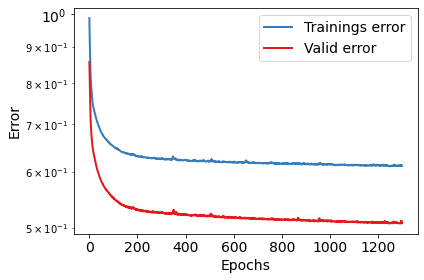

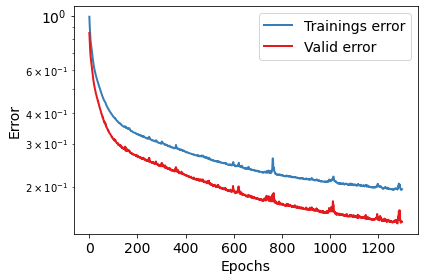

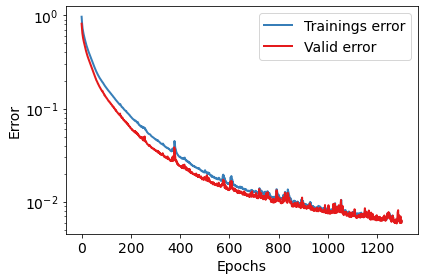

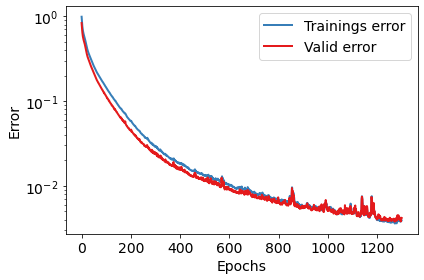

In [ ]:

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
def ADS(sensor_number,bottle_neck):
  sensor_number = sensor_number
  gtrain_out, gvalid_out, strain_DS, svalid_DS, gtest_stan, stest_DS, gstats, x_cord   = ADS_train_data(sensor_number,bottle_neck)
  del(gtest_stan,stest_DS)
  #print(gtrain_out,gtrain_out.shape)
  #print(gvalid_out,gvalid_out.shape)
  train = sensorgcdatasetDS(strain_DS, gtrain_out)
  valid = sensorgcdatasetDS(svalid_DS, gvalid_out)

  bs = 399  # batch size
  bsv = 133
  train_data_gen = torch.utils.data.DataLoader(train, shuffle=True, batch_size=bs, num_workers=1)
  valid_data_gen = torch.utils.data.DataLoader(valid, batch_size=bsv, num_workers=1)
  dataloaders = {'train': train_data_gen, 'valid': valid_data_gen}
  dataset_sizes = {'train': len(train_data_gen.dataset), 'valid': len(valid_data_gen.dataset)}
  batch ={'train':bs, 'valid':bsv}

  # Setting up the neural network
  model = ADSnetwork(sensor_number,bottle_neck).cuda()

  # Loss and Optimizer
  criterion = nn.MSELoss(reduction='mean').cuda()
  #optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001,  weight_decay=1e-5)
  #exp_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500], gamma=0.1)

  #phi = pd.read_csv('../preprocessed_data/basis.csv', header=None).to_numpy()
  #sensor_loc = pd.read_csv('../preprocessed_data/sensor_loc.csv', header=None).to_numpy().astype(int)

  num_epochs = 1300
  prev_loss = 100  # large number
  stop = 0
  rerror_train = []
  rerror_valid = []
  for epochs in range(num_epochs):

    for phase in ['train', 'valid']:
        running_loss = 0

        if phase == 'train':
            #exp_lr_scheduler.step()
            model.train()
        else:
            model.eval()

        for i, (sensor, gc) in enumerate(dataloaders[phase]):

            sensor = Variable(sensor).cuda()
            gc = Variable(gc).cuda()

            # clear gradients
            optimizer.zero_grad()
            # forward
            gc_out = model(sensor)
            # calculate loss
            loss = criterion(gc_out, gc)

            if phase == 'train':
                # backward
                loss.backward()
                # update weights
                optimizer.step()

            running_loss += gc_out.shape[0] * loss.data

        if phase == 'train':
            train_epoch_loss = running_loss / dataset_sizes[phase]
        elif phase == 'valid':
            valid_epoch_loss = running_loss / dataset_sizes[phase]
    stop = stop + 1
    if (train_epoch_loss < prev_loss):
        model_wts = model.state_dict()
        prev_loss = train_epoch_loss
        #print('({}) Training Loss: {:.8f} Valid Loss: {:.8f} *'.format(epochs, train_epoch_loss, valid_epoch_loss))
        stop = 0
    else:
        nothing = 0
        #print('({}) Training Loss: {:.8f} Valid Loss: {:.8f} '.format(epochs, train_epoch_loss, valid_epoch_loss))

    if stop == 200:
        print('Early stopping criteria fulfilled')
        break
    rerror_train.append(train_epoch_loss)
    rerror_valid.append(valid_epoch_loss)

  #plot1image(output_last, img_last, gstats)
  plot_graph(rerror_train,rerror_valid)
  torch.save(model_wts, '../content/drive/My Drive/Colab Notebooks/ADSweights_l_s{:d}_bn{:d}_D3'.format(sensor_number, bottle_neck))


for s in [1,2,5,10]:
  bn= 25
  ADS(s,bn)

50


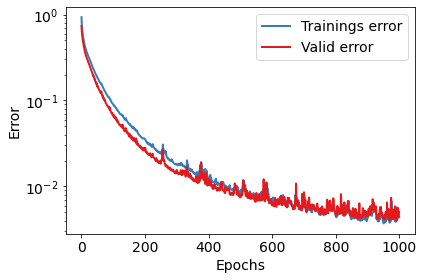

In [ ]:
for bn in [50]:#[5,15,25,50]:
  print(bn)
  s= 5
  ADS(s, bn)

# **POD DEEP STATE**

## PDS TrainLoop

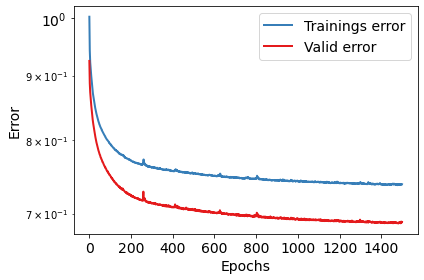

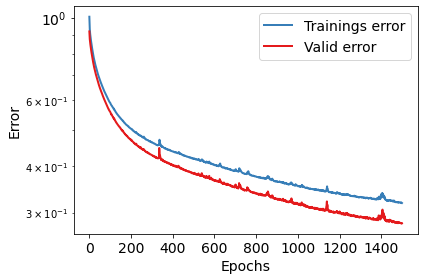

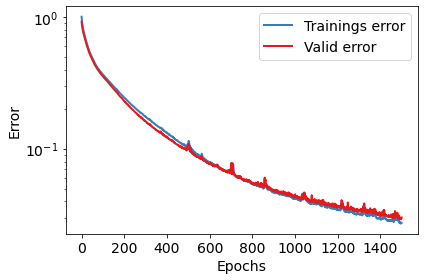

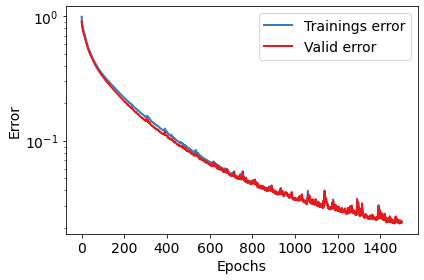

In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable

import scipy.linalg as la
import pandas as pd
import numpy as np

from torch import nn
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
import matplotlib.pyplot as pt
class sensorgcdatasetDS(Dataset):

    def __init__(self, in_file, out_file, transform=None):
        self.in_frame = in_file
        self.out_frame = out_file
        self.transform = transform

    def __len__(self):
        return len(self.in_frame)

    def __getitem__(self, idx):
        inn = self.in_frame[idx, :]
        out = self.out_frame[idx, :]
        inn = torch.from_numpy(inn).float()
        out = torch.from_numpy(out).float()
        return inn, out

if args.data_type == 'transient':   
  def PDS(sensor_number, bottle_neck):
    gtrain_out, gvalid_out, strain_DS, svalid_DS, gtest_stan, stest_DS, gstats, x_cord,phi,mean = PDS_train_data(sensor_number, bottle_neck)
    #print(gtrain_out,gtrain_out.shape)
    #print(gvalid_out,gvalid_out.shape)
    del(gtest_stan, stest_DS,phi,mean)
    train = sensorgcdatasetDS(strain_DS, gtrain_out)
    valid = sensorgcdatasetDS(svalid_DS, gvalid_out)

    bs = 399  # batch size
    bsv = 133
    train_data_gen = torch.utils.data.DataLoader(train, shuffle=True, batch_size=bs, num_workers=1)
    valid_data_gen = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=bsv, num_workers=1)
    dataloaders = {'train': train_data_gen, 'valid':valid_data_gen}
    dataset_sizes = {'train': len(train_data_gen.dataset), 'valid': len(valid_data_gen.dataset)}
    batch ={'train':bs, 'valid':bsv}

    model = PDSnetwork(sensor_number, bottle_neck).cuda()

    # Loss and Optimizer
    criterion = nn.MSELoss()
    #criterion = nn.L1Loss().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0009, weight_decay=1e-5)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.06, momentum=0.9)
    #exp_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500], gamma=0.1)


    num_epochs = 1500
    prev_loss = 100  # large number
    stop = 0
    rerror_train = []
    rerror_valid = []
    for epochs in range(num_epochs):
      for phase in ['train','valid']:
        running_loss=0
        if phase == 'train':
          model.train()
        else:
          model.eval()

        for i, (sensor, gc) in enumerate(dataloaders[phase]):
            sensor = Variable(sensor).cuda()
            gc = Variable(gc).cuda()
            #print(sensor,sensor.shape)
            #print(gc,gc.shape)

            # clear gradients
            optimizer.zero_grad()
            # forward
            gc_out = model(sensor)
            #print(gc_out,gc)

            # calculate loss
            loss = criterion(gc_out, gc)

            if phase=='train':
              #backward
              loss.backward()
              #update weights
              optimizer.step()
              #exp_lr_scheduler.step()
            

            running_loss = gc_out.shape[0] * loss.data + running_loss

        if phase == 'train':
          train_epoch_loss = running_loss/dataset_sizes[phase]
        elif phase == 'valid':
          valid_epoch_loss = running_loss/dataset_sizes[phase]
      stop = stop + 1

      if (valid_epoch_loss < prev_loss):
        model_wts = model.state_dict()
        prev_loss = valid_epoch_loss
        #print('({}) Training Loss: {:.8f} NEW Valid Loss: {:.8f} *'.format(epochs, train_epoch_loss, valid_epoch_loss))
        stop = 0

      else:
        nothing = 0
        #print('({}) Training Loss: {:.8f} Valid Loss: {:.8f} '.format(epochs, train_epoch_loss, valid_epoch_loss))

      if stop == 230:
          print('Early stopping criteria fulfilled')
          break
      rerror_train.append(train_epoch_loss)
      rerror_valid.append(valid_epoch_loss)

    plot_graph(rerror_train,rerror_valid)
    model_wts = model.state_dict()
    torch.save(model_wts, osp.join(folder, 'PDSweights_l_s{:d}_bn{:d}_D3'.format(sensor_number, bottle_neck)))

if args.data_type == 'periodic':   
  def PDS(sensor_number, bottle_neck):
    gtrain_out, gvalid_out, strain_DS, svalid_DS, gtest_stan, stest_DS, gstats, x_cord,phi,mean = PDS_train_data(sensor_number, bottle_neck)
    #print(gtrain_out,gtrain_out.shape)
    #print(gvalid_out,gvalid_out.shape)
    del(gtest_stan, stest_DS,phi,mean)
    train = sensorgcdatasetDS(strain_DS, gtrain_out)
    valid = sensorgcdatasetDS(svalid_DS, gvalid_out)

    # bs = 399  # batch size
    # bsv = 133
    bs = len(train)  # batch size
    bsv = len(valid)
    train_data_gen = torch.utils.data.DataLoader(train, shuffle=True, batch_size=bs, num_workers=1)
    valid_data_gen = torch.utils.data.DataLoader(valid, shuffle=True, batch_size=bsv, num_workers=1)
    dataloaders = {'train': train_data_gen, 'valid':valid_data_gen}
    dataset_sizes = {'train': len(train_data_gen.dataset), 'valid': len(valid_data_gen.dataset)}
    batch ={'train':bs, 'valid':bsv}

    model = PDSnetwork(sensor_number, bottle_neck).cuda()

    # Loss and Optimizer
    criterion = nn.MSELoss()
    #criterion = nn.L1Loss().cuda()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0009, weight_decay=1e-5)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.06, momentum=0.9)
    #exp_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500], gamma=0.1)


    num_epochs = 1200
    prev_loss = 100  # large number
    stop = 0
    rerror_train = []
    rerror_valid = []
    for epochs in range(num_epochs):
      for phase in ['train','valid']:
        running_loss=0
        if phase == 'train':
          model.train()
        else:
          model.eval()

        for i, (sensor, gc) in enumerate(dataloaders[phase]):
            sensor = Variable(sensor).cuda()
            gc = Variable(gc).cuda()
            #print(sensor,sensor.shape)
            #print(gc,gc.shape)

            # clear gradients
            optimizer.zero_grad()
            # forward
            gc_out = model(sensor)
            #print(gc_out,gc)

            # calculate loss
            loss = criterion(gc_out, gc)

            if phase=='train':
              #backward
              loss.backward()
              #update weights
              optimizer.step()
              #exp_lr_scheduler.step()
            

            running_loss = gc_out.shape[0] * loss.data + running_loss

        if phase == 'train':
          train_epoch_loss = running_loss/dataset_sizes[phase]
        elif phase == 'valid':
          valid_epoch_loss = running_loss/dataset_sizes[phase]
      stop = stop + 1

      if (valid_epoch_loss < prev_loss):
        model_wts = model.state_dict()
        #print('k.o.')
        prev_loss = valid_epoch_loss
        #print('({}) Training Loss: {:.8f} NEW Valid Loss: {:.8f} *'.format(epochs, train_epoch_loss, valid_epoch_loss))
        stop = 0

      else:
        #print('({}) Training Loss: {:.8f} Valid Loss: {:.8f} '.format(epochs, train_epoch_loss, valid_epoch_loss))
        l= 0

      if stop == 200:
          #print('Early stopping criteria fulfilled')
          break
      rerror_train.append(train_epoch_loss)
      rerror_valid.append(valid_epoch_loss)

    plot_graph(rerror_train,rerror_valid)
    model_wts = model.state_dict()
    torch.save(model_wts, '../content/drive/My Drive/Colab Notebooks/PDSweights_s{:d}_bn{:d}_Ds'.format(sensor_number, bottle_neck))


for s in [1,2,5,10]:
  bn = 25
  PDS(s, bn)

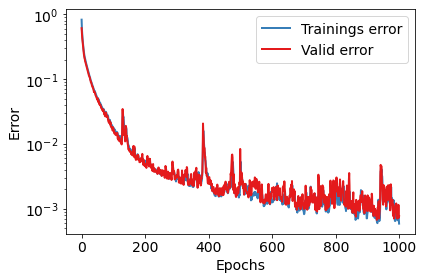

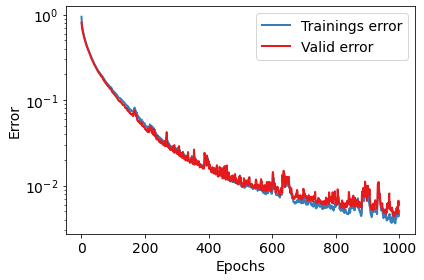

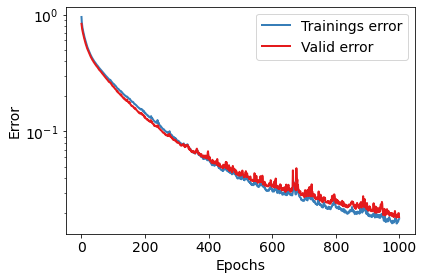

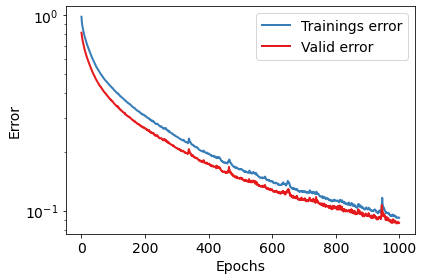

In [ ]:
for bn in [5,15,25,50]:
  s = 5
  PDS(s, bn)

## PDS TestLoop

no. of sensors 1 SNR 72
in autoencoder_train_data--noise data SNR = 72
in autoencoder_train_data-- no noise data
Error 1 0.5606387394041641
335
SAVED - ../content/drive/My Drive/Colab Notebooks/contours/Tr/im_PDSv3_s1_Tr_SNR72.eps


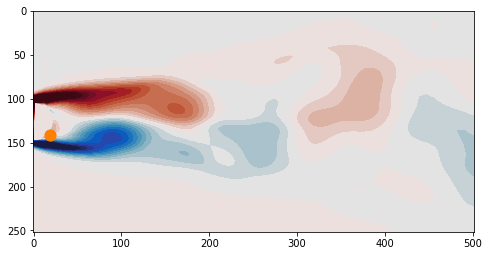

no. of sensors 2 SNR 72
in autoencoder_train_data--noise data SNR = 72
in autoencoder_train_data-- no noise data
Error 2 0.6703084244328023
335
SAVED - ../content/drive/My Drive/Colab Notebooks/contours/Tr/im_PDSv3_s2_Tr_SNR72.eps


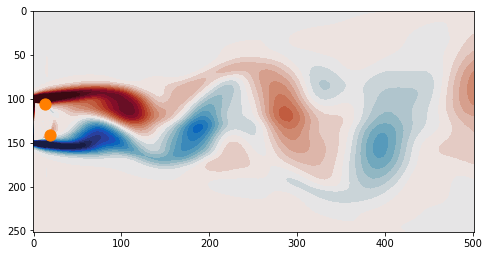

In [ ]:
import pandas as pd
import numpy as np
import cmocean

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
import matplotlib.pyplot as pt

if args.data_type == 'transient': 
  def FR_PDS(sensor_number, bottle_neck, **kwargs): 
    pretrained_weightsRNN = osp.join(folder, 'PDSweights_l_s{:d}_bn{:d}_D3'.format(sensor_number, bottle_neck))
    gtrain_out, gvalid_out, strain_in, svalid_in, gtest_stan, stest_in_stacked, gstats, x_cord,phi,mean = PDS_train_data(sensor_number,bottle_neck, 
                                                                                                                        drop=kwargs.get('drop',None), 
                                                                                                                        SNR=kwargs.get('SNR',None), 
                                                                                                                        data_noise =kwargs.get('drop',None))
    
    del(gtrain_out, gvalid_out, strain_in, svalid_in)
    # Setting up the neural network
    modell = PDSnetwork(sensor_number, bottle_neck)

    # Load saved neural network weights
    modell.load_state_dict(torch.load(pretrained_weightsRNN))
    modell.eval()

    # Load snapshots of sensor data and gc for testing
    test = sensorgcdatasetDS(stest_in_stacked, gtest_stan)
    #print(stest_in_stacked.shape)
    #print( gtest_stan.shape)

    gc_pred = np.zeros([len(test), bottle_neck])
    gc_pod = np.zeros([len(test), bottle_neck])
    for i, (sensor, gc) in enumerate(test):
        y = modell(sensor)
        gc_out = y.data.numpy()
        gc_pred[i, :] = gc_out
        gcc = gc.data.numpy()
        gc_pod[i, :] = gcc

    #print(gc_pred)
    #acc_avg = np.mean(err)
    gc_pred = gc_pred * gstats[1, :] + gstats[0, :]
    gc_pod = gc_pod*gstats[1, :] + gstats[0, :]

    trainAE, validAE, testAE, stats = autoencoder_train_data()
    #mean = np.mean(trainAE, axis = 0)
    #X = trainAE - mean
    #X = X.transpose()
    #phi, s, V = np.linalg.svd(X,full_matrices=False)
    del(trainAE,validAE)
    #phi = phi[:,0:bottle_neck]

    t_pred = gc_pred.dot(phi.T) 
    t_true = testAE - mean#np.mean(total[:,:].transpose(), axis = 1)

    t_pred = gc_pred.dot(phi.T) + mean#np.mean(total[:,:].transpose(), axis = 1)
    t_pod = gc_pod.dot(phi.T) + mean#np.mean(total[:,:].transpose(), axis = 1)
    t_true = testAE

    #gc_pod = gtest_out*gstats[1, :] + gstats[0, :]
    #t_pred = gc_pod.dot(phi.T) + mean
    #error = np.linalg.norm(t_true - t_pred) / np.linalg.norm(t_true)
    #print(error)

    #plot1image(t_pred,t_true, stats)


    Terr = []
    for i in range(0,398):
        Terr.append(np.linalg.norm(t_true[i,:] - t_pred[i,:]) / np.linalg.norm(t_true[i,:]))

    Terr_avg = np.mean(Terr)
    print("Error",sensor_number, Terr_avg)

    #nx=299 ny=502 ns = nx*ny
    m,n = mn()
    ny,nx = m,n
    x2 = np.arange(0, ny, 1)
    y2 = np.arange(0, nx, 1)
    mX, mY = np.meshgrid(x2, y2)

    # for i in [335]:
    #   print(i)
    #   t_predd = t_pred[i,:].reshape((ny, nx))
    #   minmax = np.max(np.abs(t_predd)) * 0.65
    #   pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    #   im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    #   pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
    #   pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
    #   im_name = 'im_PDSv3_s{:d}_Tr_SNR{}.eps'.format(sensor_number, SNR)
    #   jjkjkj = osp.join(folder_save_results, dir1)
    #   pt.savefig(osp.join(jjkjkj, '{}'.format(im_name, kwargs.get('SNR',1000))) ,format='eps')
    #   print('SAVED -', osp.join(jjkjkj, '{}'.format(im_name, kwargs.get('SNR',1000))))
    #   pt.show()
    #   #pt.pcolormesh(t_predd.T, cmap=pt.cm.jet, vmin=-0.0003, vmax=0.0003)
    #   #pt.pcolormesh(t_predd.T)
    #   #pt.show()
    #   #********************************************************
    #   t_podd = t_pod[i,:].reshape((ny, nx))
    #   minmax = np.max(np.abs(t_podd)) * 0.65
    #   pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    #   im = pt.imshow(t_podd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    #   pt.contourf(mX, mY, t_podd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax)
    #   pt.show()
    #   #********************************************************  
    #   t_truee = t_true[i,:].reshape((ny, nx))
    #   minmax = np.max(np.abs(t_truee)) * 0.65
    #   pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    #   im = pt.imshow(t_truee.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    #   pt.contourf(mX, mY, t_truee.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax)
    #   pt.show()
    del(t_pred,t_pod,t_true)
    return Terr_avg

if args.data_type == 'periodic':   
  def FR_PDS(sensor_number, bottle_neck, **kwargs): 
    pretrained_weights = osp.join(folder, 'PDSweights_s{:d}_bn{:d}_Ds'.format(sensor_number, bottle_neck))
    gtrain_out, gvalid_out, strain_in, svalid_in, gtest_stan, stest_in_stacked, gstats, x_cord,phi,mean = PDS_train_data(sensor_number,bottle_neck, 
                                                                                                                        drop=kwargs.get('drop',None), 
                                                                                                                        SNR=kwargs.get('SNR',None), 
                                                                                                                        data_noise =kwargs.get('drop',None))
    del(gtrain_out, gvalid_out, strain_in, svalid_in)
    # Setting up the neural network
    modell = PDSnetwork(sensor_number, bottle_neck)

    # Load saved neural network weights
    modell.load_state_dict(torch.load(pretrained_weights))
    modell.eval()

    # Load snapshots of sensor data and gc for testing
    test = sensorgcdatasetDS(stest_in_stacked, gtest_stan)
    #print(stest_in_stacked.shape)
    #print( gtest_stan.shape)

    gc_pred = np.zeros([len(test), bottle_neck])
    gc_pod = np.zeros([len(test), bottle_neck])
    for i, (sensor, gc) in enumerate(test):
        y = modell(sensor)
        gc_out = y.data.numpy()
        gc_pred[i, :] = gc_out
        gcc = gc.data.numpy()
        gc_pod[i, :] = gcc

    #print(gc_pred)
    #acc_avg = np.mean(err)
    gc_pred = gc_pred * gstats[1, :] + gstats[0, :]
    gc_pod = gc_pod*gstats[1, :] + gstats[0, :]

    trainAE, validAE, testAE, stats = autoencoder_train_data(drop=0, SNR=kwargs.get('SNR',10))
    mean = np.mean(trainAE, axis = 0)
    #X = trainAE - mean
    #X = X.transpose()
    #phi, s, V = np.linalg.svd(X,full_matrices=False)
    del(trainAE,validAE)
    #phi = phi[:,0:bottle_neck]

    t_pred = gc_pred.dot(phi.T) 
    t_true = testAE - mean#np.mean(total[:,:].transpose(), axis = 1)

    t_pred = gc_pred.dot(phi.T) + mean#np.mean(total[:,:].transpose(), axis = 1)
    t_pod = gc_pod.dot(phi.T) + mean#np.mean(total[:,:].transpose(), axis = 1)
    t_true = testAE

    #gc_pod = gtest_out*gstats[1, :] + gstats[0, :]
    #t_pred = gc_pod.dot(phi.T) + mean
    #error = np.linalg.norm(t_true - t_pred) / np.linalg.norm(t_true)
    #print(error)

    #plot1image(t_pred,t_true, stats)


    Terr = []
    for i in range(0,60):
        Terr.append(np.linalg.norm(t_true[i,:] - t_pred[i,:]) / np.linalg.norm(t_true[i,:]))

    Terr_avg = np.mean(Terr)
    print("Error",sensor_number, Terr_avg)

    #nx=299 ny=251 ns = nx*ny
    m,n = mn()
    ny,nx = m,n
    x2 = np.arange(0, ny, 1)
    y2 = np.arange(0, nx, 1)
    mX, mY = np.meshgrid(x2, y2)

    for i in [39] :
      # continue
      print(i)
      t_predd = t_pred[i,:].reshape((ny, nx))
      minmax = np.max(np.abs(t_predd)) * 0.65
      pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
      im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
      pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
      pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
      # im_name = 'im_PDSv3_s{:d}_Ds_noise.eps'.format(sensor_number)
      im_name = 'im_PDSv3_s{:d}_Ds_SNR{}.eps'.format(sensor_number, SNR)
      jjkjkj = osp.join(folder_save_results, dir1)
      pt.savefig(osp.join(jjkjkj, '{}'.format(im_name, kwargs.get('SNR',10))) ,format='eps')
      print('SAVED -', osp.join(jjkjkj, '{}'.format(im_name, kwargs.get('SNR',10))))
      pt.show()
      #pt.pcolormesh(t_predd.T, cmap=pt.cm.jet, vmin=-0.0003, vmax=0.0003)
      #pt.pcolormesh(t_predd.T)
      #pt.show()
      #********************************************************
      # t_podd = t_pod[i,:].reshape((ny, nx))
      # minmax = np.max(np.abs(t_podd)) * 0.65
      # pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
      # im = pt.imshow(t_podd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
      # pt.contourf(mX, mY, t_podd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
      # pt.show()
      #********************************************************  
      t_truee = t_true[i,:].reshape((ny, nx))
      minmax = np.max(np.abs(t_truee)) * 0.65
      pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
      im = pt.imshow(t_truee.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
      pt.contourf(mX, mY, t_truee.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
      if s == 1:
        im_name = 'im_true_39_Ds.eps'
        # pt.savefig('../content/drive/My Drive/Colab Notebooks/results4/pr/{}'.format(im_name),format='eps')
        # print('SAVED -','../content/drive/My Drive/Colab Notebooks/results4/pr/{}'.format(im_name))

      # pt.show()
    del(t_pred,t_pod,t_true)

    return Terr_avg

noise_error = np.zeros((1, 1, 25))
for s, i in [[5, 2], [2, 1]]:#, [5, 2]]:
    for bn in [25]:
      for SNR in range(0,100,4):
        print('no. of sensors',s,'SNR',SNR)
        aaa = FR_PDS(s,bn,drop=1,SNR=SNR)
        noise_error[i, 0, int(SNR/4)] = aaa
# np.savetxt(osp.join(path2, "noise_error_s_1_PDS.csv"), noise_error[0], delimiter=",")
# np.savetxt(osp.join(path2, "noise_error_s_2_PDS.csv"), noise_error[1], delimiter=",")
np.savetxt(osp.join(path2, "noise_error_s_5_PDS.csv"), noise_error[0], delimiter=",")




# **LSTMV3**

In [ ]:
del( train, valid, train_data_gen, valid_data_gen, dataloaders)

## LSTM TrainLoop

In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
    
if args.data_type == 'transient':    
  def LSTM(sensor_number, seq_len, bottle_neck, **kwargs):    

    print('sensor_number =',sensor_number,'seq_len = ',seq_len)
    hidden_size = 50
    layers = 1
    seq_impct = int((seq_len-1)/2)

    gtrain_out, gvalid_out, strain_in, svalid_in, gtest_stan, stest_in_stacked, gstats,x_cord  = rnn_train_data(sensor_number, 
                                                                                                                bottle_neck,
                                                                                                                seq_len, 
                                                                                                                drop =kwargs.get('drop',None), 
                                                                                                                data_noise=None)
    del(gtest_stan, stest_in_stacked)
    train = sensorgcdatasetRNN(strain_in, gtrain_out)
    valid = sensorgcdatasetRNN(svalid_in, gvalid_out)
    print(strain_in.shape)
    print(gtrain_out.shape)
    print(svalid_in.shape)
    print(gvalid_out.shape)

    bs = len(train)  # batch size
    print(bs)
    bsv = len(valid)
    print(bsv)
    train_data_gen = torch.utils.data.DataLoader(train, shuffle=False, batch_size=bs, num_workers=1)
    valid_data_gen = torch.utils.data.DataLoader(valid, shuffle=False, batch_size=bsv, num_workers=1)
    dataloaders = {'train': train_data_gen, 'valid':valid_data_gen}
    dataset_sizes = {'train': len(train_data_gen.dataset), 'valid': len(valid_data_gen.dataset)}
    batch ={'train':bs, 'valid':bsv}
    # Setting up the neural network

    if args.RNN == 'lstm':
      model = LSTMv3network(hidden_size, sensor_number, bottle_neck, layers, seq_len).cuda()
    elif args.RNN == 'rnn':
      model = RNNv3network(hidden_size, sensor_number, bottle_neck, layers, seq_len).cuda()

    # Loss and Opti mizer
    #criterion = nn.MSELoss(reduction='mean').cuda()
    criterion = nn.MSELoss().cuda()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.008, betas=(0.8, 0.8), eps=1e-08, weight_decay=0.01,)
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.00075,  weight_decay=1e-5)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0008,  weight_decay=1e-5)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.06, momentum=0.9)
    #exp_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500], gamma=0.1)

    num_epochs = 2605#0
    prev_loss = 100  # large number
    stop = 0
    rerror_train = []
    rerror_valid = []
    for epochs in range(num_epochs):
      for phase in ['train','valid']:
        running_loss=0
        if phase == 'train':
          model.train()
        else:
          model.eval()
        #print(phase)
        for i, (sensor, gc) in enumerate(dataloaders[phase]):
            #print(sensor)
            kk = 0

            if args.operation_mode == 'online': 
              y = torch.zeros((seq_impct+1), batch[phase], sensor_number)
              for i in range(0, batch[phase]):
                  for j in range(0, (seq_impct+1)):
                      y[j, i,:] = sensor[i, sensor_number*j: sensor_number*j + sensor_number]
                      
            elif args.operation_mode == 'offline':
              y = torch.zeros(seq_len, batch[phase], sensor_number)
              for i in range(0, batch[phase]):
                  for j in range(0, seq_len):
                      y[j, i,:] = sensor[i, sensor_number*j: sensor_number*j + sensor_number]
                        
            sensor = Variable(y).cuda()
            gc = Variable(gc).cuda()

            # clear gradients
            optimizer.zero_grad()
            # forward
            gc_out = model(sensor)
            #print(gc_out,gc)

            # calculate loss
            loss = criterion(gc_out, gc)
            if phase=='train':
              #backward
              loss.backward()
              #update weights
              optimizer.step()
              #exp_lr_scheduler.step()

            running_loss = gc_out.shape[0] * loss.data + running_loss

        if phase == 'train':
          train_epoch_loss = running_loss/dataset_sizes[phase]
        elif phase == 'valid':
          valid_epoch_loss = running_loss/dataset_sizes[phase]
      stop = stop + 1

      if (valid_epoch_loss < prev_loss):
        model_wts = model.state_dict()
        prev_loss = valid_epoch_loss
        prev_T_loss = train_epoch_loss
        # print('({}) Training Loss: {:.8f} NEW Valid Loss: {:.8f} *'.format(epochs, train_epoch_loss, valid_epoch_loss))
        stop = 0
        output_last = gc_out
        gc_last = gc
        # Z = []
        # for  param in model.parameters():
        #   z = param.cpu().detach().numpy()
        #   Z.append(z)

      else:
        nothing = 1
        #print('({}) Training Loss: {:.8f} Valid Loss: {:.8f} '.format(epochs, train_epoch_loss, valid_epoch_loss))
      
      if stop == 230:
          print('Early stopping criteria fulfilled')
          break
          j = 0
          # for  param in model.parameters():
          #   param.data = torch.from_numpy(Z[j]).cuda()
          #   j = j+1  
          # optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
          # #break
      rerror_train.append(train_epoch_loss)
      rerror_valid.append(valid_epoch_loss)

    #plot1image(output_last, img_last, gstats)
    print('({}) BEST_Training Loss: {:.8f} BEST_Valid Loss: {:.8f} '.format(epochs, prev_T_loss, prev_loss))
    print('overrrrrrrrrrrrrr')
    plot_graph(rerror_train,rerror_valid)

    if args.RNN == 'lstm':
      if kwargs.get('drop',None):
        torch.save(model_wts, osp.join(path3, 'LSTMV3_s{:d}_sq{:d}_bn{:d}_D333_dropout1_AREdrop0_weights'.format(sensor_number,seq_len, bottle_neck)))
        print('saved Ds_dropout1333_AREdrop0_weights')
      else:
        no=0
        torch.save(model_wts, osp.join(path3, 'LSTMv3_s{:d}_sq{:d}_bn{:d}_D3_weights'.format(sensor_number,seq_len, bottle_neck)))
        print('saved LSTMv3_s{:d}_sq{:d}_bn{:d}_D3_weights')
    elif args.RNN == 'rnn':
      if kwargs.get('drop',None):
        torch.save(model_wts, osp.join(path3, 'RNNV3_s{:d}_sq{:d}_bn{:d}_D3_dropout1_AREdrop0_weights'.format(sensor_number,seq_len, bottle_neck)))
        print('saved Ds_dropout1_AREdrop0_weights')
      else:
        no=0
        torch.save(model_wts, osp.join(path3, 'RNNv3_s{:d}_sq{:d}_bn{:d}_D3_weights'.format(sensor_number,seq_len, bottle_neck)))
        print('saved RNNv3_s{:d}_sq{:d}_bn{:d}_D3_weights')
  
if args.data_type == 'periodic':
  def LSTM(sensor_number, seq_len, bottle_neck, **kwargs):    
    print('sensor_number =',sensor_number,'seq_len = ',seq_len)
    hidden_size = 50
    layers = 1
    seq_impct = int((seq_len-1)/2)

    gtrain_out, gvalid_out, strain_in, svalid_in, gtest_stan, stest_in_stacked, gstats,x_cord  = rnn_train_data(sensor_number, 
                                                                                                                bottle_neck,
                                                                                                                seq_len, 
                                                                                                                drop =kwargs.get('drop',None), 
                                                                                                                data_noise=None)
    del(gtest_stan, stest_in_stacked)
    train = sensorgcdatasetRNN(strain_in, gtrain_out)
    valid = sensorgcdatasetRNN(svalid_in, gvalid_out)
    print(strain_in.shape)
    print(gtrain_out.shape)
    print(svalid_in.shape)
    print(gvalid_out.shape)

    bs = len(train)  # batch size
    print(bs)
    bsv = len(valid)
    print(bsv)
    train_data_gen = torch.utils.data.DataLoader(train, shuffle=False, batch_size=bs, num_workers=1)
    valid_data_gen = torch.utils.data.DataLoader(valid, shuffle=False, batch_size=bsv, num_workers=1)
    dataloaders = {'train': train_data_gen, 'valid':valid_data_gen}
    dataset_sizes = {'train': len(train_data_gen.dataset), 'valid': len(valid_data_gen.dataset)}
    batch ={'train':bs, 'valid':bsv}
    # Setting up the neural network

    if args.RNN == 'lstm':
      model = LSTMv3network(hidden_size, sensor_number, bottle_neck, layers, seq_len).cuda()
    elif args.RNN == 'rnn':
      model = RNNv3network(hidden_size, sensor_number, bottle_neck, layers, seq_len).cuda()

    # Loss and Opti mizer
    #criterion = nn.MSELoss(reduction='mean').cuda()
    criterion = nn.MSELoss().cuda()
    #optimizer = torch.optim.Adam(model.parameters(), lr=0.008, betas=(0.8, 0.8), eps=1e-08, weight_decay=0.01,)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0006,  weight_decay=1e-5)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.06, momentum=0.9)
    #exp_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500], gamma=0.1)

    num_epochs = 2700
    prev_loss = 100  # large number
    stop = 0
    rerror_train = []
    rerror_valid = []
    for epochs in range(num_epochs):
      for phase in ['train','valid']:
        running_loss=0
        if phase == 'train':
          model.train()
        else:
          model.eval()
        #print(phase)
        for i, (sensor, gc) in enumerate(dataloaders[phase]):
            #print(sensor)
            kk = 0
            if args.operation_mode == 'online': 
              y = torch.zeros((seq_impct+1), batch[phase], sensor_number)
              for i in range(0, batch[phase]):
                  for j in range(0, (seq_impct+1)):
                      y[j, i,:] = sensor[i, sensor_number*j: sensor_number*j + sensor_number]
                
            elif args.operation_mode == 'offline':
              y = torch.zeros(seq_len, batch[phase], sensor_number)
              for i in range(0, batch[phase]):
                  for j in range(0, seq_len):
                      y[j, i,:] = sensor[i, sensor_number*j: sensor_number*j + sensor_number]
                         
            sensor = Variable(y).cuda()
            gc = Variable(gc).cuda()

            # clear gradients
            optimizer.zero_grad()
            # forward
            gc_out = model(sensor)
            #print(gc_out,gc)

            # calculate loss
            loss = criterion(gc_out, gc)
            if phase=='train':
              #backward
              loss.backward()
              #update weights
              optimizer.step()
              #exp_lr_scheduler.step()

            running_loss = gc_out.shape[0] * loss.data + running_loss

        if phase == 'train':
          train_epoch_loss = running_loss/dataset_sizes[phase]
        elif phase == 'valid':
          valid_epoch_loss = running_loss/dataset_sizes[phase]
      stop = stop + 1

      if (valid_epoch_loss < prev_loss):
        model_wts = model.state_dict()
        prev_loss = valid_epoch_loss
        prev_T_loss = train_epoch_loss
        # print('({}) Training Loss: {:.8f} NEW Valid Loss: {:.8f} *'.format(epochs, train_epoch_loss, valid_epoch_loss))
        stop = 0
        output_last = gc_out
        gc_last = gc
        Z = []
        for  param in model.parameters():
          z = param.cpu().detach().numpy()
          Z.append(z)

      else:
        nothing = 1
        #print('({}) Training Loss: {:.8f} Valid Loss: {:.8f} '.format(epochs, train_epoch_loss, valid_epoch_loss))
      
      if stop == 230:
          print('Early stopping criteria fulfilled')
          break
          j = 0
          # for  param in model.parameters():
          #   param.data = torch.from_numpy(Z[j]).cuda()
          #   j = j+1  
          # optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
          # #break
      rerror_train.append(train_epoch_loss)
      rerror_valid.append(valid_epoch_loss)

    #plot1image(output_last, img_last, gstats)
    print('({}) BEST_Training Loss: {:.8f} BEST_Valid Loss: {:.8f} '.format(epochs, prev_T_loss, prev_loss))
    print('overrrrrrrrrrrrrr')
    plot_graph(rerror_train,rerror_valid)

    if args.RNN == 'lstm':
      if kwargs.get('drop',None):
        # print('here')
        torch.save(model_wts, osp.join(path3, 'RNNv3_LSTM_s{:d}_sq{:d}_bn{:d}_Ds33_dropout1_AREdrop0_weights'.format(sensor_number,seq_len, bottle_neck)))
        print('saved Ds_dropout1_AREdrop0_weights')
      else:
        no=0
        torch.save(model_wts, osp.join(path3, 'RNNv3_LSTM_s{:d}_sq{:d}_bn{:d}_Ds_weights'.format(sensor_number,seq_len, bottle_neck)))
        print('saved RNNv3_LSTM_s{:d}_sq{:d}_bn{:d}_Ds_weights')
    elif args.RNN == 'rnn':
      if kwargs.get('drop',None):
        torch.save(model_wts, osp.join(path3, 'RNNV3_s{:d}_sq{:d}_bn{:d}_Pr_dropout1_AREdrop0_weights'.format(sensor_number,seq_len, bottle_neck)))
        print('saved RNNV3_s{:d}_sq{:d}_bn{:d}_Pr_dropout1_AREdrop0_weights')
      else:
        no=0
        torch.save(model_wts, osp.join(path3, 'RNNv3_s{:d}_sq{:d}_bn{:d}_Pr_weights'.format(sensor_number,seq_len, bottle_neck)))
        print('saved RNNv3_s{:d}_sq{:d}_bn{:d}_Pr_weights')
        

  
import time
for s in [10]:#,5,10]:
  for seq_len in [7]:
    bn = 25
    start_time = time.time()
    for drop in [0]:
      LSTM(s,seq_len, bn, drop=drop)

#  can be trained more
# for s in [1]:#,5,10]:
#   for seq_len in [5, 7]:
#     bn = 25
#     start_time = time.time()
#     for drop in [0]:
#       LSTM(s,seq_len, bn, drop=drop)
    # print("--- %s seconds --" % (time.time() - start_time))  

sensor_number = 10 seq_len =  7
in rrntriandata 0
in autoencoder_train_data-- no noise data
(180, 42168)
(60, 42168)
without_drop
(177, 40)
(177, 25)
(57, 40)
(57, 25)
177
57
args.data_type == periodic 
 using lstm cell


RuntimeError: ignored

## LSTM TestLoop

In [ ]:
import cmocean

if args.data_type == 'transient':
  def FR_rnn(sensor_number,seq_len, bottle_neck, **kwargs):

    if args.RNN == 'lstm':
      if kwargs.get('drop',None):
        print('using Ds_dropout1_AREdrop0_weights')
        pretrained_weightsRNN = osp.join(path3, 'LSTMV3_s{:d}_sq{:d}_bn{:d}_D333_dropout1_AREdrop0_weights'.format(sensor_number,seq_len, bottle_neck))
      else:
        no=0
        pretrained_weightsRNN = osp.join(path3, 'LSTMv3_s{:d}_sq{:d}_bn{:d}_D3_weights'.format(sensor_number,seq_len, bottle_neck))
    elif args.RNN == 'rnn':
      if kwargs.get('drop',None):
        print('using Ds_dropout1_AREdrop0_weights')
        pretrained_weightsRNN = osp.join(path3, 'RNNV3_s{:d}_sq{:d}_bn{:d}_D3_dropout1_AREdrop0_weights'.format(sensor_number,seq_len, bottle_neck))
      else:
        no=0
        pretrained_weightsRNN = osp.join(path3, 'RNNv3_s{:d}_sq{:d}_bn{:d}_D3_weights'.format(sensor_number,seq_len, bottle_neck))
    
      
    sensor_number = sensor_number
    hidden_size = 50
    layers = 1
    seq_impct = int((seq_len-1)/2)

    gtrain_out, gvalid_out, strain_in, svalid_in, gtest_stan, stest_in_stacked, gstats, x_cord  = rnn_train_data(sensor_number, 
                                                                                                                bottle_neck, 
                                                                                                                seq_len, 
                                                                                                                drop=kwargs.get('drop',None), 
                                                                                                                SNR=kwargs.get('SNR',None), 
                                                                                                                data_noise=kwargs.get('drop',None))
    #print(gtest_stan.shape,'jkj'))
    del(gtrain_out, gvalid_out, strain_in, svalid_in)
    # Setting up the neural network
    if args.RNN == 'lstm':
      model = LSTMv3network(hidden_size, sensor_number, bottle_neck, layers, seq_len).cuda()
    elif args.RNN == 'rnn':
      model = RNNv3network(hidden_size, sensor_number, bottle_neck, layers, seq_len).cuda()

    # Load saved neural network weights
    model.load_state_dict(torch.load(pretrained_weightsRNN))
    model.eval()

    # Load snapshots of sensor data and gc for testing
    test = sensorgcdatasetRNN(stest_in_stacked, gtest_stan)
    #test = sensorgcdatasetRNN(svalid_in, gvalid_out)
    test_data_genn = torch.utils.data.DataLoader(test, shuffle=False, batch_size=1, num_workers=1)

    # predicting generalized coordinates from sensor data
    #err = []
    gc_pred = np.zeros([len(test), bottle_neck])
    for i, (sensor, gc) in enumerate(test):
        if args.operation_mode == 'online': 
          y = torch.zeros((seq_impct+1),1, sensor_number)
          for j in range(0, (seq_impct+1)):
              y[j,0, :] = sensor[sensor_number*j : (sensor_number*j + sensor_number)]
                    
        elif args.operation_mode == 'offline':
          y = torch.zeros(seq_len,1, sensor_number)
          for j in range(0, seq_len):
              y[j,0, :] = sensor[sensor_number*j : (sensor_number*j + sensor_number)]
              
        gc_out = model(y.cuda()).cpu().data.numpy()
        gc_pred[i, :] = gc_out
        #del(gc_out, y, sensor, gc)
        #err.append(np.linalg.norm(gc.numpy() - gc_pred[i, :]) ** 2 / gc_pred[i, :].size)  # /np.linalg.norm(gc) )
       
    del(stest_in_stacked, gtest_stan)
    #print(gc_pred)
    #acc_avg = np.mean(err)
    gc_pred = gc_pred * gstats[1, :] + gstats[0, :]

    if kwargs.get('drop',None):
      pretrained_weightsAE = osp.join(path2, 'nnv2_D333_dropout_bn25_weights')
    else:
      no=0
      pretrained_weightsAE = osp.join(path2, 'nnv2_D3_bn{:d}_weights'.format(bottle_neck))


    trainAE, validAE, testAE, statsAE = autoencoder_train_data()
    del(trainAE,validAE)

    model = autoencoder(bottle_neck, drop=kwargs.get('drop',None)).cuda()

    model.load_state_dict(torch.load(pretrained_weightsAE))
    model.eval()

    if args.operation_mode == 'online': 
      testAA = sensorgcdatasetAA(gc_pred, testAE[seq_impct:399,:], statsAE)
                   
    elif args.operation_mode == 'offline':
      testAA = sensorgcdatasetAA(gc_pred, testAE[seq_impct:399-seq_impct,:], statsAE)
    
    train_data_genn = torch.utils.data.DataLoader(testAA, shuffle=False, batch_size=1, num_workers=1)

    #err = []
    t_pred = np.zeros([len(test), len(testAE[0,:]) ])
    t_true = np.zeros([len(test), len(testAE[0,:]) ])
    #print('jijijij')
    for i, (gc_pre, t) in enumerate(train_data_genn):
        t_out_tensor = model(gc_pre[None, :].cuda())
        t_out = t_out_tensor.cpu().data.numpy()
        t_pred[i, :] = t_out
        t_true[i, :] = t
        #err.append(np.linalg.norm(t.numpy() - t_pred[i, :]) ** 2 / t_pred[i, :].size)
        #print(t_out_tensor.shape)
        contour_select(i, t_out_tensor[0], t, statsAE, x_cord, s, seq_len, seq_impct, **kwargs)
        # if s == 1 or s == 2:
        #   if i ==285-seq_impct:# or i ==280-seq_impct or i ==290-seq_impct:
        #     nothing = 0
        #     # plot1image(t_out_tensor[0], t, statsAE, x_cord, name = 'im_RNNv3_s{:d}_sq{:d}_i{:d}_D3.eps'.format(sensor_number,seq_len,i+seq_impct), save = 0,save2  =0, name2 = 'im_RNNv3_true_s{:d}_sq{:d}_i{:d}_D3.eps'.format(sensor_number,seq_len,i+seq_impct) )
        # if seq_len == 11:
        #   if i == 350- seq_impct :
        #     nothing = 0
        #     # plot1image(t_out_tensor[0], t, statsAE, x_cord, name = 'im_LSTMv3_s{:d}_sq{:d}_D3.eps'.format(sensor_number,seq_len), save = 0)

    #error = np.linalg.norm(t_true - t_pred) / np.linalg.norm(t_true)
    #print(error)

    t_pred = t_pred * statsAE[1, :] + statsAE[0, :]
    t_true = t_true * statsAE[1, :] + statsAE[0, :]

    #acc_avg = np.mean(err)
    #print(acc_avg)
    #print(min(err))

    #error = np.linalg.norm(t_true - t_pred) / np.linalg.norm(t_true)
    #print(error)

    Ferr = []
    if args.operation_mode == 'online':      
        for i in range(200,399-seq_impct):
          Ferr.append(np.linalg.norm(t_true[i,:] - t_pred[i,:]) / np.linalg.norm(t_true[i,:]))
    elif args.operation_mode == 'offline':
      for i in range(200,399-2*seq_impct):
          Ferr.append(np.linalg.norm(t_true[i,:] - t_pred[i,:]) / np.linalg.norm(t_true[i,:]))

    del(t_true,t_pred)
    Ferr_avg = np.mean(Ferr)
    #Terr_max = max(Terr)
    print("Error =",seq_len, Ferr_avg)
    return (seq_len, Ferr_avg)
    #print("Max error =", Terr_max)
  #######################################################$$$$$$$$$$$$$%%%%)

if args.data_type == 'periodic':
  def FR_rnn(sensor_number,seq_len, bottle_neck, **kwargs):
    if args.RNN == 'lstm':
      if kwargs.get('drop',None):
        print('using Ds_dropout1_AREdrop0_weights')
        pretrained_weightsRNN = osp.join(path3, 'RNNv3_LSTM_s{:d}_sq{:d}_bn{:d}_Ds33_dropout1_AREdrop0_weights'.format(sensor_number,seq_len, bottle_neck))
      else:
        no=0
        pretrained_weightsRNN = osp.join(path3, 'RNNv3_LSTM_s{:d}_sq{:d}_bn{:d}_Ds_weights'.format(sensor_number,seq_len, bottle_neck))
    elif args.RNN == 'rnn':
      if kwargs.get('drop',None):
        print('using Ds_dropout1_AREdrop0_weights')
        pretrained_weightsRNN = osp.join(path3, 'RNNV3_s{:d}_sq{:d}_bn{:d}_Pr_dropout1_AREdrop0_weights'.format(sensor_number,seq_len, bottle_neck))
      else:
        no=0
        pretrained_weightsRNN = osp.join(path3, 'RNNv3_s{:d}_sq{:d}_bn{:d}_Pr_weights'.format(sensor_number,seq_len, bottle_neck))

    nx = 168
    ny = 251
    sensor_number = sensor_number
    hidden_size = 50
    layers = 1
    seq_impct = int((seq_len-1)/2)

    gtrain_out, gvalid_out, strain_in, svalid_in, gtest_stan, stest_in_stacked, gstats, x_cord  = rnn_train_data(sensor_number, 
                                                                                                                bottle_neck, 
                                                                                                                seq_len, 
                                                                                                                drop=kwargs.get('drop',None), 
                                                                                                                SNR=kwargs.get('SNR',None), 
                                                                                                                data_noise=kwargs.get('drop',None))
    #print(gtest_stan.shape,'jkj'))
    del(gtrain_out, gvalid_out, strain_in, svalid_in)
    # Setting up the neural network
    if args.RNN == 'lstm':
      model = LSTMv3network(hidden_size, sensor_number, bottle_neck, layers, seq_len).cuda()
    elif args.RNN == 'rnn':
      model = RNNv3network(hidden_size, sensor_number, bottle_neck, layers, seq_len).cuda()


    # Load saved neural network weights
    model.load_state_dict(torch.load(pretrained_weightsRNN))
    model.eval()

    # Load snapshots of sensor data and gc for testing
    test = sensorgcdatasetRNN(stest_in_stacked, gtest_stan)
    #test = sensorgcdatasetRNN(svalid_in, gvalid_out)
    test_data_genn = torch.utils.data.DataLoader(test, shuffle=False, batch_size=1, num_workers=1)

    # predicting generalized coordinates from sensor data
    #err = []
    gc_pred = np.zeros([len(test), bottle_neck])
    for i, (sensor, gc) in enumerate(test):
        if args.operation_mode == 'online': 
          y = torch.zeros((seq_impct+1),1, sensor_number)
          for j in range(0, (seq_impct+1)):
              y[j,0, :] = sensor[sensor_number*j : (sensor_number*j + sensor_number)]
                    
        elif args.operation_mode == 'offline':
          y = torch.zeros(seq_len,1, sensor_number)
          for j in range(0, seq_len):
              y[j,0, :] = sensor[sensor_number*j : (sensor_number*j + sensor_number)]
        
        gc_out = model(y.cuda()).cpu().data.numpy()
        gc_pred[i, :] = gc_out
        #del(gc_out, y, sensor, gc)
        #err.append(np.linalg.norm(gc.numpy() - gc_pred[i, :]) ** 2 / gc_pred[i, :].size)  # /np.linalg.norm(gc) )
        #print(i)
    del(stest_in_stacked, gtest_stan)
    #print(gc_pred)
    #acc_avg = np.mean(err)
    gc_pred = gc_pred * gstats[1, :] + gstats[0, :]

    kAA =  168*251
    if kwargs.get('drop',None):
      pretrained_weightsAE = osp.join(path2, 'nnv2_Ds33_dropout_bn25_weights')
    else:
      no=0
      pretrained_weightsAE = osp.join(path2, 'nnv2_Ds_bn{:d}_weights'.format(bottle_neck))


    trainAE, validAE, testAE, statsAE = autoencoder_train_data()
    del(trainAE,validAE)

    model = autoencoder(bottle_neck, drop=kwargs.get('drop',None)).cuda()

    model.load_state_dict(torch.load(pretrained_weightsAE))
    model.eval()

    if args.operation_mode == 'online': 
      testAA = sensorgcdatasetAA(gc_pred, testAE[seq_impct:399,:], statsAE)
                   
    elif args.operation_mode == 'offline':
      testAA = sensorgcdatasetAA(gc_pred, testAE[seq_impct:399-seq_impct,:], statsAE)
    
    train_data_genn = torch.utils.data.DataLoader(testAA, shuffle=False, batch_size=1, num_workers=1)

    #err = []
    t_pred = np.zeros([len(test), len(testAE[0,:]) ])
    t_true = np.zeros([len(test), len(testAE[0,:]) ])
    #print('jijijij')
    for i, (gc_pre, t) in enumerate(train_data_genn):
        t_out_tensor = model(gc_pre[None, :].cuda())
        t_out = t_out_tensor.cpu().data.numpy()
        t_pred[i, :] = t_out
        t_true[i, :] = t
        #err.append(np.linalg.norm(t.numpy() - t_pred[i, :]) ** 2 / t_pred[i, :].size)
        #print(t_out_tensor.shape)
        contour_select(i, t_out_tensor[0], t, statsAE, x_cord, s, seq_len, seq_impct, **kwargs)
        # if s == 1 or s == 2:
        #   if i ==285-seq_impct:# or i ==280-seq_impct or i ==290-seq_impct:
        #     nothing = 0
        #     # plot1image(t_out_tensor[0], t, statsAE, x_cord, name = 'im_RNNv3_s{:d}_sq{:d}_i{:d}_D3.eps'.format(sensor_number,seq_len,i+seq_impct), save = 0,save2  =0, name2 = 'im_RNNv3_true_s{:d}_sq{:d}_i{:d}_D3.eps'.format(sensor_number,seq_len,i+seq_impct) )
        # if seq_len == 11:
        #   if i == 350- seq_impct :
        #     nothing = 0
        #     # plot1image(t_out_tensor[0], t, statsAE, x_cord, name = 'im_LSTMv3_s{:d}_sq{:d}_D3.eps'.format(sensor_number,seq_len), save = 0)

    #error = np.linalg.norm(t_true - t_pred) / np.linalg.norm(t_true)
    #print(error)

    t_pred = t_pred * statsAE[1, :] + statsAE[0, :]
    t_true = t_true * statsAE[1, :] + statsAE[0, :]

    #acc_avg = np.mean(err)
    #print(acc_avg)
    #print(min(err))

    #error = np.linalg.norm(t_true - t_pred) / np.linalg.norm(t_true)
    #print(error)

    Ferr = []
    if args.operation_mode == 'online':      
        for i in range(0,60-seq_impct):
          Ferr.append(np.linalg.norm(t_true[i,:] - t_pred[i,:]) / np.linalg.norm(t_true[i,:]))
    elif args.operation_mode == 'offline':
      for i in range(0,60-2*seq_impct):
          Ferr.append(np.linalg.norm(t_true[i,:] - t_pred[i,:]) / np.linalg.norm(t_true[i,:]))
          
    # for i in range(0,60-2*seq_impct):
    #     Ferr.append(np.linalg.norm(t_true[i,:] - t_pred[i,:]) / np.linalg.norm(t_true[i,:]))
    del(t_true,t_pred)
    Ferr_avg = np.mean(Ferr)
    #Terr_max = max(Terr)
    print("Error =",seq_len, Ferr_avg)
    #print("Max error =", Terr_max)
    return (seq_len, Ferr_avg)
  #######################################################$$$$$$$$$$$$$%%%%)


noise_error = np.zeros((1, 1, 25))
for s, i in [[5, 0]]:#, [2, 1]]:#, [5, 2]]:
  for seq_len in [7]:#[3, 5, 7, 9]:
    for bn in [25]:
      for SNR in range(0,100,4):
        print('no. of sensors',s,'SNR',SNR)
        aaa = FR_rnn(s,seq_len,bn,drop=1,SNR=SNR)
        noise_error[i, int((seq_len-7)/2), int(SNR/4)] = aaa[1]
# np.savetxt(osp.join(path3, "noise_error_s_1_{}.csv".format(args.RNN)), noise_error[0], delimiter=",")
# np.savetxt(osp.join(path3, "noise_error_s_2_{}.csv".format(args.RNN)), noise_error[1], delimiter=",")
np.savetxt(osp.join(path3, "noise_error_s_5_{}.csv".format(args.RNN)), noise_error[0], delimiter=",")

error = np.zeros((2, 5))
plot_s_list = np.array([10])
plot_seq_len_list = np.array([7])
plot_contour_idx = np.array([335])
for s, i in [[1, 0], [2, 1]]:#, [5, 2]]:
  for seq_len in [3,5,7,9]:
    for bn in [25]:
        # FR_rnn(s,seq_len,bn,drop=0,SNR=10)
        aba = FR_rnn(s,
                     seq_len, 
                     bn,
                     drop=0,SNR=1000, 
                     plot_s_list=plot_s_list, 
                     plot_seq_len_list=plot_seq_len_list, 
                     plot_contour_idx=plot_contour_idx)
        error[i, int((seq_len-3)/2)] = aba[1]

np.savetxt(osp.join(path3, "error_s_1_{}.csv".format(args.RNN)), error[0], delimiter=",")
np.savetxt(osp.join(path3, "error_s_2_{}.csv".format(args.RNN)), error[1], delimiter=",")
# np.savetxt(osp.join(path3, "error_s_5_{}.csv".format(args.RNN)), error[2], delimiter=",")

# for s in [1]:
#   for seq_len in [3, 5, 7, 9]:
#     for bn in [25]:
#         FR_rnn(s,seq_len,bn,drop=0,SNR=10)

no. of sensors 5 SNR 0
using Ds_dropout1_AREdrop0_weights
in autoencoder_train_data--noise data SNR = 0


NameError: ignored

# Recycle Bin

In [ ]:
import numpy as np
import matplotlib.pyplot as pt
import random

a = np.array([[1,2,3],[4,5,7]])

vd = []  
res = []  
random.seed(36123)
res = random.sample(range(41), 15)
for j in range(15):
  vd.append(res[j]*3)
  vd.append(vd[j*3]+1)
  vd.append(vd[j*3]+2)
print(vd)

#b = np.array([[2,3],[7,6]])
#c = np.array([a,b])
#print(c)

#trainAE, validAE, waste, stats = autoencoder_train_data()
#print(trainAE,trainAE.shape)
#print(waste,waste.shape)
#print(stats,stats.shape)
#trainAE_stan = (trainAE - stats[0, :])/stats[1, :]
#ii = (trainAE[4,:] - stats[0, :])/stats[1, :]
#if ii.all() == trainAE_stan[4,:].all():
  #print('perfect')
#print(trainAE,'kokok')
#print(trainAE_stan,'kooko')
#cc = np.concatenate((a, b), axis=1)
#print(cc)
#gtrain_out, gvalid_out, X, Y, gtest, Z, gstats = ds_train_data(15)
#print(Y.shape)
#gtrain_out, gvalid_out, X, Y, gtest, Z, gstats = ds_train_data(5)
#print(X)

m, n = mn()
sensor_num = 5
xk =sensor_cord_data(m,n,sensor_num)
print(xk)

import numpy as np
arr = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
del_rows = np.array([0,2])
np.delete(arr, del_rows, 0)

sensor_number = 10 seq_len =  15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


(1183, 150)
(1183, 25)
(385, 150)
(385, 25)
1183
385


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


(2499) BEST_Training Loss: 0.00068136 BEST_Valid Loss: 0.00108064 
overrrrrrrrrrrrrr


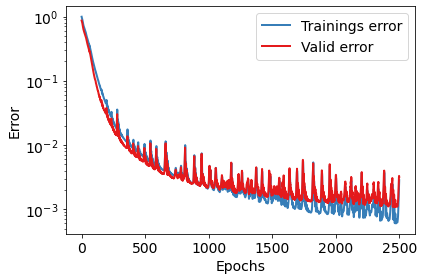

In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
    
def RNN(sensor_number, seq_len, bottle_neck, **kwargs):    
  print('sensor_number =',sensor_number,'seq_len = ',seq_len)
  hidden_size = 50
  layers = 1
  seq_impct = int((seq_len-1)/2)

  gtrain_out, gvalid_out, strain_in, svalid_in, gtest_stan, stest_in_stacked, gstats,x_cord  = rnn_train_data(sensor_number, 
                                                                                                              bottle_neck,
                                                                                                              seq_len, 
                                                                                                              drop =kwargs.get('drop',None), 
                                                                                                              data_noise=None))
  del(gtest_stan, stest_in_stacked)
  train = sensorgcdatasetRNN(strain_in, gtrain_out)
  valid = sensorgcdatasetRNN(svalid_in, gvalid_out)
  print(strain_in.shape)
  print(gtrain_out.shape)
  print(svalid_in.shape)
  print(gvalid_out.shape)

  bs = len(train)  # batch size
  print(bs)
  bsv = len(valid)
  print(bsv)
  train_data_gen = torch.utils.data.DataLoader(train, shuffle=False, batch_size=bs, num_workers=1)
  valid_data_gen = torch.utils.data.DataLoader(valid, shuffle=False, batch_size=bsv, num_workers=1)
  dataloaders = {'train': train_data_gen, 'valid':valid_data_gen}
  dataset_sizes = {'train': len(train_data_gen.dataset), 'valid': len(valid_data_gen.dataset)}
  batch ={'train':bs, 'valid':bsv}
  # Setting up the neural network
  model = RNNv3network(hidden_size, sensor_number, bottle_neck, layers, seq_len).cuda()

  # Loss and Optimizer
  #criterion = nn.MSELoss(reduction='mean').cuda()
  criterion = nn.MSELoss().cuda()
  #optimizer = torch.optim.Adam(model.parameters(), lr=0.008, betas=(0.8, 0.8), eps=1e-08, weight_decay=0.01,)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0006,  weight_decay=1e-5)
  #optimizer = torch.optim.SGD(model.parameters(), lr=0.06, momentum=0.9)
  #exp_lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[500], gamma=0.1)

  num_epochs = 2500
  prev_loss = 100  # large number
  stop = 0
  rerror_train = []
  rerror_valid = []
  for epochs in range(num_epochs):
    for phase in ['train','valid']:
      running_loss=0
      if phase == 'train':
        model.train()
      else:
        model.eval()
      #print(phase)
      for i, (sensor, gc) in enumerate(dataloaders[phase]):
          #print(sensor)
          kk = 0
          y = torch.zeros(seq_len, batch[phase], sensor_number)
          for i in range(0, batch[phase]):
              for j in range(0, seq_len):
                try:
                  y[j, i,:] = sensor[i, sensor_number*j: sensor_number*j + sensor_number]
                except:
                  kk = 9
                  break
          if kk==9:
            break
          #print('expended')
          #print(y)
          sensor = Variable(y).cuda()
          gc = Variable(gc).cuda()

          # clear gradients
          optimizer.zero_grad()
          # forward
          gc_out = model(sensor)
          #print(gc_out,gc)

          # calculate loss
          loss = criterion(gc_out, gc)
          if phase=='train':
            #backward
            loss.backward()
            #update weights
            optimizer.step()
            #exp_lr_scheduler.step()

          running_loss = gc_out.shape[0] * loss.data + running_loss

      if phase == 'train':
        train_epoch_loss = running_loss/dataset_sizes[phase]
      elif phase == 'valid':
        valid_epoch_loss = running_loss/dataset_sizes[phase]
    stop = stop + 1

    if (valid_epoch_loss < prev_loss):
      model_wts = model.state_dict()
      prev_loss = valid_epoch_loss
      prev_T_loss = train_epoch_loss
      #print('({}) Training Loss: {:.8f} NEW Valid Loss: {:.8f} *'.format(epochs, train_epoch_loss, valid_epoch_loss))
      stop = 0
      output_last = gc_out
      gc_last = gc
      Z = []
      for  param in model.parameters():
        z = param.cpu().detach().numpy()
        Z.append(z)

    else:
      nothing = 1
      #print('({}) Training Loss: {:.8f} Valid Loss: {:.8f} '.format(epochs, train_epoch_loss, valid_epoch_loss))
    
    if stop == 230:
        print('Early stopping criteria fulfilled')
        j = 0
        for  param in model.parameters():
          param.data = torch.from_numpy(Z[j]).cuda()
          j = j+1  
        optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
        #break
    rerror_train.append(train_epoch_loss)
    rerror_valid.append(valid_epoch_loss)

  #plot1image(output_last, img_last, gstats)
  print('({}) BEST_Training Loss: {:.8f} BEST_Valid Loss: {:.8f} '.format(epochs, prev_T_loss, prev_loss))
  print('overrrrrrrrrrrrrr')
  plot_graph(rerror_train,rerror_valid)

  torch.save(model_wts, '../content/drive/My Drive/Colab Notebooks/RNNv3_s{:d}_sq{:d}_bn{:d}_D3_weights'.format(sensor_number,seq_len, bottle_neck))

#(2099) BEST_Training Loss: 0.00088292 BEST_Valid Loss: 0.00148734 
#(2999) BEST_Training Loss: 0.00059425 BEST_Valid Loss: 0.00144180
for s in [10]:#[1,2,5,10]:
  for seq_len in [15]:#[3,7,11,15]:
    bn = 25
    RNN(s,seq_len, bn)

In [ ]:
class RNNv3network(nn.Module):

    DROPOUT = 0.5

    def __init__(self, hidden_size,sensor_number, bottle_neck, layers, seq_len):
        super(RNNv3network, self).__init__()
        self.hidden_size = hidden_size

        # Recurrent layers
        self.rl = nn.RNN(input_size=sensor_number , hidden_size=self.hidden_size, num_layers=layers, nonlinearity = 'relu')#, dropout=self.DROPOUT)
        self.rlr = nn.RNN(input_size=sensor_number, hidden_size=self.hidden_size, num_layers=layers, nonlinearity = 'relu')#, dropout=self.DROPOUT)

        # Final feed-forward layer
        self.l1 = nn.Linear(in_features=hidden_size*2, out_features=200, bias=True)
        self.l2 = nn.Linear(in_features=200, out_features=200, bias=True)
        self.l3 = nn.Linear(in_features=200, out_features=bottle_neck, bias=True)
        #self.reset_hidden_states()


    def reset_hidden_states(self, for_batch=None):
        if for_batch is not None:
            batch_size = for_batch.shape[1]

        # Initialize recurrent hidden states
        self.rl_h = self.init_hidden(batch_size=batch_size)
        self.rlr_h = self.init_hidden(batch_size=batch_size)

        if for_batch is not None:
            device = for_batch.device
            self.rl_h = self.rl_h.to(device)
            self.rlr_h = self.rlr_h.to(device)


    def init_hidden(self, batch_size):
        layers =1
        return Variable(torch.zeros(layers, batch_size, self.hidden_size))


    def forward(self, leading_dna):
        self.reset_hidden_states(for_batch=leading_dna)
        
        batch = len(leading_dna[0,:,0])
        #print(batch)
        sensor_number = len(leading_dna[0,0,:])
        #print(sensor_number)
        seq_len = len(leading_dna[:,0,0])
        #print(seq_len)
        seq_impct = int((seq_len-1)/2)

        split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
        split_data2 = torch.zeros(seq_impct+1,batch,sensor_number)
        split_data1 = leading_dna[0:seq_impct+1,:,:] #(seq_impct+1,batch,sensor_number)
        split_data2 = leading_dna[seq_impct:seq_len,:,:]

        rl_out, self.rl_h = self.rl(split_data1, self.rl_h)
        #print('forward_in')
        #print(split_data1)
        #print('first_layer_out')
        #print(rl_out)
        rlr_out, self.rlr_h = self.rlr(self.flip_input(split_data2), self.rlr_h)
        #print('fliped_input')
        #print(self.flip_input(split_data2))
        #print('fliped_output')
        #print(rlr_out)
        r_out = torch.cat((rl_out[seq_impct], rlr_out[seq_impct]), 1)
        #print('concated_middel_layer output')
        #print(r_out)
        l1_out = F.relu(self.l1(r_out))
        l2_out = F.relu(self.l2(l1_out))
        l3_out = self.l3(l2_out)
        return l3_out


    def flip_input(self, input):
        device = input.device
        flipped_array = np.flip(input.data.cpu().numpy(), 0).copy()
        return Variable(torch.from_numpy(flipped_array).to(device))

In [ ]:
if args.operation_mode == 'offline':
  class RNNv3network(nn.Module):

      DROPOUT = 0.5

      def __init__(self, hidden_size,sensor_number, bottle_neck, layers, seq_len):
          super(RNNv3network, self).__init__()
          self.hidden_size = hidden_size

          # Recurrent layers
          self.rl = nn.RNN(input_size=sensor_number , hidden_size=self.hidden_size, num_layers=layers, nonlinearity = 'relu')#, dropout=self.DROPOUT)
          self.rlr = nn.RNN(input_size=sensor_number, hidden_size=self.hidden_size, num_layers=layers, nonlinearity = 'relu')#, dropout=self.DROPOUT)

          # Final feed-forward layer
          self.l1 = nn.Linear(in_features=hidden_size*2, out_features=200, bias=True)
          self.l2 = nn.Linear(in_features=200, out_features=200, bias=True)
          self.l3 = nn.Linear(in_features=200, out_features=bottle_neck, bias=True)
          #self.reset_hidden_states()


      def reset_hidden_states(self, for_batch=None):
          if for_batch is not None:
              batch_size = for_batch.shape[1]

          # Initialize recurrent hidden states
          self.rl_h = self.init_hidden(batch_size=batch_size)
          self.rlr_h = self.init_hidden(batch_size=batch_size)

          if for_batch is not None:
              device = for_batch.device
              self.rl_h = self.rl_h.to(device)
              self.rlr_h = self.rlr_h.to(device)


      def init_hidden(self, batch_size):
          layers =1
          return Variable(torch.zeros(layers, batch_size, self.hidden_size))


      def forward(self, leading_dna):
          self.reset_hidden_states(for_batch=leading_dna)
          
          batch = len(leading_dna[0,:,0])
          #print(batch)
          sensor_number = len(leading_dna[0,0,:])
          #print(sensor_number)
          seq_len = len(leading_dna[:,0,0])
          #print(seq_len)
          seq_impct = int((seq_len-1)/2)

          split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
          split_data2 = torch.zeros(seq_impct+1,batch,sensor_number)
          split_data1 = leading_dna[0:seq_impct+1,:,:] #(seq_impct+1,batch,sensor_number)
          split_data2 = leading_dna[seq_impct:seq_len,:,:]

          rl_out, self.rl_h = self.rl(split_data1, self.rl_h)
          #print('forward_in')
          #print(split_data1)
          #print('first_layer_out')
          #print(rl_out)
          rlr_out, self.rlr_h = self.rlr(self.flip_input(split_data2), self.rlr_h)
          #print('fliped_input')
          #print(self.flip_input(split_data2))
          #print('fliped_output')
          #print(rlr_out)
          r_out = torch.cat((rl_out[seq_impct], rlr_out[seq_impct]), 1)
          #print('concated_middel_layer output')
          #print(r_out)
          l1_out = F.relu(self.l1(r_out))
          l2_out = F.relu(self.l2(l1_out))
          l3_out = self.l3(l2_out)
          return l3_out


      def flip_input(self, input):
          device = input.device
          flipped_array = np.flip(input.data.cpu().numpy(), 0).copy()
          return Variable(torch.from_numpy(flipped_array).to(device))

In [ ]:
class RNNv3network(nn.Module):

    def __init__(self, hidden_size,sensor_number, bottle_neck, layers, seq_len):
        super(RNNv3network, self).__init__()
        self.hidden_size = hidden_size

        # Recurrent layers
        # nn.LSTM()
        self.rl = nn.LSTM(input_size=sensor_number , hidden_size=self.hidden_size, num_layers=layers)#, dropout=0.5)#, nonlinearity = 'relu')#)
        self.rlr = nn.LSTM(input_size=sensor_number, hidden_size=self.hidden_size, num_layers=layers)#, dropout=0.5)#, nonlinearity = 'relu')#)

        # Final feed-forward layer
        self.l1 = nn.Linear(in_features=hidden_size*2, out_features=50, bias=True)
        self.l2 = nn.Linear(in_features=500, out_features=500, bias=True)
        self.l3 = nn.Linear(in_features=500, out_features=bottle_neck, bias=True)
        # self.dropout = nn.Dropout(p=0.5)   #dropout after relu
        # self.bn = nn.BatchNorm1d(num_features=50)   #bn before relu
        # self.bn_25 = nn.BatchNorm1d(num_features=25)
        #self.reset_hidden_states()


    def reset_hidden_states(self, for_batch=None):
        if for_batch is not None:
            batch_size = for_batch.shape[1]

        # Initialize recurrent hidden states
        self.rl_h = self.init_hidden(batch_size=batch_size)
        self.rlr_h = self.init_hidden(batch_size=batch_size)
        self.rl_c = self.init_hidden(batch_size=batch_size)
        self.rlr_c = self.init_hidden(batch_size=batch_size)

        if for_batch is not None:
            device = for_batch.device
            self.rl_h = self.rl_h.to(device)
            self.rlr_h = self.rlr_h.to(device)
            self.rl_c = self.rl_c.to(device)
            self.rlr_c = self.rlr_c.to(device)


    def init_hidden(self, batch_size):
        layers =1
        return Variable(torch.zeros(layers, batch_size, self.hidden_size))


    def forward(self, leading_dna):
        self.reset_hidden_states(for_batch=leading_dna)
        
        batch = len(leading_dna[0,:,0])
        #print(batch)
        sensor_number = len(leading_dna[0,0,:])
        #print(sensor_number)
        seq_len = len(leading_dna[:,0,0])
        #print(seq_len)
        seq_impct = int((seq_len-1)/2)

        split_data1 = torch.zeros(seq_impct+1,batch,sensor_number)
        split_data2 = torch.zeros(seq_impct+1,batch,sensor_number)
        split_data1 = leading_dna[0:seq_impct+1,:,:] #(seq_impct+1,batch,sensor_number)
        split_data2 = leading_dna[seq_impct:seq_len,:,:]

        rl_out, self.rl_h= self.rl(split_data1, (self.rl_h, self.rl_c))
        #print('forward_in')
        #print(split_data1)
        #print('first_layer_out')
        #print(rl_out)
        rlr_out, self.rlr_h = self.rlr(self.flip_input(split_data2), (self.rlr_h, self.rlr_c))
        #print('fliped_input')
        #print(self.flip_input(split_data2))
        #print('fliped_output')
        #print(rlr_out)
        r_out = torch.cat((rl_out[seq_impct], rlr_out[seq_impct]), 1)
        #print('concated_middel_layer output')
        #print(r_out)
        l1_out = F.relu(self.l1(r_out))
        # l1_out = self.bn(l1_out)
        # l1_out = self.dropout(l1_out)
        l2_out = F.relu(self.l2(l1_out))
        # l2_out = self.dropout(l2_out)# = nn.functional.dropout(x, p=0.1, training=self.training) 
        # l2_out = self.bn(l2_out)
        l3_out = self.l3(l2_out)
        # l3_out = self.bn_25(l3_out)
        return l3_out


    def flip_input(self, input):
        device = input.device
        flipped_array = np.flip(input.data.cpu().numpy(), 0).copy()
        return Variable(torch.from_numpy(flipped_array).to(device))

In [ ]:
del( train, valid, train_data_gen, valid_data_gen, dataloaders)

In [ ]:
sensor_number = 1 seq_len =  3
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
(1195, 3)
(1195, 25)
(397, 3)
(397, 25)
1195
397
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
(2499) BEST_Training Loss: 0.11093688 BEST_Valid Loss: 0.10017747 
overrrrrrrrrrrrrr
sensor_number = 1 seq_len =  7
(1191, 7)
(1191, 25)
(393, 7)
(393, 25)
1191
393
(2499) BEST_Training Loss: 0.06197061 BEST_Valid Loss: 0.06045400 
overrrrrrrrrrrrrr
sensor_number = 1 seq_len =  11
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
(1187, 11)
(1187, 25)
(389, 11)
(389, 25)
1187
389
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
(2499) BEST_Training Loss: 0.04347700 BEST_Valid Loss: 0.04832747 
overrrrrrrrrrrrrr
sensor_number = 1 seq_len =  15
(1183, 15)
(1183, 25)
(385, 15)
(385, 25)
1183
385
Early stopping criteria fulfilled
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:234: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
(2499) BEST_Training Loss: 0.03181018 BEST_Valid Loss: 0.03142554

sensor_number = 2 seq_len =  3
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
(1195, 6)
(1195, 25)
(397, 6)
(397, 25)
1195
397
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
Early stopping criteria fulfilled
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:234: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
(2499) BEST_Training Loss: 0.04273108 BEST_Valid Loss: 0.04136109 
overrrrrrrrrrrrrr
sensor_number = 2 seq_len =  7
(1191, 14)
(1191, 25)
(393, 14)
(393, 25)
1191
393
(2499) BEST_Training Loss: 0.00962668 BEST_Valid Loss: 0.01565781 
overrrrrrrrrrrrrr
sensor_number = 2 seq_len =  11
(1187, 22)
(1187, 25)
(389, 22)
(389, 25)
1187
389
Early stopping criteria fulfilled
(2499) BEST_Training Loss: 0.01025694 BEST_Valid Loss: 0.01151269 
overrrrrrrrrrrrrr
sensor_number = 2 seq_len =  15
(1183, 30)
(1183, 25)
(385, 30)
(385, 25)
1183
385
(2499) BEST_Training Loss: 0.00737577 BEST_Valid Loss: 0.00938867 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  3
(1195, 15)
(1195, 25)
(397, 15)
(397, 25)
1195
397
(2499) BEST_Training Loss: 0.00241249 BEST_Valid Loss: 0.00247955 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  7
(1191, 35)
(1191, 25)
(393, 35)
(393, 25)
1191
393
(2499) BEST_Training Loss: 0.00112816 BEST_Valid Loss: 0.00128531 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  11
(1187, 55)
(1187, 25)
(389, 55)
(389, 25)
1187
389
(2499) BEST_Training Loss: 0.00145559 BEST_Valid Loss: 0.00197667 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  15
(1183, 75)
(1183, 25)
(385, 75)
(385, 25)
1183
385
(2499) BEST_Training Loss: 0.00093256 BEST_Valid Loss: 0.00134677 
overrrrrrrrrrrrrr
sensor_number = 10 seq_len =  3
(1195, 30)
(1195, 25)
(397, 30)
(397, 25)
1195
397
(2499) BEST_Training Loss: 0.00120170 BEST_Valid Loss: 0.00150975 
overrrrrrrrrrrrrr
sensor_number = 10 seq_len =  7
(1191, 70)
(1191, 25)
(393, 70)
(393, 25)
1191
393
(2499) BEST_Training Loss: 0.00075304 BEST_Valid Loss: 0.00100243 
overrrrrrrrrrrrrr
sensor_number = 10 seq_len =  11
(1187, 110)
(1187, 25)
(389, 110)
(389, 25)
1187
389
(2499) BEST_Training Loss: 0.00057060 BEST_Valid Loss: 0.00138327 
overrrrrrrrrrrrrr
sensor_number = 10 seq_len =  15
(1183, 150)
(1183, 25)
(385, 150)
(385, 25)
1183
385

sensor_number = 5 seq_len =  11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


(1187, 55)
(1187, 5)
(389, 55)
(389, 5)
1187
389


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


(2499) BEST_Training Loss: 0.00023008 BEST_Valid Loss: 0.00059696 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  11
(1187, 55)
(1187, 15)
(389, 55)
(389, 15)
1187
389
(2499) BEST_Training Loss: 0.00054179 BEST_Valid Loss: 0.00088376 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  11
(1187, 55)
(1187, 50)
(389, 55)
(389, 50)
1187
389
(2499) BEST_Training Loss: 0.00089225 BEST_Valid Loss: 0.00164949 
overrrrrrrrrrrrrr


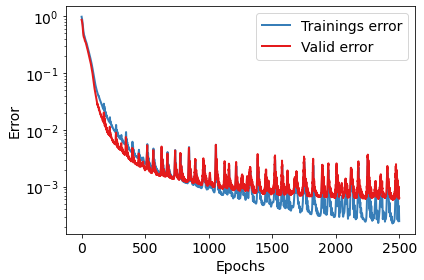

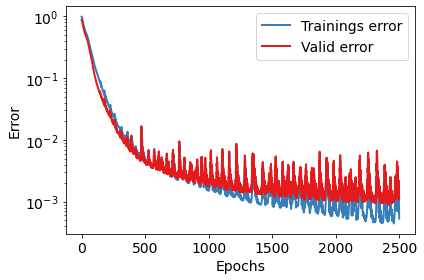

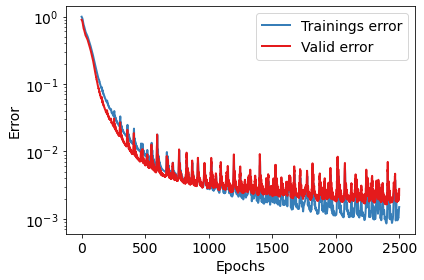

In [ ]:
for bn in [5,15,50]:
  seq_len = 11
  s = 5
  RNN(s,seq_len, bn)

  

sensor_number = 5 seq_len =  11
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
perfecttt
(1187, 55)
(1187, 5)
(389, 55)
(389, 5)
1187
389
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
Early stopping criteria fulfilled
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:234: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
(2099) BEST_Training Loss: 0.04071056 BEST_Valid Loss: 0.02688364 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  11
perfecttt
(1187, 55)
(1187, 15)
(389, 55)
(389, 15)
1187
389
Early stopping criteria fulfilled
(2099) BEST_Training Loss: 0.05210532 BEST_Valid Loss: 0.03818687 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  11
perfecttt
(1187, 55)
(1187, 25)
(389, 55)
(389, 25)
1187
389
Early stopping criteria fulfilled
(2099) BEST_Training Loss: 0.05548962 BEST_Valid Loss: 0.04181363 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  11
perfecttt
(1187, 55)
(1187, 50)
(389, 55)
(389, 50)
1187
389
Early stopping criteria fulfilled
(2099) BEST_Training Loss: 0.05995125 BEST_Valid Loss: 0.04595578 
overrrrrrrrrrrrrr

sensor_number = 5 seq_len =  11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


(1187, 55)
(1187, 5)
(389, 55)
(389, 5)
1187
389


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


(2499) BEST_Training Loss: 0.00023008 BEST_Valid Loss: 0.00059696 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  11
(1187, 55)
(1187, 15)
(389, 55)
(389, 15)
1187
389
(2499) BEST_Training Loss: 0.00054179 BEST_Valid Loss: 0.00088376 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  11
(1187, 55)
(1187, 50)
(389, 55)
(389, 50)
1187
389
(2499) BEST_Training Loss: 0.00089225 BEST_Valid Loss: 0.00164949 
overrrrrrrrrrrrrr


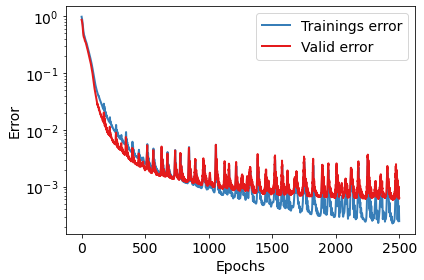

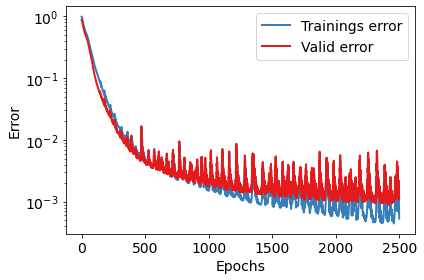

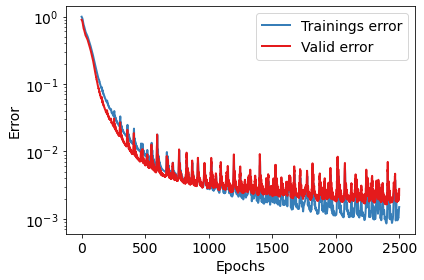

In [ ]:
for bn in [5,15,50]:
  seq_len = 11
  s = 5
  RNN(s,seq_len, bn)

  

sensor_number = 5 seq_len =  11
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
perfecttt
(1187, 55)
(1187, 5)
(389, 55)
(389, 5)
1187
389
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
Early stopping criteria fulfilled
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:234: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
(2099) BEST_Training Loss: 0.04071056 BEST_Valid Loss: 0.02688364 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  11
perfecttt
(1187, 55)
(1187, 15)
(389, 55)
(389, 15)
1187
389
Early stopping criteria fulfilled
(2099) BEST_Training Loss: 0.05210532 BEST_Valid Loss: 0.03818687 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  11
perfecttt
(1187, 55)
(1187, 25)
(389, 55)
(389, 25)
1187
389
Early stopping criteria fulfilled
(2099) BEST_Training Loss: 0.05548962 BEST_Valid Loss: 0.04181363 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  11
perfecttt
(1187, 55)
(1187, 50)
(389, 55)
(389, 50)
1187
389
Early stopping criteria fulfilled
(2099) BEST_Training Loss: 0.05995125 BEST_Valid Loss: 0.04595578 
overrrrrrrrrrrrrr

In [ ]:
import cmocean
import matplotlib.pyplot as pt

  trainAE, validAE, testAE, stats = autoencoder_train_data(drop=0, SNR=10)
  # trainAE_stan = trainAE
  trainAE_stan = (trainAE - stats[0, :])/stats[1, :]
  # print(np.mean(stats[1, :]),stats[1, :])

  nx=168
  ny=251
  ns = nx*ny
  x2 = np.arange(0, ny, 1)
  y2 = np.arange(0, nx, 1)
  mX, mY = np.meshgrid(x2, y2)
  x_cord = sensor_cord_data(sensor_num = 1)

  for i in [0,9,19,25,27,30]:
      t_predd = td[i,:].reshape((ny, nx))
      print('reconstruction',i)
      minmax = np.max(np.abs(t_predd)) * 0.65
      pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,5.29))
      im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
      pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
      pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
      pt.show()
  # for i in range(30,31):
      # td_n2[i,300:500] =-867.88
      # t_predd = td_n2[i].reshape((ny, nx))
      # t_predd = trainAE_stan[i].reshape((ny, nx))
      # minmax = np.log(np.max(np.abs(t_predd)) * .65)
      # t_preddp = np.log(trainAE_stan[i].reshape((ny, nx)))
      # t_preddn = np.log(-trainAE_stan[i].reshape((ny, nx)))
      # t_predd = t_preddp - t_preddn
      # minmax = np.log(np.max(np.abs(t_predd)) * .65)
      # print('reconstruction',i)
      # pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,5.29))
      # im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
      # # pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax)
      # pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
      # pt.show()
  # for i in range(77,78):
  #     t_predd = td[i,:].reshape((ny, nx))
  #     print('reconstruction',i)
  #     minmax = np.max(np.abs(t_predd)) * 0.65
  #     pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,5.29))
  #     im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
  #     pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax)
  #     #pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
  #     pt.show()

NameError: ignored

In [ ]:
rnn_train_data(2, 25, 5)

In [ ]:
import random

def autoencoder_train_data(**kwargs):
  if kwargs.get('drop',None):
    print('in autoencoder_train_data--noise data', 'SNR =',kwargs.get('SNR',10))
    
    td_n2 = np.zeros((300,42168))
    # td_n2 = awgn(td,10)
    for i in range(len(td)):
      td_n2[i,:] = awgn(td[i],kwargs.get('SNR',10))

    trainAE = td_n2[0:180,:]
    len_tr = len(trainAE)
    validAE = td_n2[180:240,:]
    testAE = td_n2[240:300,:]  

    nx=168
    ny=251
    ns = nx*ny
    x2 = np.arange(0, ny, 1)
    y2 = np.arange(0, nx, 1)
    mX, mY = np.meshgrid(x2, y2)

    # t_predd = testAE[39,:].reshape((ny, nx))
    # #print('reconstruction',i)
    # minmax = np.max(np.abs(t_predd)) * 0.65
    # pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    # im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    # # pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
    # # pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
    # im_name = 'im_true_39_noise_SNR{:d}.eps'.format(kwargs.get('SNR',10))
    # pt.savefig('../content/drive/My Drive/Colab Notebooks/results4/noise/{}'.format(im_name),format='eps')
    # print('SAVED -','../content/drive/My Drive/Colab Notebooks/results4/noise/{}'.format(im_name))
    # pt.show()


  else :
    print('in autoencoder_train_data-- no noise data')
    len_tr =180
    trainAE = td[0:len_tr,:]
    validAE = td[180:240,:]
    testAE = td[240:300,:]

  AE_mean = np.mean(td[0:len_tr,:], axis = 0)
  AE_std = np.std(td[0:len_tr,:], axis = 0) 
  stats = np.array([AE_mean, AE_std])
  stats[stats==0] = 0.0000001
  #pt.figure()
  #pt.imshow(trainAE.reshape(90, 384, 199)[2,:,:])
  #pt.show
  return trainAE, validAE, testAE, stats

def mn():
  m = 251
  n= 168
  return m,n

def sensor_cord_data(sensor_num):
  m,n = mn()
  theata = np.linspace(0, 2*np.pi, 300)
  x_cord = np.round(25 * np.cos(theata)) + 0
  y_cord = np.round(25 * np.sin(theata)) + 169/2
  cords = np.vstack((x_cord,y_cord)).T
  x_cord = np.unique(cords, axis=0)
  idx = x_cord[:,0] > 0
  x_cord = x_cord[idx,:]
  np.random.seed(3265)
  idx = np.random.choice(range(x_cord.shape[0]), sensor_num, False)
  #print(idx,'idx')
  x_cord = np.int64(x_cord[idx,:])
  return x_cord


In [ ]:
def ADS_train_data(sensor_num, bottle_neck, **kwargs):

  trainAE, validAE, testAE, stats = autoencoder_train_data(drop=kwargs.get('data_noise',None), SNR=kwargs.get('SNR',10))
  total = np.concatenate((trainAE, validAE, testAE), axis=0)
  train = sensorgcdatasetAE(total, stats)

  if kwargs.get('drop',None):
    pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_Ds_dropout_bn{:d}_weights'.format(bottle_neck);
  else:
    pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_Ds_bn{:d}_weights'.format(bottle_neck);
  
  train_data_gen = torch.utils.data.DataLoader(train, shuffle =False, batch_size=len(total[:,0]), num_workers=1)
  model = autoencoder(bottle_neck, drop=kwargs.get('drop',None)).cuda()
  model.load_state_dict(torch.load(pretrained_weightsAE))
  model.eval()
  for data in enumerate(train_data_gen):
    img = data[1]
    img = Variable(img).cuda()
    waste,gg = model(img)
    gtotal_out = gg.cpu().data.numpy()
    del(img,waste,gg)
    #print(gtotal_out,gtotal_out.shape)
    #print(gtotal_out.shape,'gtotal_out')

  del(model,total,train,data)
  len_train_and_valid = len(trainAE[:,0])+ len(validAE[:,0])
  len_train = len(trainAE[:,0])

  gstats = np.array([np.mean(gtotal_out[0:len(trainAE[:,0]),:],axis = 0),np.std(gtotal_out[0:len(trainAE[:,0]),:], axis = 0)])
  gtotal = (gtotal_out - np.mean(gtotal_out[0:len_train,:],axis = 0))/np.std(gtotal_out[0:len_train,:], axis = 0)
  #print(gtotal.shape)
  del(gtotal_out,pretrained_weightsAE)

  gtrain_out = gtotal[:len_train, :]
  #print(gtrain_out.shape)
  gvalid_out = gtotal[len_train: len_train_and_valid,:]
  #print(gvalid_out.shape)
  gtest = gtotal[len_train_and_valid : len(gtotal[:,0]),:]
  #print(gtest.shape)
  del(gtotal)
  ###################################################################
  #m, n = 251, 168
  #sensor_num = sensor_num

  #mask = np.zeros((m,n))
  #x_cord = sensor_cord_data(m,n,sensor_num)
  #gc_pred = gvalid_out * gstats[1, :] + gstats[0, :]

  #kAA =  251*168

  #pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnvalid_Ds_bn25_weights';

  #trainAE, validAE, testAE, statsAE = autoencoder_train_data()
  #del(trainAE,testAE)
  #statsAE = stats
  #model = autoencoder(bottle_neck)

  #model.load_state_dict(torch.load(pretrained_weightsAE))
  #del(pretrained_weightsAE)
  #model.eval()

  #testAA = sensorgcdatasetAA(gc_pred, validAE[:,:], statsAE)
  #train_data_genn = torch.utils.data.DataLoader(testAA, shuffle=False, batch_size=1, num_workers=1)

  #t_pred = np.zeros([399, kAA])
  #t_true = np.zeros([399, kAA])
  #print('jijijij')

  #for i, (gc_pre, t) in enumerate(train_data_genn):
  #    t_out_tensor = model(gc_pre[None, :])
  #    t_out = t_out_tensor.data.numpy()
  #    t_pred[i, :] = t_out
  #    t_true[i, :] = t
  #    #print(t_out_tensor.shape)
  #    if i == 60 or i ==340 or i ==380 or i ==200 or i==300:
  #      plot1image(t_out_tensor, t, statsAE, x_cord)
  #del(t_pred,t_true,testAA)
  ######################################################################

  trainAE_stan = (trainAE - stats[0, :])/stats[1, :]
  validAE_stan = (validAE - stats[0, :])/stats[1, :]
  testAE_stan = (testAE - stats[0, :])/stats[1, :]
  del(trainAE,validAE,testAE)

  n_snapshots_train, n_pix = trainAE_stan.shape
  n_snapshots_valid, _ = validAE_stan.shape
  n_snapshots_test, __ = testAE_stan.shape

  m, n = mn()
  sensor_num = sensor_num

  mask = np.zeros((m,n))
  x_cord = sensor_cord_data(sensor_num)
  mask[x_cord[:,0], x_cord[:,1]] = 1
  pivots = np.where(mask.reshape(-1) == 1)
  pivots = np.asarray(pivots).ravel()

  strain_in = trainAE_stan[:, pivots].reshape(n_snapshots_train, sensor_num)
  svalid_in = validAE_stan[:, pivots].reshape(n_snapshots_valid, sensor_num)
  stest_in = testAE_stan[:, pivots].reshape(n_snapshots_test, sensor_num)
  #print(svalid_in.shape)
  del(trainAE_stan,validAE_stan,testAE_stan)

  return gtrain_out, gvalid_out, strain_in, svalid_in, gtest, stest_in, gstats, x_cord

In [ ]:
if args.data_type == 'transient':
if args.operation_mode == 'online':
  def rnn_train_data(sensor_num, bottle_neck, seq_len, **kwargs):

    seq_impct = int((seq_len-1)/2)

    print('in rrntriandata',kwargs.get('drop',None))
    trainAE, validAE, testAE, stats = autoencoder_train_data(drop=kwargs.get('data_noise',None), SNR=kwargs.get('SNR',10))
    total = np.concatenate((trainAE, validAE, testAE), axis=0)
    print(trainAE.shape)
    print(validAE.shape)
    train = sensorgcdatasetAE(total, stats)
    if kwargs.get('drop',None):
      pretrained_weightsAE = osp.join(path2, 'nnv2_Ds33_dropout_bn{:d}_weights'.format(bottle_neck))
      # pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_Ds_dropout_bn{:d}_weights'.format(bottle_neck);
    else:
      pretrained_weightsAE = osp.join(path2, 'nnv2_Ds_bn{:d}_weights'.format(bottle_neck))
      # pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_Ds_bn{:d}_weights'.format(bottle_neck)
    
    train_data_gen = torch.utils.data.DataLoader(train, shuffle =False, batch_size=len(total[:,0]))#, num_workers=1)
    model = autoencoder(bottle_neck, drop=kwargs.get('drop',None)).cuda()
    model.load_state_dict(torch.load(pretrained_weightsAE))
    model.eval()
    for data in enumerate(train_data_gen):
      img = data[1]
      img = Variable(img).cuda()
      waste,gg = model(img)
      del(waste,img)
      gtotal_out = gg.cpu().data.numpy()
      del(gg)
      #print(gtotal_out,gtotal_out.shape)
      #print(gtotal_out.shape,'gtotal_out')

    len_train_and_valid = len(trainAE[:,0])+ len(validAE[:,0])
    len_train = len(trainAE[:,0])

    gtotal = (gtotal_out - np.mean(gtotal_out[0:len_train,:],axis = 0))/np.std(gtotal_out[0:len_train,:], axis = 0)
    #print(gtotal.shape)
    #ii = (gtotal_out[4,:] - np.mean(gtotal_out,axis = 0))/np.std(gtotal_out, axis = 0)
    #if ii.all() == gtotal[4,:].all():
      #print('perfect')

    # gtrain_out = gtotal[seq_impct:len_train - seq_impct, :] 
    gtrain_out = gtotal[seq_impct:len_train, :] 
    #print(gtrain_out.shape)
    ######################################### Deleting rows in between junction of 180 190 and 200
    # del_row = np.array([])
    # for e in range(int(len_train/3)- seq_impct, int(len_train/3)+ seq_impct): # if seq_impct=2 (397. 398. 399. 400.)
    #   del_row = np.append(del_row, [e], axis=0)    #len_train/3 = 399
    # for e in range(int(len_train*2/3)- seq_impct , int(len_train*2/3)+ seq_impct):  #if seq_impct=2 (796. 797. 798. 799.)
    #   del_row = np.append(del_row, [e], axis=0)
    # np.delete(gtrain_out, del_row, 0)
    # print(del_row)
    ##########

    gvalid_out = gtotal[len_train+seq_impct: len_train_and_valid,:]
    #print('len_train+seq_impct = ', len_train+seq_impct, 'len_train_and_valid-seq_impct = ', len_train_and_valid-seq_impct, 'len_train_and_valid+seq_impct = ', len_train_and_valid+seq_impct, 'total[:,0])-seq_impct =', len(total[:,0])-seq_impct)
    gtest = gtotal[len_train_and_valid+seq_impct : len(total[:,0]),:]
    #print(gtest.shape)
    del(total,train,gtotal)
    #########################################  Standardizing trainAE
    trainAE_stan = (trainAE - stats[0, :])/stats[1, :]
    validAE_stan = (validAE - stats[0, :])/stats[1, :]
    testAE_stan = (testAE - stats[0, :])/stats[1, :]
    #########
    gstats = np.array([np.mean(gtotal_out[0:len(trainAE[:,0]),:],axis = 0),np.std(gtotal_out[0:len(trainAE[:,0]),:], axis = 0)])

    del(trainAE,validAE,testAE)

    n_snapshots_train, n_pix = trainAE_stan.shape
    #print('n_snapshots_train = ',n_snapshots_train )
    n_snapshots_valid, _ = validAE_stan.shape
    n_snapshots_test, __ = testAE_stan.shape
    m, n = 251, 168
    sensor_num = sensor_num

    mask = np.zeros((m,n))
    x_cord = sensor_cord_data(sensor_num)

    #print(x_cord[:,0])
    #print(x_cord[:,1])

    mask[x_cord[:,0], x_cord[:,1]] = 1
    pivots = np.where(mask.reshape(-1) == 1)
    pivots = np.asarray(pivots).ravel()

    strain_in = trainAE_stan[:, pivots].reshape(n_snapshots_train, sensor_num)
    svalid_in = validAE_stan[:, pivots].reshape(n_snapshots_valid, sensor_num)
    stest_in = testAE_stan[:, pivots].reshape(n_snapshots_test, sensor_num)
    # print('strain_in =',strain_in.shape)
    # print('svalid_in  = ',svalid_in.shape,'ok')
    # print('stest_in = ',stest_in.shape)
    # strain_in_stacked = np.zeros((n_snapshots_train-seq_impct,seq_len*sensor_num))
    # svalid_in_stacked = np.zeros((n_snapshots_valid-seq_impct,seq_len*sensor_num))
    # stest_in_stacked = np.zeros((n_snapshots_test-seq_impct,seq_len*sensor_num))
    strain_in_stacked = np.zeros((n_snapshots_train-seq_impct,(seq_impct+1)*sensor_num))
    svalid_in_stacked = np.zeros((n_snapshots_valid-seq_impct,(seq_impct+1)*sensor_num))
    stest_in_stacked = np.zeros((n_snapshots_test-seq_impct,(seq_impct+1)*sensor_num))

    for i in range(0,n_snapshots_train-seq_impct) :
      if seq_len == 3 :
        strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:]),axis = None)
      elif seq_len == 5:
        strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:]),axis = None)
        #print(strain_in.shape,'okok')
      elif seq_len == 7:
        strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:]),axis = None)
      elif seq_len == 9:
        strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:]),axis = None)  
      elif seq_len == 11:
        strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:]),axis = None)  
      elif seq_len == 15:
        strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:]),axis = None)  

    #np.delete(strain_in_stacked, del_row-1, 0)
    #print(strain_in_stacked)
    for i in range(0,n_snapshots_valid-seq_impct) :
      if seq_len == 3:
        svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:]),axis = None)
      elif seq_len == 5:
        svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:], svalid_in[i+2,:]),axis = None)
      elif seq_len == 7:
        svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:], svalid_in[i+2,:], svalid_in[i+3,:]),axis = None)
      elif seq_len == 9:
        svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:]),axis = None)  
      elif seq_len == 11:
        svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:],svalid_in[i+5,:]),axis = None)  
      elif seq_len == 15:
        svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:],svalid_in[i+5,:],svalid_in[i+6,:]),axis = None)  

    for i in range(0,n_snapshots_test-seq_impct) :
      if seq_len == 3:
        stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:]),axis = None)
      elif seq_len == 5:
        stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:]),axis = None)
      elif seq_len == 7:
        stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:], stest_in[i+3,:]),axis = None)
      elif seq_len == 9:
        stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:]),axis = None)  
      elif seq_len == 11:
        stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:],stest_in[i+5,:]),axis = None)  
      elif seq_len == 15:
        stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:],stest_in[i+5,:],stest_in[i+6,:]),axis = None)  

    # #print(svalid_in.shape)
    # if strain_in_stacked[177,2 ] == strain_in[179,0] and strain_in_stacked[1,2 ] == strain_in[3,0] and stest_in_stacked[57,2 ] == stest_in[59,0] and stest_in_stacked[1,2 ] == stest_in[3,0] :
    #   print('perfecttt')

    # print('strain_in_stacked[0] = ',strain_in_stacked[0])
    # print('gtrain_out[0]  =', gtrain_out[0])
    # print('svalid_in_stacked[0] = ',svalid_in_stacked[0])
    # print('gvalid_out[0]  =', gvalid_out[0])
    # print('stest_in_stacked[0] = ',stest_in_stacked[0])
    # print('gtest[0]  =', gtest[0])

    return gtrain_out, gvalid_out, strain_in_stacked, svalid_in_stacked, gtest, stest_in_stacked, gstats, x_cord


In [ ]:
if args.operation_mode == 'offline':
  def rnn_train_data(sensor_num, bottle_neck, seq_len, **kwargs):

    seq_impct = int((seq_len-1)/2)

    print('in rrntriandata',kwargs.get('drop',None))
    trainAE, validAE, testAE, stats = autoencoder_train_data(drop=kwargs.get('data_noise',None), SNR=kwargs.get('SNR',10))
    total = np.concatenate((trainAE, validAE, testAE), axis=0)
    print(trainAE.shape)
    print(validAE.shape)
    train = sensorgcdatasetAE(total, stats)
    if kwargs.get('drop',None):
      pretrained_weightsAE = osp.join(path2, 'nnv2_Ds_dropout_bn{:d}_weights'.format(bottle_neck))
      # pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_Ds_dropout_bn{:d}_weights'.format(bottle_neck);
    else:
      pretrained_weightsAE = osp.join(path2, 'nnv2_Ds_bn{:d}_weights'.format(bottle_neck))
      # pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_Ds_bn{:d}_weights'.format(bottle_neck)
    
    train_data_gen = torch.utils.data.DataLoader(train, shuffle =False, batch_size=len(total[:,0]))#, num_workers=1)
    model = autoencoder(bottle_neck, drop=kwargs.get('drop',None)).cuda()
    model.load_state_dict(torch.load(pretrained_weightsAE))
    model.eval()
    for data in enumerate(train_data_gen):
      img = data[1]
      img = Variable(img).cuda()
      waste,gg = model(img)
      del(waste,img)
      gtotal_out = gg.cpu().data.numpy()
      del(gg)
      #print(gtotal_out,gtotal_out.shape)
      #print(gtotal_out.shape,'gtotal_out')

    len_train_and_valid = len(trainAE[:,0])+ len(validAE[:,0])
    len_train = len(trainAE[:,0])

    gtotal = (gtotal_out - np.mean(gtotal_out[0:len_train,:],axis = 0))/np.std(gtotal_out[0:len_train,:], axis = 0)
    #print(gtotal.shape)
    #ii = (gtotal_out[4,:] - np.mean(gtotal_out,axis = 0))/np.std(gtotal_out, axis = 0)
    #if ii.all() == gtotal[4,:].all():
      #print('perfect')

    # gtrain_out = gtotal[seq_impct:len_train - seq_impct, :] 
    gtrain_out = gtotal[seq_impct:len_train - seq_impct, :] 
    #print(gtrain_out.shape)
    ######################################### Deleting rows in between junction of 180 190 and 200
    # del_row = np.array([])
    # for e in range(int(len_train/3)- seq_impct, int(len_train/3)+ seq_impct): # if seq_impct=2 (397. 398. 399. 400.)
    #   del_row = np.append(del_row, [e], axis=0)    #len_train/3 = 399
    # for e in range(int(len_train*2/3)- seq_impct , int(len_train*2/3)+ seq_impct):  #if seq_impct=2 (796. 797. 798. 799.)
    #   del_row = np.append(del_row, [e], axis=0)
    # np.delete(gtrain_out, del_row, 0)
    # print(del_row)
    ##########

    gvalid_out = gtotal[len_train+seq_impct: len_train_and_valid - seq_impct,:]
    #print('len_train+seq_impct = ', len_train+seq_impct, 'len_train_and_valid-seq_impct = ', len_train_and_valid-seq_impct, 'len_train_and_valid+seq_impct = ', len_train_and_valid+seq_impct, 'total[:,0])-seq_impct =', len(total[:,0])-seq_impct)
    gtest = gtotal[len_train_and_valid+seq_impct : len(total[:,0] - seq_impct),:]
    #print(gtest.shape)
    del(total,train,gtotal)
    #########################################  Standardizing trainAE
    trainAE_stan = (trainAE - stats[0, :])/stats[1, :]
    validAE_stan = (validAE - stats[0, :])/stats[1, :]
    testAE_stan = (testAE - stats[0, :])/stats[1, :]
    #########
    gstats = np.array([np.mean(gtotal_out[0:len(trainAE[:,0]),:],axis = 0),np.std(gtotal_out[0:len(trainAE[:,0]),:], axis = 0)])

    del(trainAE,validAE,testAE)

    n_snapshots_train, n_pix = trainAE_stan.shape
    #print('n_snapshots_train = ',n_snapshots_train )
    n_snapshots_valid, _ = validAE_stan.shape
    n_snapshots_test, __ = testAE_stan.shape
    m, n = mn()# 251, 168
    sensor_num = sensor_num

    mask = np.zeros((m,n))
    x_cord = sensor_cord_data(sensor_num)

    #print(x_cord[:,0])
    #print(x_cord[:,1])

    mask[x_cord[:,0], x_cord[:,1]] = 1
    pivots = np.where(mask.reshape(-1) == 1)
    pivots = np.asarray(pivots).ravel()

    strain_in = trainAE_stan[:, pivots].reshape(n_snapshots_train, sensor_num)
    svalid_in = validAE_stan[:, pivots].reshape(n_snapshots_valid, sensor_num)
    stest_in = testAE_stan[:, pivots].reshape(n_snapshots_test, sensor_num)
    # print('strain_in =',strain_in.shape)
    # print('svalid_in  = ',svalid_in.shape,'ok')
    # print('stest_in = ',stest_in.shape)
    strain_in_stacked = np.zeros((n_snapshots_train-2*seq_impct,seq_len*sensor_num))
    svalid_in_stacked = np.zeros((n_snapshots_valid-2*seq_impct,seq_len*sensor_num))
    stest_in_stacked = np.zeros((n_snapshots_test-2*seq_impct,seq_len*sensor_num))

    for i in range(0,n_snapshots_train-2*seq_impct) :
      if seq_len == 3 :
        strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:]),axis = None)
      elif seq_len == 5:
        strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:], strain_in[i+3,:], strain_in[i+4,:]),axis = None)
        #print(strain_in.shape,'okok')
      elif seq_len == 7:
        strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:]),axis = None)
      elif seq_len == 9:
        strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:], strain_in[i+7,:],strain_in[i+8,:]),axis = None)  
      elif seq_len == 11:
        strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:], strain_in[i+7,:],strain_in[i+8,:], strain_in[i+9,:], strain_in[i+10,:]),axis = None)  
      elif seq_len == 15:
        strain_in_stacked[i,:] = np.concatenate((strain_in[i,:], strain_in[i+1,:], strain_in[i+2,:],strain_in[i+3,:],strain_in[i+4,:],strain_in[i+5,:],strain_in[i+6,:], strain_in[i+7,:],strain_in[i+8,:], strain_in[i+9,:], strain_in[i+10,:], strain_in[i+11,:], strain_in[i+12,:], strain_in[i+13,:], strain_in[i+14,:]),axis = None)  

    #np.delete(strain_in_stacked, del_row-1, 0)
    #print(strain_in_stacked)
    for i in range(0,n_snapshots_valid-2*seq_impct) :
      if seq_len == 3:
        svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:], svalid_in[i+2,:]),axis = None)
      elif seq_len == 5:
        svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:], svalid_in[i+2,:], svalid_in[i+3,:], svalid_in[i+4,:]),axis = None)
      elif seq_len == 7:
        svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], svalid_in[i+1,:], svalid_in[i+2,:], svalid_in[i+3,:], svalid_in[i+4,:], svalid_in[i+5,:], svalid_in[i+6,:]),axis = None)
      elif seq_len == 9:
        svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:],svalid_in[i+5,:],svalid_in[i+6,:], svalid_in[i+7,:],svalid_in[i+8,:]),axis = None)  
      elif seq_len == 11:
        svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:],svalid_in[i+5,:],svalid_in[i+6,:], svalid_in[i+7,:],svalid_in[i+8,:], svalid_in[i+9,:], svalid_in[i+10,:]),axis = None)  
      elif seq_len == 15:
        svalid_in_stacked[i,:] = np.concatenate((svalid_in[i,:], strain_in[i+1,:], svalid_in[i+2,:],svalid_in[i+3,:],svalid_in[i+4,:],svalid_in[i+5,:],svalid_in[i+6,:], svalid_in[i+7,:],svalid_in[i+8,:], svalid_in[i+9,:], svalid_in[i+10,:], svalid_in[i+11,:], svalid_in[i+12,:],  svalid_in[i+13,:], svalid_in[i+14,:]),axis = None)  

    for i in range(0,n_snapshots_test-2*seq_impct) :
      if seq_len == 3:
        stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:]),axis = None)
      elif seq_len == 5:
        stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:], stest_in[i+3,:], stest_in[i+4,:]),axis = None)
      elif seq_len == 7:
        stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:], stest_in[i+3,:], stest_in[i+4,:], stest_in[i+5,:], stest_in[i+6,:]),axis = None)
      elif seq_len == 9:
        stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:],stest_in[i+5,:],stest_in[i+6,:], stest_in[i+7,:],stest_in[i+8,:]),axis = None)  
      elif seq_len == 11:
        stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:],stest_in[i+5,:],stest_in[i+6,:], stest_in[i+7,:],stest_in[i+8,:], stest_in[i+9,:], stest_in[i+10,:]),axis = None)  
      elif seq_len == 15:
        stest_in_stacked[i,:] = np.concatenate((stest_in[i,:], stest_in[i+1,:], stest_in[i+2,:],stest_in[i+3,:],stest_in[i+4,:],stest_in[i+5,:],stest_in[i+6,:], stest_in[i+7,:],stest_in[i+8,:], stest_in[i+9,:], stest_in[i+10,:], stest_in[i+11,:], stest_in[i+12,:], stest_in[i+13,:], stest_in[i+14,:]),axis = None)  

    # #print(svalid_in.shape)
    # if strain_in_stacked[177,2 ] == strain_in[179,0] and strain_in_stacked[1,2 ] == strain_in[3,0] and stest_in_stacked[57,2 ] == stest_in[59,0] and stest_in_stacked[1,2 ] == stest_in[3,0] :
    #   print('perfecttt')

    # print('strain_in_stacked[0] = ',strain_in_stacked[0])
    # print('gtrain_out[0]  =', gtrain_out[0])
    # print('svalid_in_stacked[0] = ',svalid_in_stacked[0])
    # print('gvalid_out[0]  =', gvalid_out[0])
    # print('stest_in_stacked[0] = ',stest_in_stacked[0])
    # print('gtest[0]  =', gtest[0])

    return gtrain_out, gvalid_out, strain_in_stacked, svalid_in_stacked, gtest, stest_in_stacked, gstats, x_cord


In [ ]:
def PDS_train_data(sensor_num, bottle_neck, **kwargs):
  
  trainAE, validAE, testAE, stats = autoencoder_train_data(drop=kwargs.get('data_noise',None), SNR=kwargs.get('SNR',10))
  #total = np.concatenate((trainAE, validAE), axis=0)
  mean = np.mean(trainAE, axis = 0)
  X = trainAE - mean
  X = X.transpose()
  #phi = POD(X)
  phi, s, V = np.linalg.svd(X,full_matrices=False)
  del(s,V)
  phi = phi[:,0:bottle_neck]

  gtrain_transpose = np.dot(phi.transpose(),X)
  del(X)
  gtotal_out = gtrain_transpose.transpose()
  del(gtrain_transpose)
  gtrain_out = (gtotal_out - np.mean(gtotal_out,axis = 0))/np.std(gtotal_out, axis = 0)

  XX = validAE - np.mean(trainAE, axis = 0)
  XX = XX.transpose()
  gvalid_transpose = np.dot(phi.transpose(),XX)
  del(XX)
  gvalid_out = gvalid_transpose.transpose()
  del(gvalid_transpose)
  gvalid_out = (gvalid_out - np.mean(gtotal_out,axis = 0))/np.std(gtotal_out, axis = 0)

  XXX = testAE - np.mean(trainAE, axis = 0)
  XXX = XXX.transpose()
  gtest_transpose = np.dot(phi.transpose(),XXX)
  del(XXX)
  gtest_out = gtest_transpose.transpose()
  del(gtest_transpose)
  gtest_out = (gtest_out - np.mean(gtotal_out,axis = 0))/np.std(gtotal_out, axis = 0)
  
  gstats = np.array([np.mean(gtotal_out[:,:], axis = 0),np.std(gtotal_out[:,:], axis = 0)])
  del(gtotal_out)


  trainAE_stan = (trainAE - stats[0, :])/stats[1, :]
  del(trainAE)
  validAE_stan = (validAE - stats[0, :])/stats[1, :]
  testAE_stan = (testAE - stats[0, :])/stats[1, :]
 
  del(validAE,testAE)


  n_snapshots_train, n_pix = trainAE_stan.shape
  n_snapshots_valid, _ = validAE_stan.shape
  n_snapshots_test, __ = testAE_stan.shape

  m, n = 251, 168
  sensor_num = sensor_num
  mask = np.zeros((m,n))
  x_cord =sensor_cord_data(sensor_num) 
  mask[x_cord[:,0], x_cord[:,1]] = 1
  pivots = np.where(mask.reshape(-1) == 1)
  pivots = np.asarray(pivots).ravel()


  strain_in = trainAE_stan[:, pivots].reshape(n_snapshots_train, sensor_num)
  #print(strain_in)
  svalid_in = validAE_stan[:, pivots].reshape(n_snapshots_valid, sensor_num)
  stest_in = testAE_stan[:, pivots].reshape(n_snapshots_test, sensor_num)
  #print(svalid_in.shape)

  gc_pod = gtest_out*gstats[1, :] + gstats[0, :]
  t_pred = gc_pod.dot(phi.T) + mean#np.mean(trainAE[:,:].transpose(), axis = 1)

  nx=n
  ny=m
  x2 = np.arange(0, ny, 1)
  y2 = np.arange(0, nx, 1)
  mX, mY = np.meshgrid(x2, y2)
   
  #for i in range(310,355):
    #print(i)
    #t_predd = t_pred[i,:].reshape((ny, nx))
    #minmax = np.max(np.abs(t_predd)) * 0.65
    #pt.figure(facecolor="white",  edgecolor='k', figsize=(6,3))
    #im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    #pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax, vmax=minmax)
    #pt.show()

  del(trainAE_stan,validAE_stan,testAE_stan)#,t_pred)
  return gtrain_out, gvalid_out, strain_in, svalid_in, gtest_out, stest_in, gstats, x_cord,phi,mean   



In [ ]:
def plot_graph(rerror_train, rerror_test):
    fig = pt.figure()
    pt.plot(rerror_train, lw=2, label='Trainings error', color='#377eb8',)  
    pt.plot(rerror_test, lw=2, label='Valid error', color='#e41a1c',)            
    pt.tick_params(axis='x', labelsize=14) 
    pt.tick_params(axis='y', labelsize=14) 
    pt.locator_params(axis='y', nbins=10)
    pt.locator_params(axis='x', nbins=10)
    
    pt.ylabel('Error', fontsize=14)
    pt.xlabel('Epochs', fontsize=14)
    pt.grid(False)
    pt.yscale("log")
    pt.legend(fontsize=14)
    fig.tight_layout()

In [ ]:
jk = np.array([8,9])
kl = np.array([1])
jk = np.delete(jk, kl, 0)
print(jk)

[8]


In [ ]:
import numpy as np
import matplotlib.pyplot as pt
import random

a = np.array([[1,2,3],[4,5,7]])

vd = []  
res = []  
random.seed(36123)
res = random.sample(range(41), 15)
for j in range(15):
  vd.append(res[j]*3)
  vd.append(vd[j*3]+1)
  vd.append(vd[j*3]+2)
print(vd)

#b = np.array([[2,3],[7,6]])
#c = np.array([a,b])
#print(c)

#trainAE, validAE, waste, stats = autoencoder_train_data()
#print(trainAE,trainAE.shape)
#print(waste,waste.shape)
#print(stats,stats.shape)
#trainAE_stan = (trainAE - stats[0, :])/stats[1, :]
#ii = (trainAE[4,:] - stats[0, :])/stats[1, :]
#if ii.all() == trainAE_stan[4,:].all():
  #print('perfect')
#print(trainAE,'kokok')
#print(trainAE_stan,'kooko')
#cc = np.concatenate((a, b), axis=1)
#print(cc)
#gtrain_out, gvalid_out, X, Y, gtest, Z, gstats = ds_train_data(15)
#print(Y.shape)
#gtrain_out, gvalid_out, X, Y, gtest, Z, gstats = ds_train_data(5)
#print(X)

m, n = 251, 168
sensor_num = 5
xk =sensor_cord_data(m,n,sensor_num)
print(xk)

import numpy as np
arr = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12]])
del_rows = np.array([0,2])
np.delete(arr, del_rows, 0)

In [ ]:
sensor_number = 1 seq_len =  3
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
(1195, 3)
(1195, 25)
(397, 3)
(397, 25)
1195
397
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
(2499) BEST_Training Loss: 0.11093688 BEST_Valid Loss: 0.10017747 
overrrrrrrrrrrrrr
sensor_number = 1 seq_len =  7
(1191, 7)
(1191, 25)
(393, 7)
(393, 25)
1191
393
(2499) BEST_Training Loss: 0.06197061 BEST_Valid Loss: 0.06045400 
overrrrrrrrrrrrrr
sensor_number = 1 seq_len =  11
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
(1187, 11)
(1187, 25)
(389, 11)
(389, 25)
1187
389
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
(2499) BEST_Training Loss: 0.04347700 BEST_Valid Loss: 0.04832747 
overrrrrrrrrrrrrr
sensor_number = 1 seq_len =  15
(1183, 15)
(1183, 25)
(385, 15)
(385, 25)
1183
385
Early stopping criteria fulfilled
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:234: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
(2499) BEST_Training Loss: 0.03181018 BEST_Valid Loss: 0.03142554

sensor_number = 2 seq_len =  3
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
(1195, 6)
(1195, 25)
(397, 6)
(397, 25)
1195
397
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
Early stopping criteria fulfilled
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:234: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1264.)
  self.dropout, self.training, self.bidirectional, self.batch_first)
(2499) BEST_Training Loss: 0.04273108 BEST_Valid Loss: 0.04136109 
overrrrrrrrrrrrrr
sensor_number = 2 seq_len =  7
(1191, 14)
(1191, 25)
(393, 14)
(393, 25)
1191
393
(2499) BEST_Training Loss: 0.00962668 BEST_Valid Loss: 0.01565781 
overrrrrrrrrrrrrr
sensor_number = 2 seq_len =  11
(1187, 22)
(1187, 25)
(389, 22)
(389, 25)
1187
389
Early stopping criteria fulfilled
(2499) BEST_Training Loss: 0.01025694 BEST_Valid Loss: 0.01151269 
overrrrrrrrrrrrrr
sensor_number = 2 seq_len =  15
(1183, 30)
(1183, 25)
(385, 30)
(385, 25)
1183
385
(2499) BEST_Training Loss: 0.00737577 BEST_Valid Loss: 0.00938867 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  3
(1195, 15)
(1195, 25)
(397, 15)
(397, 25)
1195
397
(2499) BEST_Training Loss: 0.00241249 BEST_Valid Loss: 0.00247955 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  7
(1191, 35)
(1191, 25)
(393, 35)
(393, 25)
1191
393
(2499) BEST_Training Loss: 0.00112816 BEST_Valid Loss: 0.00128531 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  11
(1187, 55)
(1187, 25)
(389, 55)
(389, 25)
1187
389
(2499) BEST_Training Loss: 0.00145559 BEST_Valid Loss: 0.00197667 
overrrrrrrrrrrrrr
sensor_number = 5 seq_len =  15
(1183, 75)
(1183, 25)
(385, 75)
(385, 25)
1183
385
(2499) BEST_Training Loss: 0.00093256 BEST_Valid Loss: 0.00134677 
overrrrrrrrrrrrrr
sensor_number = 10 seq_len =  3
(1195, 30)
(1195, 25)
(397, 30)
(397, 25)
1195
397
(2499) BEST_Training Loss: 0.00120170 BEST_Valid Loss: 0.00150975 
overrrrrrrrrrrrrr
sensor_number = 10 seq_len =  7
(1191, 70)
(1191, 25)
(393, 70)
(393, 25)
1191
393
(2499) BEST_Training Loss: 0.00075304 BEST_Valid Loss: 0.00100243 
overrrrrrrrrrrrrr
sensor_number = 10 seq_len =  11
(1187, 110)
(1187, 25)
(389, 110)
(389, 25)
1187
389
(2499) BEST_Training Loss: 0.00057060 BEST_Valid Loss: 0.00138327 
overrrrrrrrrrrrrr
sensor_number = 10 seq_len =  15
(1183, 150)
(1183, 25)
(385, 150)
(385, 25)
1183
385

# Final results

## FR_ARE

In [ ]:
def FR_rnn(sensor_number,seq_len, bottle_neck ):
  pretrained_weightsRNN = '../content/drive/My Drive/Colab Notebooks/RNNv3_s{:d}_sq{:d}_bn{:d}_D3_weights'.format(sensor_number,seq_len, bottle_neck);

  sensor_number = sensor_number
  hidden_size = 50
  layers = 1
  seq_impct = int((seq_len-1)/2)

  gtrain_out, gvalid_out, strain_in, svalid_in, gtest_stan, stest_in_stacked, gstats, x_cord  = rnn_train_data(sensor_number, bottle_neck, seq_len)
  del(gtrain_out, gvalid_out, strain_in, svalid_in)
  # Setting up the neural network
  model = RNNv3network(hidden_size, sensor_number, bottle_neck, layers, seq_len).cuda()

  # Load saved neural network weights
  model.load_state_dict(torch.load(pretrained_weightsRNN))
  model.eval()

  # Load snapshots of sensor data and gc for testing
  test = sensorgcdatasetRNN(stest_in_stacked, gtest_stan)
  #test = sensorgcdatasetRNN(svalid_in, gvalid_out)
  test_data_genn = torch.utils.data.DataLoader(test, shuffle=False, batch_size=1, num_workers=1)

  # predicting generalized coordinates from sensor data
  #err = []
  gc_pred = np.zeros([len(test), bottle_neck])
  for i, (sensor, gc) in enumerate(test):
      y = torch.zeros(seq_len,1, sensor_number)
      for j in range(0, seq_len):
          y[j,0, :] = sensor[sensor_number*j : (sensor_number*j + sensor_number)]
      gc_out = model(y.cuda()).cpu().data.numpy()
      gc_pred[i, :] = gc_out
      #del(gc_out, y, sensor, gc)
      #err.append(np.linalg.norm(gc.numpy() - gc_pred[i, :]) ** 2 / gc_pred[i, :].size)  # /np.linalg.norm(gc) )
      #print(i)
  del(stest_in_stacked, gtest_stan)
  #print(gc_pred)
  #acc_avg = np.mean(err)
  gc_pred = gc_pred * gstats[1, :] + gstats[0, :]

  pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_D3_bn{:d}_weights'.format(bottle_neck);

  trainAE, validAE, testAE, statsAE = autoencoder_train_data()
  del(trainAE,validAE)

  model = autoencoder(bottle_neck).cuda()

  model.load_state_dict(torch.load(pretrained_weightsAE))
  model.eval()

  testAA = sensorgcdatasetAA(gc_pred, testAE[seq_impct:399-seq_impct,:], statsAE)
  train_data_genn = torch.utils.data.DataLoader(testAA, shuffle=False, batch_size=1, num_workers=1)

  #err = []
  t_pred = np.zeros([len(test), len(testAE[0,:]) ])
  t_true = np.zeros([len(test), len(testAE[0,:]) ])
  #print('jijijij')
  for i, (gc_pre, t) in enumerate(train_data_genn):
      t_out_tensor = model(gc_pre[None, :].cuda())
      t_out = t_out_tensor.cpu().data.numpy()
      t_pred[i, :] = t_out
      t_true[i, :] = t
      #err.append(np.linalg.norm(t.numpy() - t_pred[i, :]) ** 2 / t_pred[i, :].size)
      #print(t_out_tensor.shape)
      if i == 260 or i ==340 or i ==380 or i ==200 or i==300:
         nothing = 0
         #plot1image(t_out_tensor[0], t, statsAE, x_cord)

  #error = np.linalg.norm(t_true - t_pred) / np.linalg.norm(t_true)
  #print(error)

  t_pred = t_pred * statsAE[1, :] + statsAE[0, :]
  t_true = t_true * statsAE[1, :] + statsAE[0, :]

  #acc_avg = np.mean(err)
  #print(acc_avg)
  #print(min(err))

  #error = np.linalg.norm(t_true - t_pred) / np.linalg.norm(t_true)
  #print(error)

  Ferr = []
  for i in range(200,399-seq_impct*2):
      Ferr.append(np.linalg.norm(t_true[i,:] - t_pred[i,:]) / np.linalg.norm(t_true[i,:]))
  del(t_true,t_pred)
  Ferr_avg = np.mean(Ferr)
  #Terr_max = max(Terr)
  print("Error =",seq_len, Ferr_avg)
  #print("Max error =", Terr_max)
####################################

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s1_sq3_i270_D3


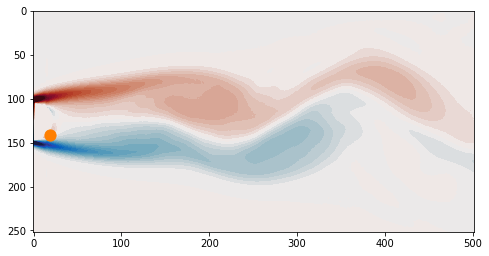

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s1_sq3_i270_D3


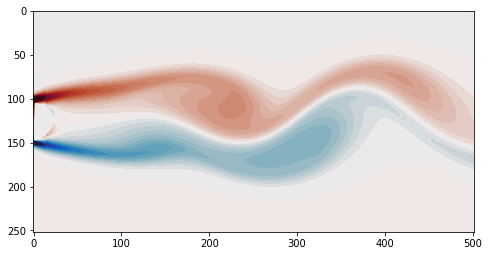

reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s1_sq3_i330_D3


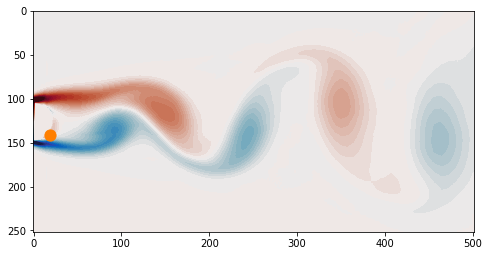

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s1_sq3_i330_D3


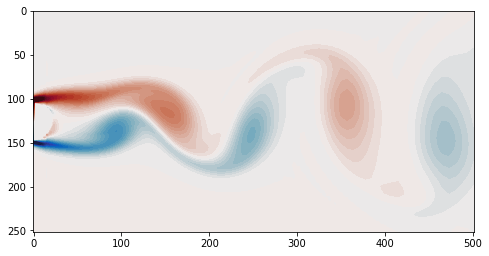

reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s1_sq3_i380_D3


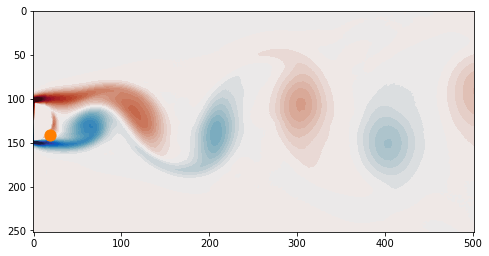

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s1_sq3_i380_D3


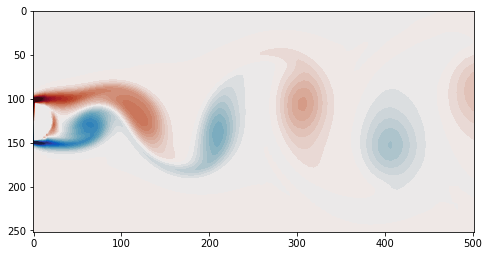

Error = 3 0.16389898894259666
reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s1_sq7_i270_D3


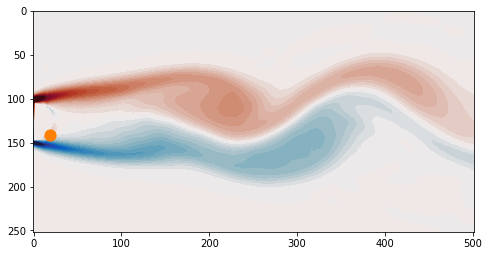

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s1_sq7_i270_D3


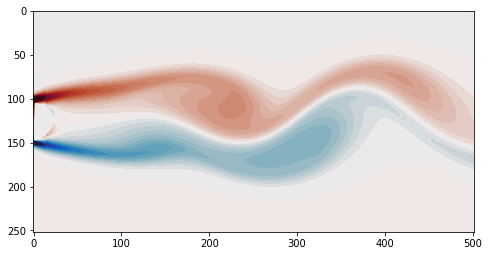

reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s1_sq7_i330_D3


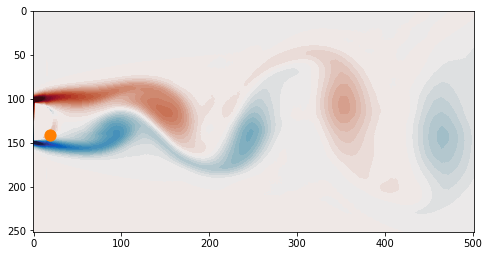

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s1_sq7_i330_D3


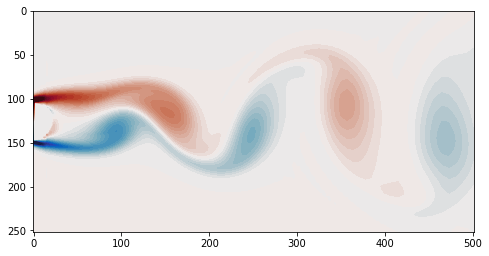

reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s1_sq7_i380_D3


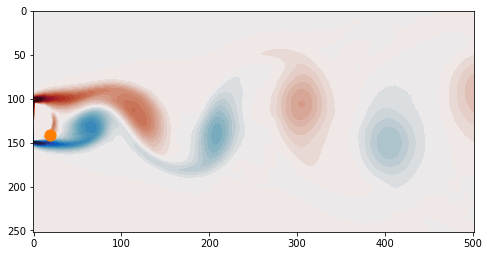

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s1_sq7_i380_D3


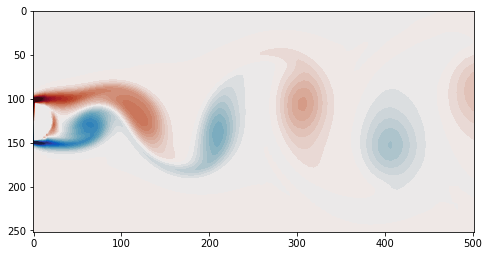

Error = 7 0.1383429957601497
reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s1_sq11_i270_D3


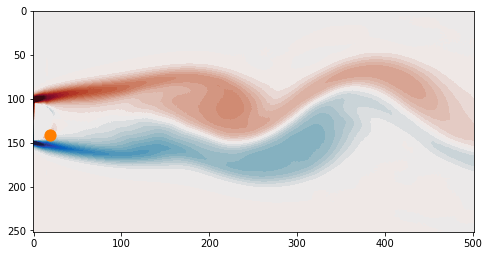

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s1_sq11_i270_D3


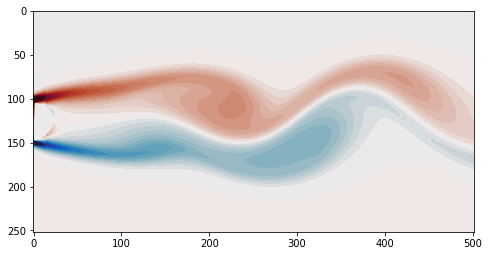

reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s1_sq11_i330_D3


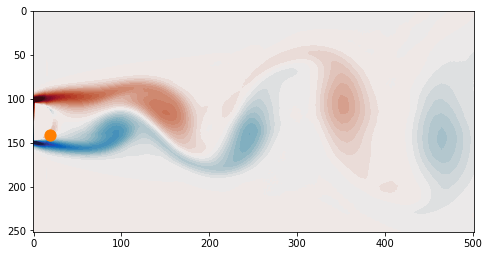

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s1_sq11_i330_D3


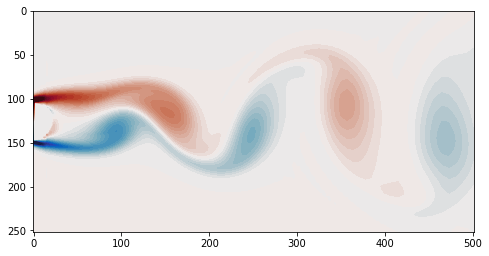

reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s1_sq11_i380_D3


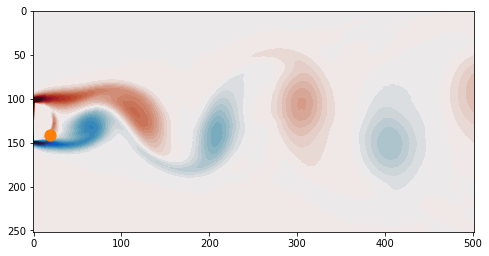

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s1_sq11_i380_D3


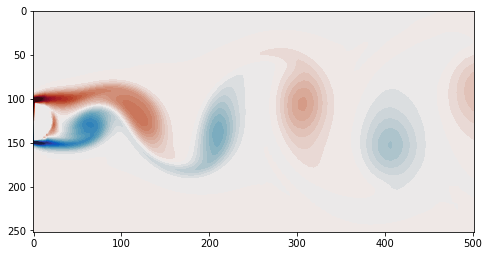

Error = 11 0.13111698555535348
reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s1_sq15_i270_D3


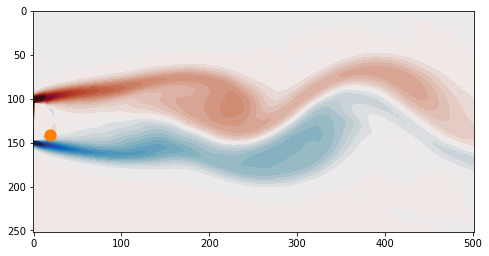

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s1_sq15_i270_D3


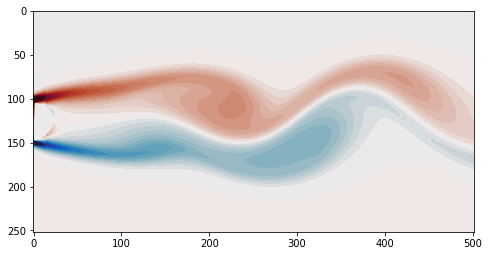

reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s1_sq15_i330_D3


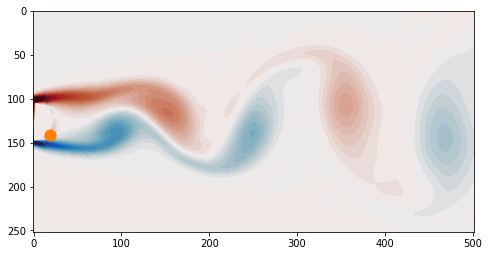

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s1_sq15_i330_D3


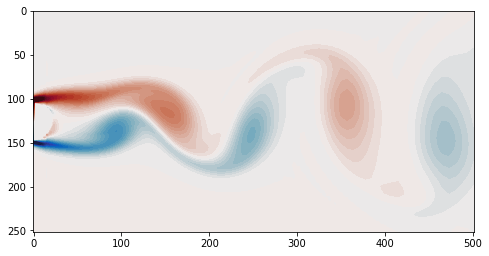

reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s1_sq15_i380_D3


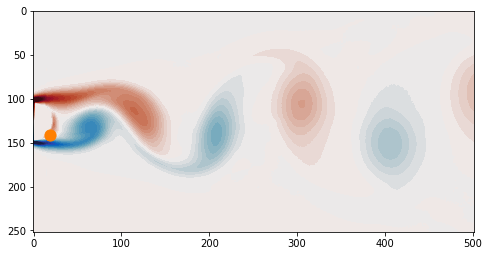

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s1_sq15_i380_D3


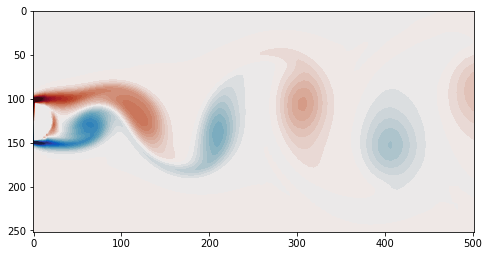

Error = 15 0.11568591684155002
reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s2_sq3_i270_D3


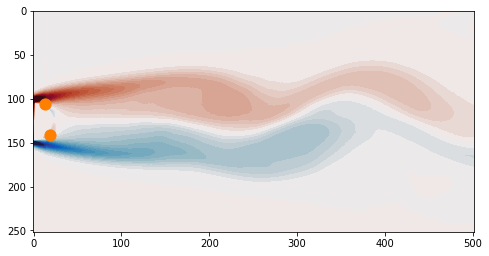

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s2_sq3_i270_D3


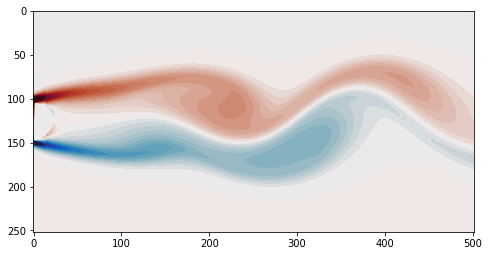

reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s2_sq3_i330_D3


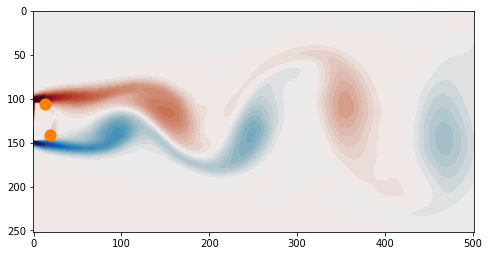

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s2_sq3_i330_D3


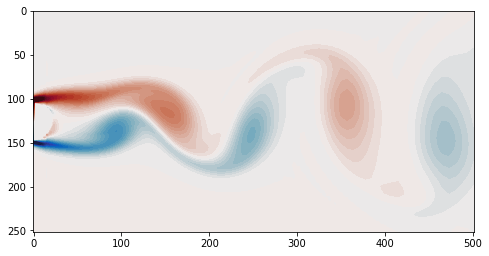

reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s2_sq3_i380_D3


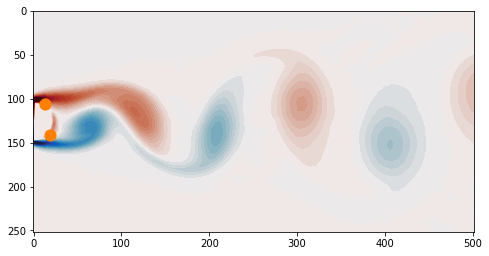

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s2_sq3_i380_D3


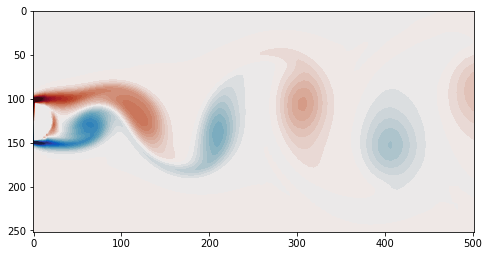

Error = 3 0.13615922938871872
reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s2_sq7_i270_D3


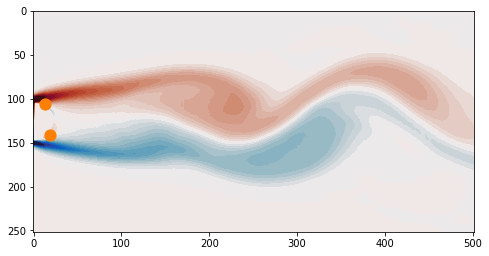

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s2_sq7_i270_D3


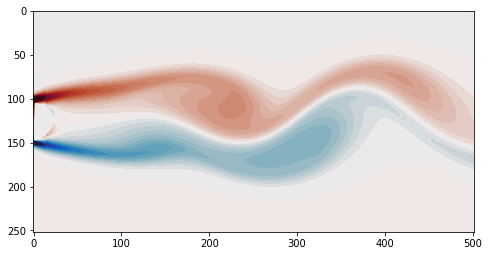

reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s2_sq7_i330_D3


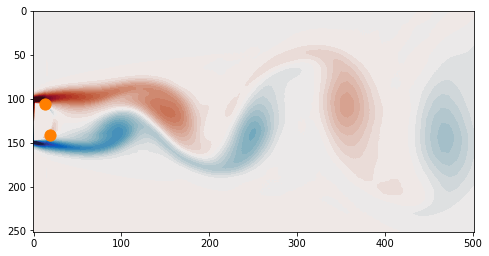

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s2_sq7_i330_D3


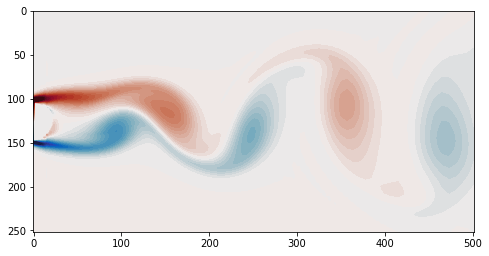

reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s2_sq7_i380_D3


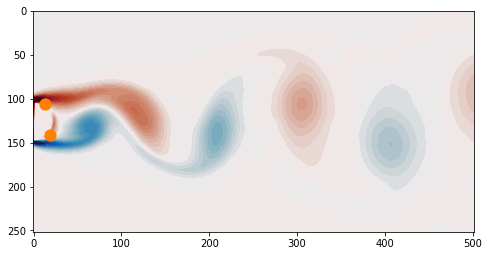

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s2_sq7_i380_D3


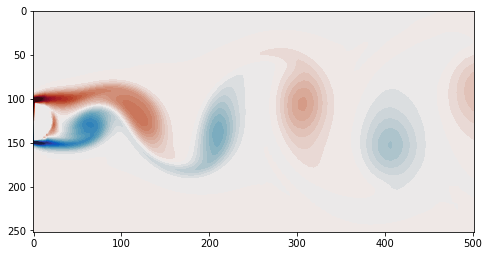

Error = 7 0.08571957178711362
reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s2_sq11_i270_D3


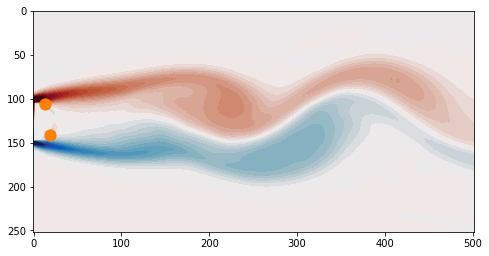

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s2_sq11_i270_D3


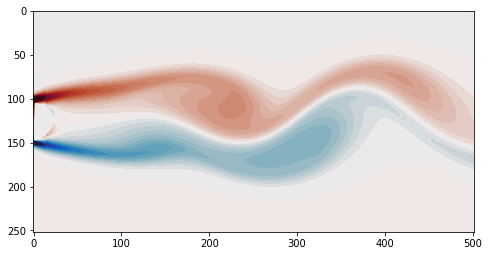

reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s2_sq11_i330_D3


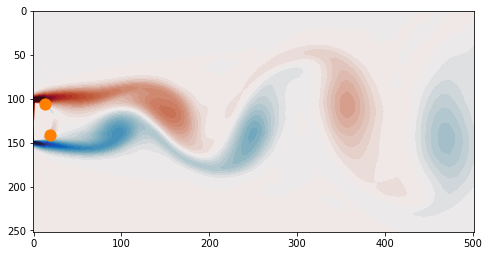

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s2_sq11_i330_D3


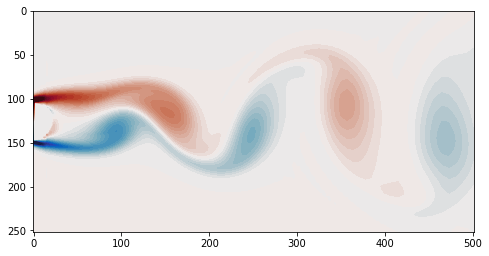

reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s2_sq11_i380_D3


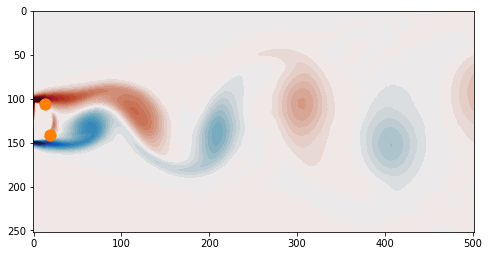

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s2_sq11_i380_D3


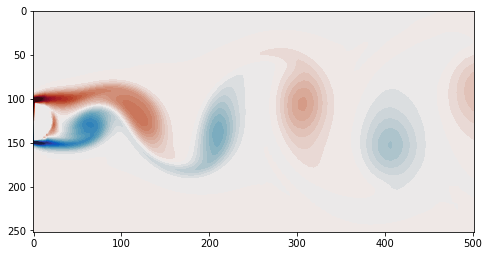

Error = 11 0.08704402067171828
reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s2_sq15_i270_D3


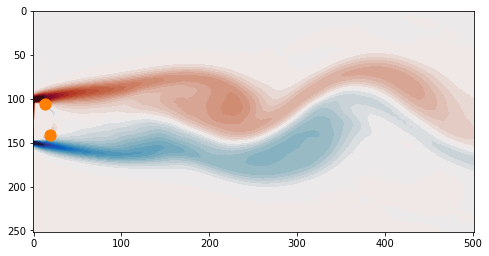

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s2_sq15_i270_D3


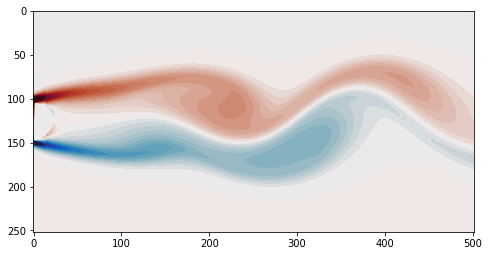

reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s2_sq15_i330_D3


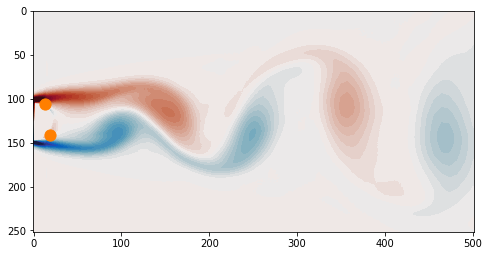

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s2_sq15_i330_D3


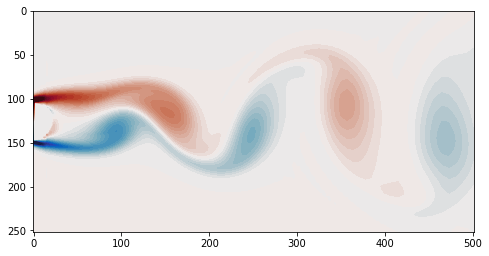

reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_s2_sq15_i380_D3


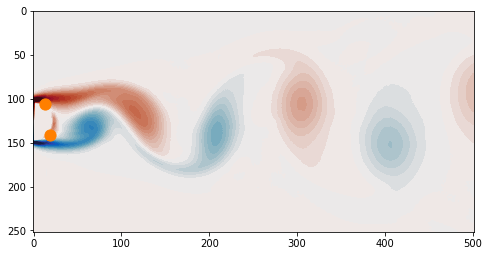

SAVED - ../content/drive/My Drive/Colab Notebooks/results/im_RNNv3_true_s2_sq15_i380_D3


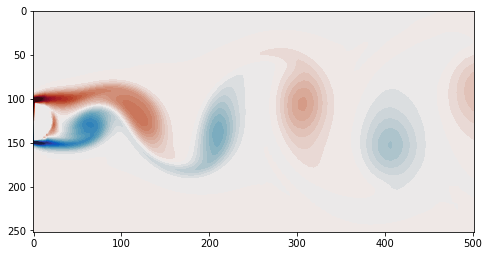

Error = 15 0.08183211798969742


In [ ]:
import cmocean

def FR_rnn(sensor_number,seq_len, bottle_neck ):
  pretrained_weightsRNN = '../content/drive/My Drive/Colab Notebooks/RNNv3_s{:d}_sq{:d}_bn{:d}_D3_weights'.format(sensor_number,seq_len, bottle_neck);

  sensor_number = sensor_number
  hidden_size = 50
  layers = 1
  seq_impct = int((seq_len-1)/2)

  gtrain_out, gvalid_out, strain_in, svalid_in, gtest_stan, stest_in_stacked, gstats, x_cord  = rnn_train_data(sensor_number, bottle_neck, seq_len)
  del(gtrain_out, gvalid_out, strain_in, svalid_in)
  # Setting up the neural network
  model = RNNv3network(hidden_size, sensor_number, bottle_neck, layers, seq_len).cuda()

  # Load saved neural network weights
  model.load_state_dict(torch.load(pretrained_weightsRNN))
  model.eval()

  # Load snapshots of sensor data and gc for testing
  test = sensorgcdatasetRNN(stest_in_stacked, gtest_stan)
  #test = sensorgcdatasetRNN(svalid_in, gvalid_out)
  test_data_genn = torch.utils.data.DataLoader(test, shuffle=False, batch_size=1, num_workers=1)

  # predicting generalized coordinates from sensor data
  #err = []
  gc_pred = np.zeros([len(test), bottle_neck])
  for i, (sensor, gc) in enumerate(test):
      y = torch.zeros(seq_len,1, sensor_number)
      for j in range(0, seq_len):
          y[j,0, :] = sensor[sensor_number*j : (sensor_number*j + sensor_number)]
      gc_out = model(y.cuda()).cpu().data.numpy()
      gc_pred[i, :] = gc_out
      #del(gc_out, y, sensor, gc)
      #err.append(np.linalg.norm(gc.numpy() - gc_pred[i, :]) ** 2 / gc_pred[i, :].size)  # /np.linalg.norm(gc) )
      #print(i)
  del(stest_in_stacked, gtest_stan)
  #print(gc_pred)
  #acc_avg = np.mean(err)
  gc_pred = gc_pred * gstats[1, :] + gstats[0, :]

  pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_D3_bn{:d}_weights'.format(bottle_neck);

  trainAE, validAE, testAE, statsAE = autoencoder_train_data()
  del(trainAE,validAE)

  model = autoencoder(bottle_neck).cuda()

  model.load_state_dict(torch.load(pretrained_weightsAE))
  model.eval()

  testAA = sensorgcdatasetAA(gc_pred, testAE[seq_impct:399-seq_impct,:], statsAE)
  train_data_genn = torch.utils.data.DataLoader(testAA, shuffle=False, batch_size=1, num_workers=1)

  #err = []
  t_pred = np.zeros([len(test), len(testAE[0,:]) ])
  t_true = np.zeros([len(test), len(testAE[0,:]) ])
  #print('jijijij')
  for i, (gc_pre, t) in enumerate(train_data_genn):
      t_out_tensor = model(gc_pre[None, :].cuda())
      t_out = t_out_tensor.cpu().data.numpy()
      t_pred[i, :] = t_out
      t_true[i, :] = t
      #err.append(np.linalg.norm(t.numpy() - t_pred[i, :]) ** 2 / t_pred[i, :].size)
      #print(t_out_tensor.shape)
      if s == 1 or s == 2:
        if i == 270-seq_impct or i ==330-seq_impct or i ==380-seq_impct:
          nothing = 0
          plot1image(t_out_tensor[0], t, statsAE, x_cord, name = 'im_RNNv3_s{:d}_sq{:d}_i{:d}_D3'.format(sensor_number,seq_len,i+seq_impct), save = 0,save2  =0, name2 = 'im_RNNv3_true_s{:d}_sq{:d}_i{:d}_D3'.format(sensor_number,seq_len,i+seq_impct) )
      if seq_len == 11:
        if i == 340- seq_impct:
          nothing = 0
          #plot1image(t_out_tensor[0], t, statsAE, x_cord, name = 'im_RNNv3_s{:d}_sq{:d}_D3'.format(sensor_number,seq_len), save = 1)

  #error = np.linalg.norm(t_true - t_pred) / np.linalg.norm(t_true)
  #print(error)

  t_pred = t_pred * statsAE[1, :] + statsAE[0, :]
  t_true = t_true * statsAE[1, :] + statsAE[0, :]

  #acc_avg = np.mean(err)
  #print(acc_avg)
  #print(min(err))

  #error = np.linalg.norm(t_true - t_pred) / np.linalg.norm(t_true)
  #print(error)

  Ferr = []
  for i in range(200,399-seq_impct*2):
      Ferr.append(np.linalg.norm(t_true[i,:] - t_pred[i,:]) / np.linalg.norm(t_true[i,:]))
  del(t_true,t_pred)
  Ferr_avg = np.mean(Ferr)
  #Terr_max = max(Terr)
  print("Error =",seq_len, Ferr_avg)
  #print("Max error =", Terr_max)
#######################################################$$$$$$$$$$$$$%%%%)



#for s in [1,2]:#[1,2,5,10]:
#  print(s)
#  FR_rnn(s)
for s in [1,2]:#,5,10]:
  for seq_len in [3,7,11,15]:
    bn = 25
    FR_rnn(s,seq_len,bn)

## FR_ADS

In [ ]:
import cmocean
def FR_ADS(sensor_number, bottle_neck):
  pretrained_weights_ds = '../content/drive/My Drive/Colab Notebooks/ADSweights_l_s{:d}_bn{:d}_D3'.format(sensor_number, bottle_neck);  
  #pretrained_weights_ds = '../content/drive/My Drive/Colab Notebooks/ADSweights_s{:d}_D3'.format(sensor_number);  

  gtrain_out, gvalid_out, strain_in, svalid_in, gtest_stan, stest_in_stacked, gstats, x_cord  = ADS_train_data(sensor_number , bottle_neck)
  del(gtrain_out, gvalid_out, strain_in, svalid_in)
  # Setting up the neural network
  model = ADSnetwork(sensor_number,bottle_neck)

  # Load saved neural network weights
  model.load_state_dict(torch.load(pretrained_weights_ds))
  model.eval()

  # Load snapshots of sensor data and gc for testing
  test = sensorgcdatasetDS(stest_in_stacked, gtest_stan)

  #err = []
  gc_pred = np.zeros([len(test), bottle_neck])
  for i, (sensor, gc) in enumerate(test):
      y = model(sensor)
      gc_out = y.data.numpy()
      gc_pred[i, :] = gc_out
      #err.append(np.linalg.norm(gc.numpy() - gc_pred[i, :]) ** 2 / gc_pred[i, :].size)  # /np.linalg.norm(gc) )
  #del(stest_in_stacked, gtest_stan)
  #print(gc_pred)
  #acc_avg = np.mean(err)
  gc_pred = gc_pred * gstats[1, :] + gstats[0, :]
  #gc_pred = gtest_stan * gstats[1, :] + gstats[0, :]


  pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_D3_bn{:d}_weights'.format(bottle_neck);

  trainAE, validAE, testAE, statsAE = autoencoder_train_data()
  del(trainAE,validAE)
  model = autoencoder(bottle_neck)

  model.load_state_dict(torch.load(pretrained_weightsAE))
  model.eval()

  testAA = sensorgcdatasetAA(gc_pred, testAE[:,:], statsAE)
  train_data_genn = torch.utils.data.DataLoader(testAA, shuffle=False, batch_size=1, num_workers=1)

  t_pred = np.zeros([len(test), len(testAE[0,:])])
  t_true = np.zeros([len(test), len(testAE[0,:])])
  print('jijijij')

  for i, (gc_pre, t) in enumerate(train_data_genn):
      t_out_tensor = model(gc_pre[None, :])
      t_out = t_out_tensor.data.numpy()
      t_pred[i, :] = t_out
      t_true[i, :] = t
      #print(t_out_tensor.shape)
      if i == 260 or i ==340 or i ==380 or i ==200 or i==300:
        nothing = 0
        #plot1image(t_out_tensor, t, statsAE, x_cord)

  t_pred = t_pred * statsAE[1, :] + statsAE[0, :]
  t_true = t_true * statsAE[1, :] + statsAE[0, :]

  Err = []
  for i in range(200,399):
      Err.append(np.linalg.norm(t_true[i,:] - t_pred[i,:]) / np.linalg.norm(t_true[i,:]))
  del(t_true,t_pred)
  Err_avg = np.mean(Err)
  print("Error ",sensor_number,'=', Err_avg)

jijijij
reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results4/im_ADSv3_s1_D3.eps


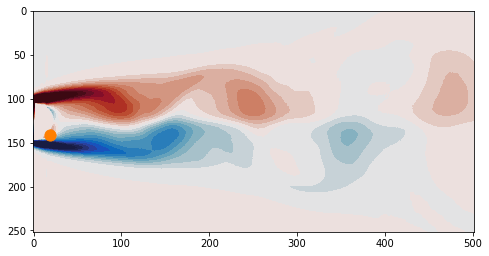

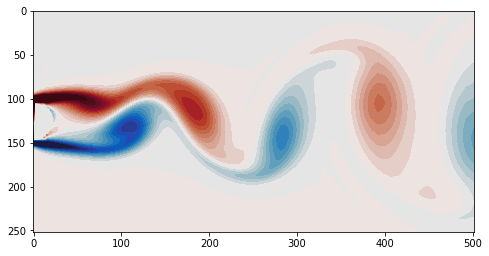

Error  1 = 0.5296450439680942
jijijij
reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results4/im_ADSv3_s2_D3.eps


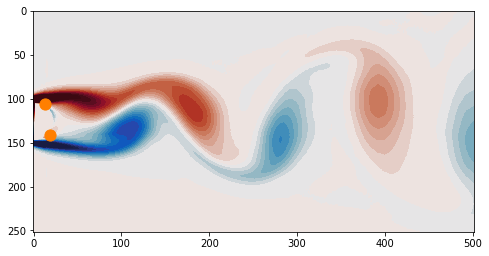

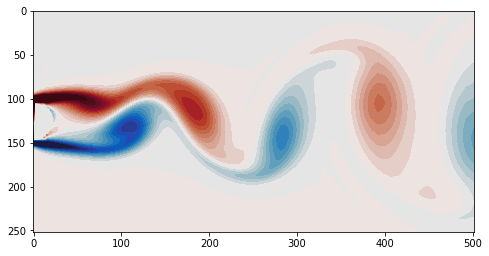

Error  2 = 0.25060685882779604
jijijij
reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results4/im_ADSv3_s5_D3.eps


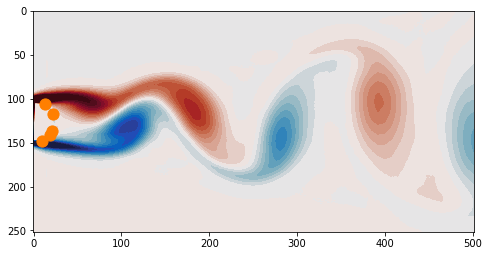

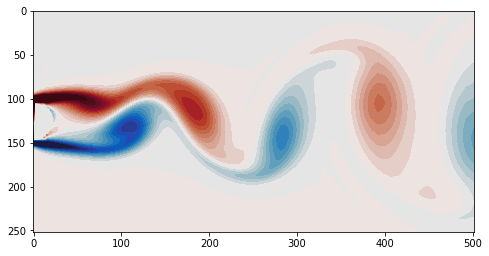

Error  5 = 0.07000474623819047
jijijij
reconstruction 250
SAVED - ../content/drive/My Drive/Colab Notebooks/results4/im_ADSv3_s10_D3.eps


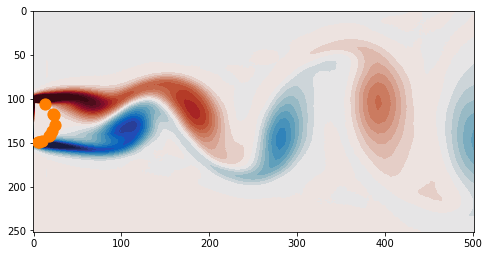

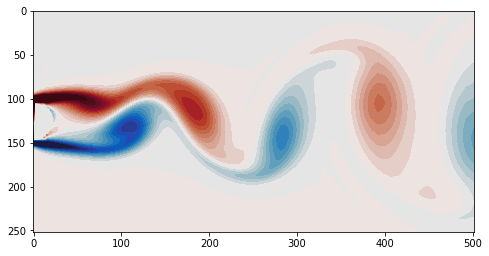

Error  10 = 0.0689830896762971


In [ ]:
import cmocean
def FR_ADS(sensor_number, bottle_neck):
  pretrained_weights_ds = '../content/drive/My Drive/Colab Notebooks/ADSweights_l_s{:d}_bn{:d}_D3'.format(sensor_number, bottle_neck);  
  #pretrained_weights_ds = '../content/drive/My Drive/Colab Notebooks/ADSweights_s{:d}_D3'.format(sensor_number);  

  gtrain_out, gvalid_out, strain_in, svalid_in, gtest_stan, stest_in_stacked, gstats, x_cord  = ADS_train_data(sensor_number , bottle_neck)
  del(gtrain_out, gvalid_out, strain_in, svalid_in)
  # Setting up the neural network
  model = ADSnetwork(sensor_number,bottle_neck)

  # Load saved neural network weights
  model.load_state_dict(torch.load(pretrained_weights_ds))
  model.eval()

  # Load snapshots of sensor data and gc for testing
  test = sensorgcdatasetDS(stest_in_stacked, gtest_stan)

  #err = []
  gc_pred = np.zeros([len(test), bottle_neck])
  for i, (sensor, gc) in enumerate(test):
      y = model(sensor)
      gc_out = y.data.numpy()
      gc_pred[i, :] = gc_out
      #err.append(np.linalg.norm(gc.numpy() - gc_pred[i, :]) ** 2 / gc_pred[i, :].size)  # /np.linalg.norm(gc) )
  #del(stest_in_stacked, gtest_stan)
  #print(gc_pred)
  #acc_avg = np.mean(err)
  gc_pred = gc_pred * gstats[1, :] + gstats[0, :]
  #gc_pred = gtest_stan * gstats[1, :] + gstats[0, :]


  pretrained_weightsAE = '../content/drive/My Drive/Colab Notebooks/nnv2_D3_bn{:d}_weights'.format(bottle_neck);

  trainAE, validAE, testAE, statsAE = autoencoder_train_data()
  del(trainAE,validAE)
  model = autoencoder(bottle_neck)

  model.load_state_dict(torch.load(pretrained_weightsAE))
  model.eval()

  testAA = sensorgcdatasetAA(gc_pred, testAE[:,:], statsAE)
  train_data_genn = torch.utils.data.DataLoader(testAA, shuffle=False, batch_size=1, num_workers=1)

  t_pred = np.zeros([len(test), len(testAE[0,:])])
  t_true = np.zeros([len(test), len(testAE[0,:])])
  print('jijijij')

  for i, (gc_pre, t) in enumerate(train_data_genn):
      t_out_tensor = model(gc_pre[None, :])
      t_out = t_out_tensor.data.numpy()
      t_pred[i, :] = t_out
      t_true[i, :] = t
      #print(t_out_tensor.shape)
      if i == 335 :
        nothing = 0
        plot1image(t_out_tensor[0], t, statsAE, x_cord, name = 'im_ADSv3_s{:d}_D3.eps'.format(sensor_number), save = 1)

  t_pred = t_pred * statsAE[1, :] + statsAE[0, :]
  t_true = t_true * statsAE[1, :] + statsAE[0, :]

  Err = []
  for i in range(200,399):
      Err.append(np.linalg.norm(t_true[i,:] - t_pred[i,:]) / np.linalg.norm(t_true[i,:]))
  del(t_true,t_pred)
  Err_avg = np.mean(Err)
  print("Error ",sensor_number,'=', Err_avg)
#def FR_PDS(s): 
#def FR_shallow(s):
for s in [1,2,5,10]:
  bn = 25
  FR_ADS(s,bn) 

## FR_PDS

In [ ]:
def FR_PDS(sensor_number, bottle_neck):

  pretrained_weights = osp.join(folder, 'PDSweights_s{:d}_bn{:d}_D3'.format(sensor_number, bottle_neck))
  gtrain_out, gvalid_out, strain_in, svalid_in, gtest_stan, stest_in_stacked, gstats, x_cord,phi,mean   = PDS_train_data(sensor_number,bottle_neck)
  del(gtrain_out, gvalid_out, strain_in, svalid_in)
  # Setting up the neural network
  modell = PDSnetwork(sensor_number, bottle_neck)

  # Load saved neural network weights
  modell.load_state_dict(torch.load(pretrained_weights))
  modell.eval()

  # Load snapshots of sensor data and gc for testing
  test = sensorgcdatasetDS(stest_in_stacked, gtest_stan)
  #print(stest_in_stacked.shape)
  #print( gtest_stan.shape)

  gc_pred = np.zeros([len(test), bottle_neck])
  gc_pod = np.zeros([len(test), bottle_neck])
  for i, (sensor, gc) in enumerate(test):
      y = modell(sensor)
      gc_out = y.data.numpy()
      gc_pred[i, :] = gc_out
      gcc = gc.data.numpy()
      gc_pod[i, :] = gcc

  #print(gc_pred)
  #acc_avg = np.mean(err)
  gc_pred = gc_pred * gstats[1, :] + gstats[0, :]
  gc_pod = gc_pod*gstats[1, :] + gstats[0, :]

  trainAE, validAE, testAE, stats = autoencoder_train_data()
  #mean = np.mean(trainAE, axis = 0)
  #X = trainAE - mean
  #X = X.transpose()
  #phi, s, V = np.linalg.svd(X,full_matrices=False)
  del(trainAE,validAE)
  #phi = phi[:,0:bottle_neck]

  t_pred = gc_pred.dot(phi.T) 
  t_true = testAE - mean#np.mean(total[:,:].transpose(), axis = 1)

  t_pred = gc_pred.dot(phi.T) + mean#np.mean(total[:,:].transpose(), axis = 1)
  t_pod = gc_pod.dot(phi.T) + mean#np.mean(total[:,:].transpose(), axis = 1)
  t_true = testAE

  #gc_pod = gtest_out*gstats[1, :] + gstats[0, :]
  #t_pred = gc_pod.dot(phi.T) + mean
  #error = np.linalg.norm(t_true - t_pred) / np.linalg.norm(t_true)
  #print(error)

  #plot1image(t_pred,t_true, stats)


  Terr = []
  for i in range(200,399):
      Terr.append(np.linalg.norm(t_true[i,:] - t_pred[i,:]) / np.linalg.norm(t_true[i,:]))

  Terr_avg = np.mean(Terr)
  print("Error",sensor_number, Terr_avg)

  #nx=299 ny=502 ns = nx*ny
  m,n = mn()
  ny = m
  nx = n
  x2 = np.arange(0, ny, 1)
  y2 = np.arange(0, nx, 1)
  mX, mY = np.meshgrid(x2, y2)


  del(t_pred,t_pod,t_true)

In [ ]:
import pandas as pd
import numpy as np
import cmocean

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
import matplotlib.pyplot as pt
def FR_PDS(sensor_number, bottle_neck): 
  #pretrained_weightsRNN = '../content/drive/My Drive/Colab Notebooks/PDSweights_s{:d}_D3'.format(sensor_number);
  pretrained_weights = osp.join(folder, 'PDSweights_l_s{:d}_bn{:d}_D3'.format(sensor_number, bottle_neck))
  gtrain_out, gvalid_out, strain_in, svalid_in, gtest_stan, stest_in_stacked, gstats, x_cord,phi,mean   = PDS_train_data(sensor_number,bottle_neck)
  del(gtrain_out, gvalid_out, strain_in, svalid_in)
  # Setting up the neural network
  modell = PDSnetwork(sensor_number, bottle_neck)

  # Load saved neural network weights
  modell.load_state_dict(torch.load(pretrained_weightsRNN))
  modell.eval()

  # Load snapshots of sensor data and gc for testing
  test = sensorgcdatasetDS(stest_in_stacked, gtest_stan)
  #print(stest_in_stacked.shape)
  #print( gtest_stan.shape)

  gc_pred = np.zeros([len(test), bottle_neck])
  gc_pod = np.zeros([len(test), bottle_neck])
  for i, (sensor, gc) in enumerate(test):
      y = modell(sensor)
      gc_out = y.data.numpy()
      gc_pred[i, :] = gc_out
      gcc = gc.data.numpy()
      gc_pod[i, :] = gcc

  #print(gc_pred)
  #acc_avg = np.mean(err)
  gc_pred = gc_pred * gstats[1, :] + gstats[0, :]
  gc_pod = gc_pod*gstats[1, :] + gstats[0, :]

  trainAE, validAE, testAE, stats = autoencoder_train_data()
  #mean = np.mean(trainAE, axis = 0)
  #X = trainAE - mean
  #X = X.transpose()
  #phi, s, V = np.linalg.svd(X,full_matrices=False)
  del(trainAE,validAE)
  #phi = phi[:,0:bottle_neck]

  t_pred = gc_pred.dot(phi.T) 
  t_true = testAE - mean#np.mean(total[:,:].transpose(), axis = 1)

  t_pred = gc_pred.dot(phi.T) + mean#np.mean(total[:,:].transpose(), axis = 1)
  t_pod = gc_pod.dot(phi.T) + mean#np.mean(total[:,:].transpose(), axis = 1)
  t_true = testAE

  #gc_pod = gtest_out*gstats[1, :] + gstats[0, :]
  #t_pred = gc_pod.dot(phi.T) + mean
  #error = np.linalg.norm(t_true - t_pred) / np.linalg.norm(t_true)
  #print(error)

  #plot1image(t_pred,t_true, stats)


  Terr = []
  for i in range(200,399):
      Terr.append(np.linalg.norm(t_true[i,:] - t_pred[i,:]) / np.linalg.norm(t_true[i,:]))

  Terr_avg = np.mean(Terr)
  print("Error",sensor_number, Terr_avg)

  #nx=299 ny=502 ns = nx*ny
  m,n = mn()
  ny = m
  nx = n
  x2 = np.arange(0, ny, 1)
  y2 = np.arange(0, nx, 1)
  mX, mY = np.meshgrid(x2, y2)

  for i in [350]:
    #print(i)
    t_predd = t_pred[i,:].reshape((ny, nx))
    minmax = np.max(np.abs(t_predd)) * 0.65
    pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    im = pt.imshow(t_predd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    pt.contourf(mX, mY, t_predd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
    pt.scatter(x_cord[:,0], x_cord[:,1], marker='.', color='#ff7f00', s=500, zorder=5)
    save =1
    if save ==1:
      im_name = 'im_PDS_s{:d}_D3.eps'.format(sensor_number)
      # savefig(fname, dpi=None, facecolor='w', edgecolor='w',
      #   orientation='portrait', papertype=None, format='eps',
      #   transparent=False, bbox_inches=None, pad_inches=0.1,
      #   frameon=None, metadata=None)
      # pt.savefig('../content/drive/My Drive/Colab Notebooks/results4/tr/{}'.format(im_name),format='eps')
      # print('SAVED -','../content/drive/My Drive/Colab Notebooks/results4/tr/{}'.format(im_name))

    # pt.show()

    #pt.pcolormesh(t_predd.T, cmap=pt.cm.jet, vmin=-0.0003, vmax=0.0003)
    #pt.pcolormesh(t_predd.T)
    #pt.show()
    #********************************************************
    # t_podd = t_pod[i,:].reshape((ny, nx))
    # minmax = np.max(np.abs(t_podd)) * 0.65
    # pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    # im = pt.imshow(t_podd.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    # pt.contourf(mX, mY, t_podd.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
    # pt.show()
    #********************************************************  
    t_truee = t_true[i,:].reshape((ny, nx))
    minmax = np.max(np.abs(t_truee)) * 0.65
    pt.figure(facecolor="white",  edgecolor='k', figsize=(7.9,4.7))
    im = pt.imshow(t_truee.T, cmap=cmocean.cm.balance, interpolation='none', vmin=-minmax, vmax=minmax)
    pt.contourf(mX, mY, t_truee.T, 80, cmap=cmocean.cm.balance, alpha=1, vmin=-minmax+3, vmax=minmax-3)
    if s == 2:
      im_name = 'im_true_350_D3.eps'
      # pt.savefig('../content/drive/My Drive/Colab Notebooks/results4/tr/{}'.format(im_name), format='eps')
      # print('SAVED -','../content/drive/My Drive/Colab Notebooks/results4/{}'.format(im_name))
    # pt.show()
  del(t_pred,t_pod,t_true)
  return Terr_avg

# for s in [2]:
#   bn = 25
#   FR_PDS(s, bn) 


noise_error = np.zeros((3, 1, 25))
for s, i in [[1, 0], [2, 1], [5, 2]]:
    for bn in [25]:
      for SNR in range(0,100,4):
        print('no. of sensors',s,'SNR',SNR)
        aaa = FR_PDS(s,bn,drop=1,SNR=SNR)
        noise_error[i, 0, int(SNR/4)] = aaa[0]
np.savetxt(osp.join(path2, "noise_error_s_1_PDS_{}.csv".format(args.RNN)), noise_error[0], delimiter=",")
np.savetxt(osp.join(path2, "noise_error_s_2_PDS_{}.csv".format(args.RNN)), noise_error[1], delimiter=",")
np.savetxt(osp.join(path2, "noise_error_s_5_PDS_{}.csv".format(args.RNN)), noise_error[2], delimiter=",")

no. of sensors 1 SNR 0


NameError: ignored

In [ ]:
for s in [1,2,5,10,15]:
  print(s)
  FR_rnn(s)
for s in [1,2,5,10,15]:
  print(s)
  FR_ADS(s)
for s in [1,2,5,10,15]:
  print(s)
  FR_PDS(s)
# for s in [1,2,5,10,15]:
#   print(s)
#   FR_shallow(s)  

In [ ]:
for bn in [5,15,25,50]:
  print(bn)
  s =5
  seq_len = 11
  FR_rnn(s,seq_len, bn)
for bn in [5,15,25,50]:
  print(bn)
  s= 5
  FR_ADS(s, bn)
for bn in [5,15,25,50]:
  print(bn)
  s= 5
  FR_PDS(s, bn)

5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


Error = 11 0.06924752627931868
15
Error = 11 0.03688247374011374
25
Error = 11 0.06066012508604608
50
Error = 11 0.054832900594887136
5
jijijij
Error  5 = 0.07787257330928496
15
jijijij
Error  5 = 0.049031772833146366
25
jijijij
Error  5 = 0.06618922538731152
50
jijijij
Error  5 = 0.05679956528173834
5
Error 5 0.3299412720803431
15
Error 5 0.18237357066198287
25
Error 5 0.11489985571971567
50
Error 5 0.08086318595351734


5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:181: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:239: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


reconstruction 250


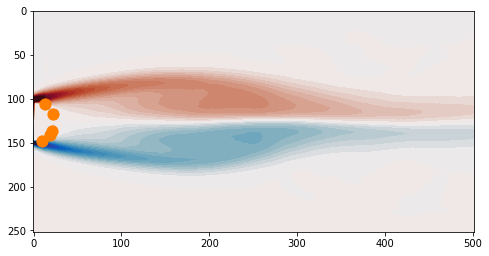

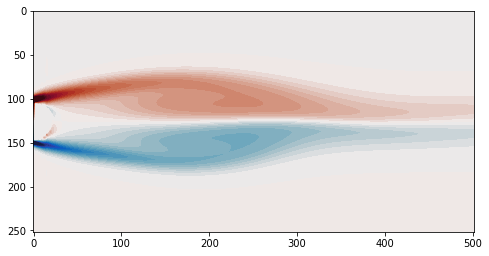

reconstruction 250


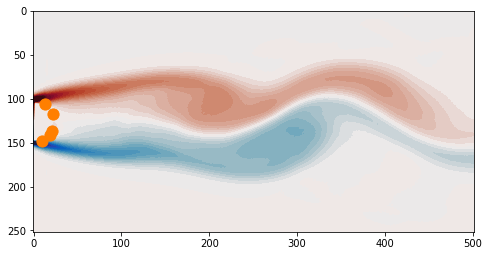

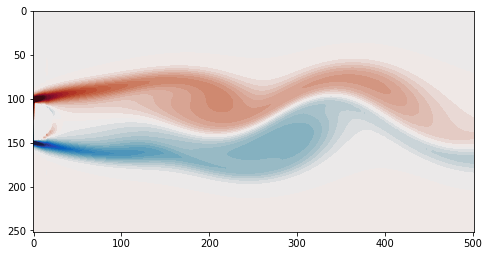

reconstruction 250


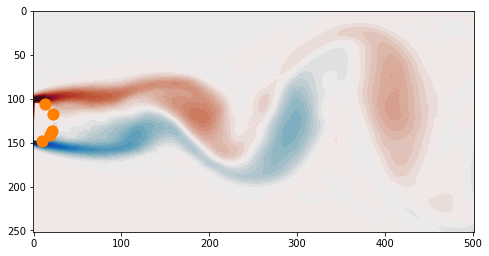

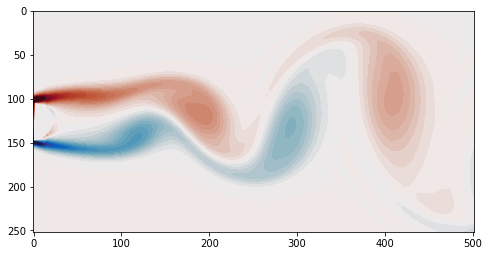

reconstruction 250


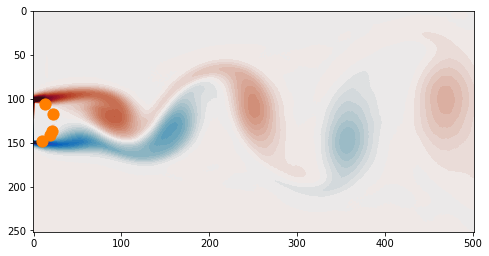

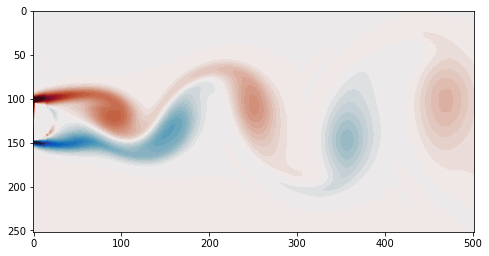

reconstruction 250


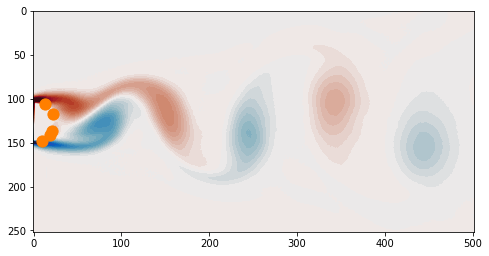

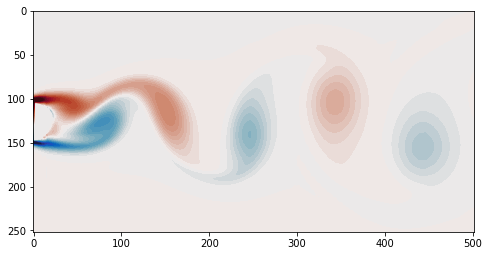

Error = 11 0.06924752627931868
15
reconstruction 250


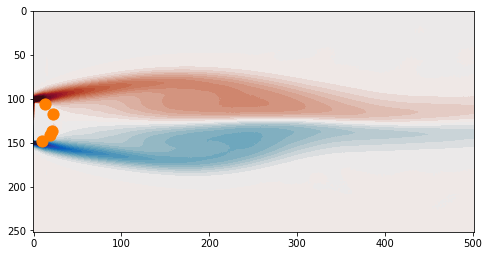

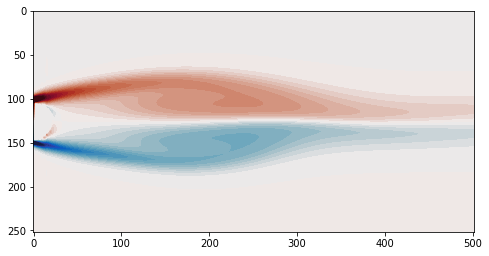

reconstruction 250


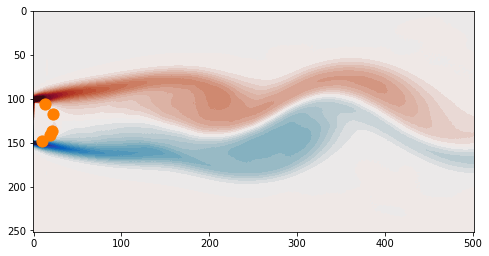

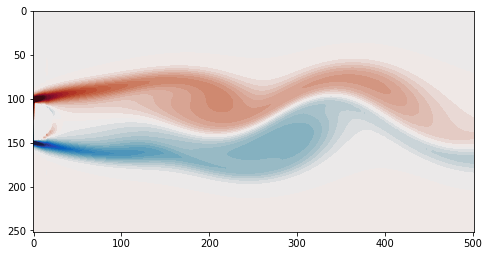

reconstruction 250


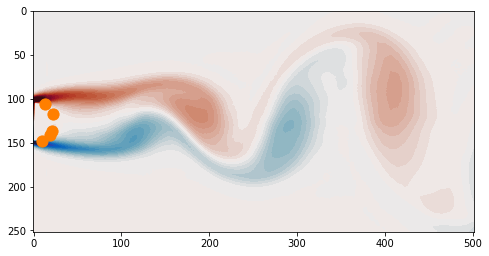

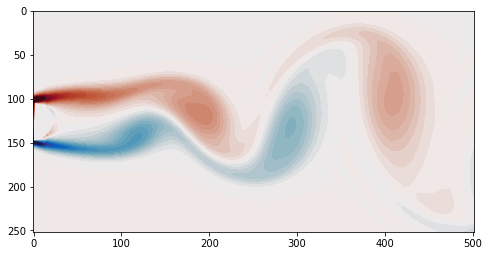

reconstruction 250


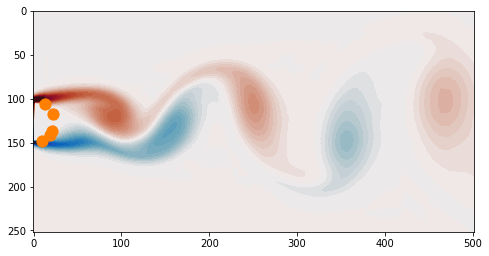

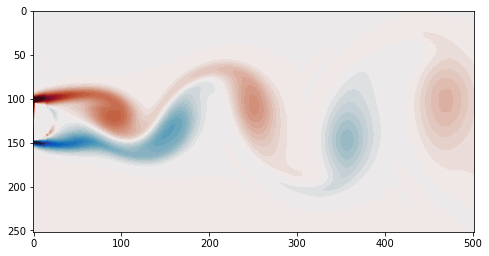

reconstruction 250


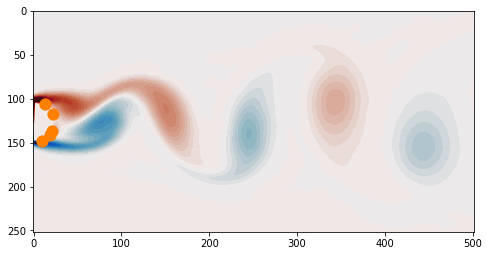

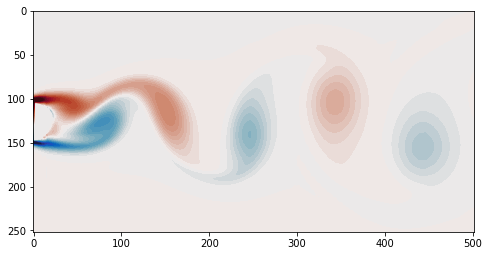

Error = 11 0.03688247374011374
25
reconstruction 250


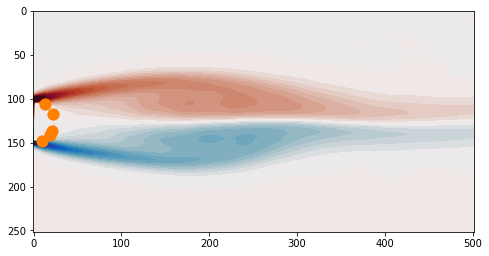

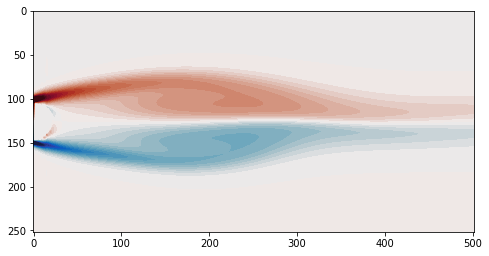

reconstruction 250


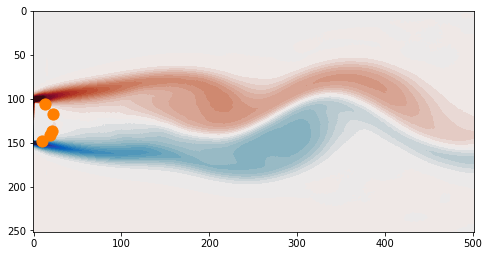

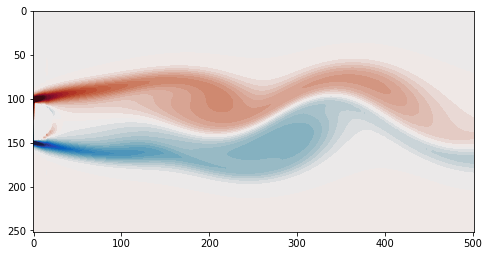

reconstruction 250


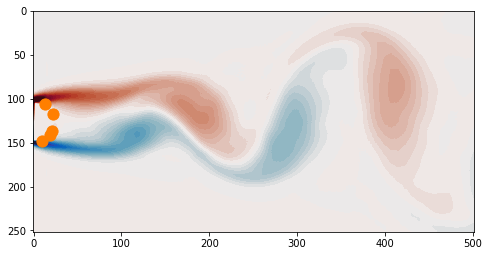

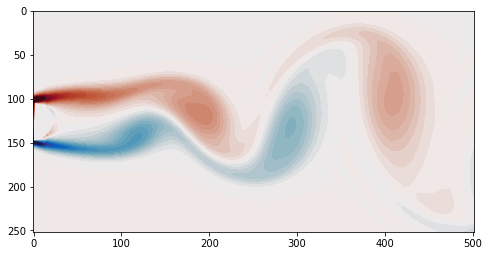

reconstruction 250


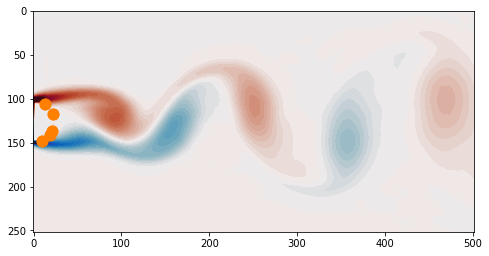

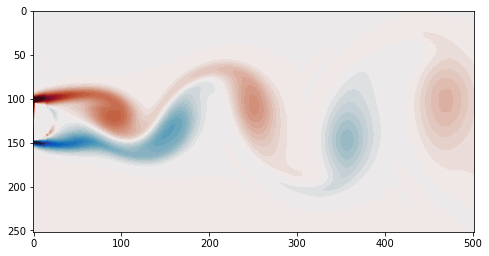

reconstruction 250


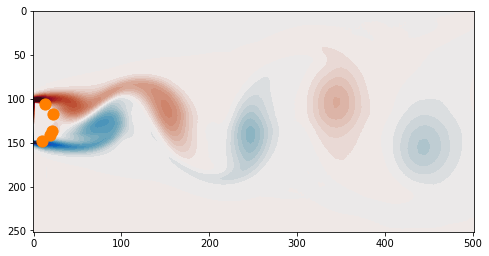

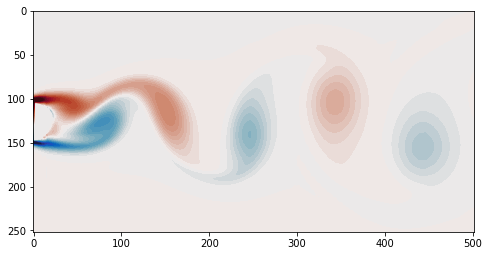

Error = 11 0.06066012508604608
50
reconstruction 250


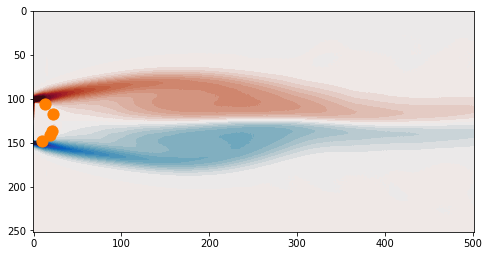

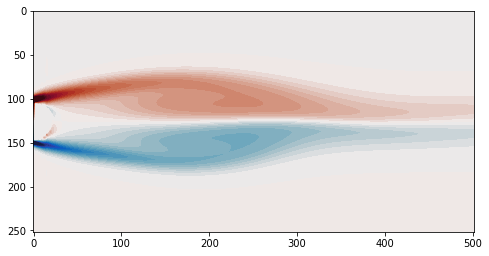

reconstruction 250


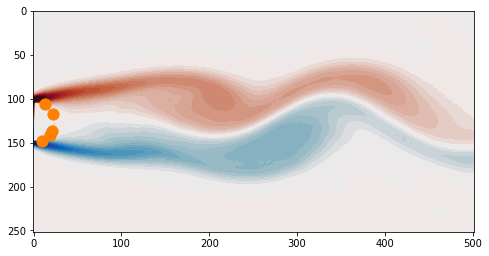

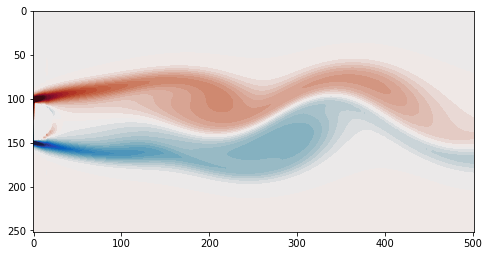

reconstruction 250


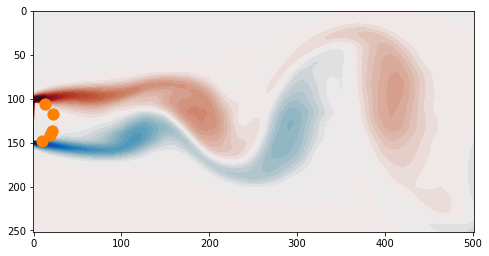

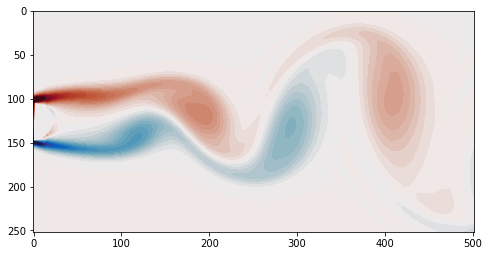

reconstruction 250


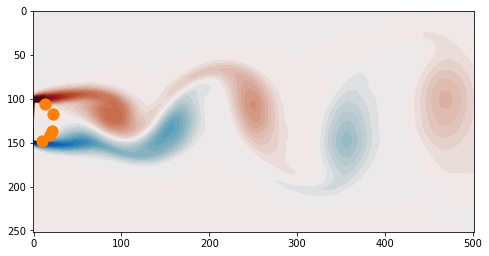

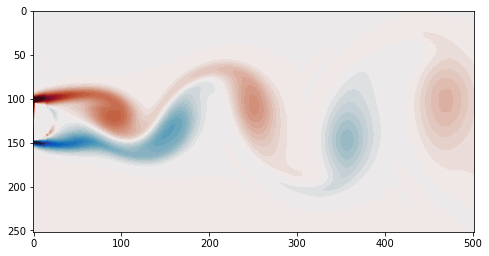

reconstruction 250


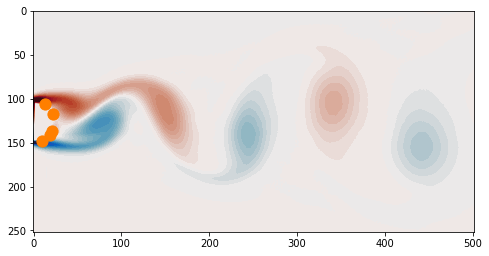

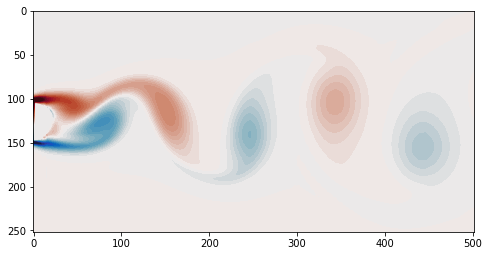

Error = 11 0.054832900594887136
5
jijijij
reconstruction 250


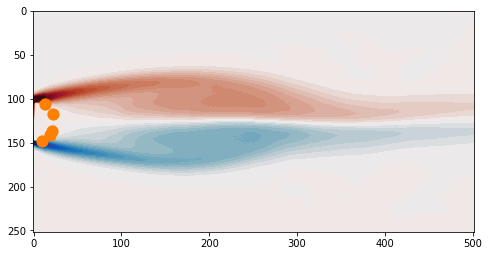

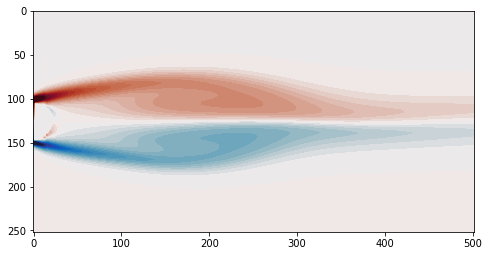

reconstruction 250


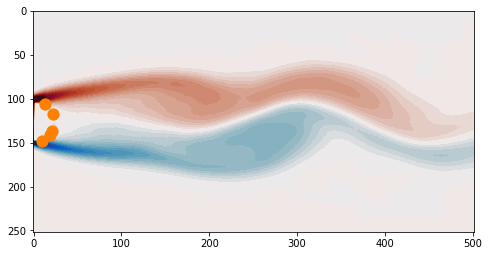

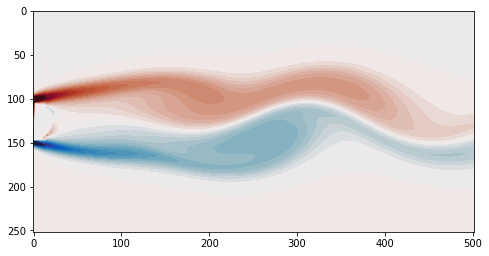

reconstruction 250


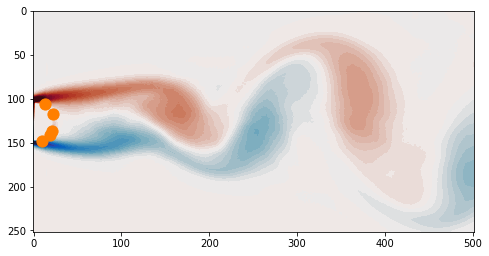

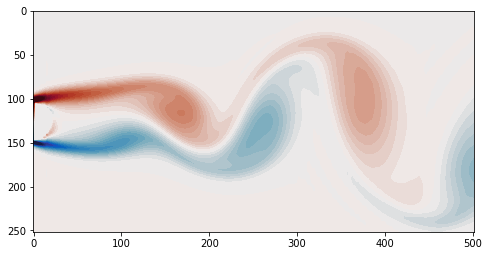

reconstruction 250


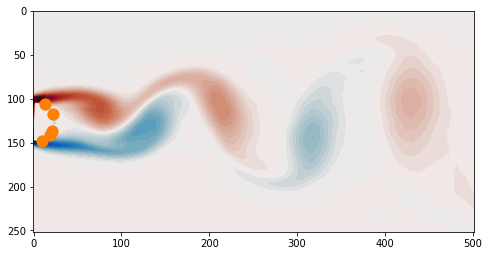

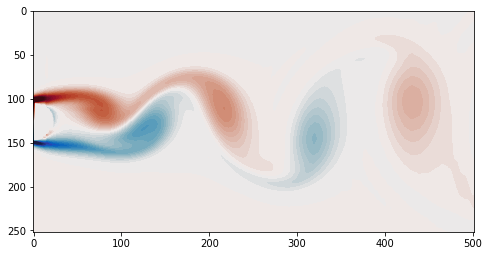

reconstruction 250


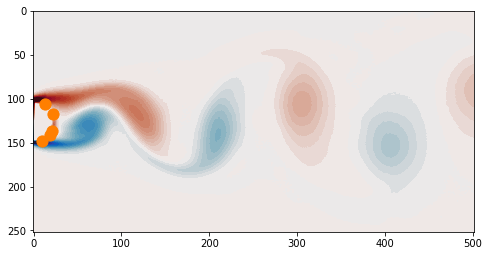

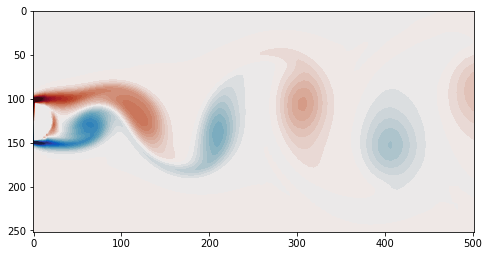

Error  5 = 0.07787257330928496
15
jijijij
reconstruction 250


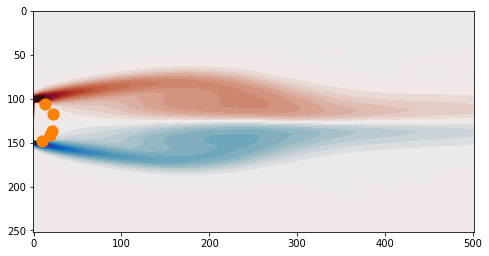

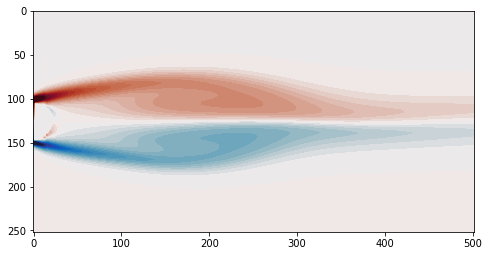

reconstruction 250


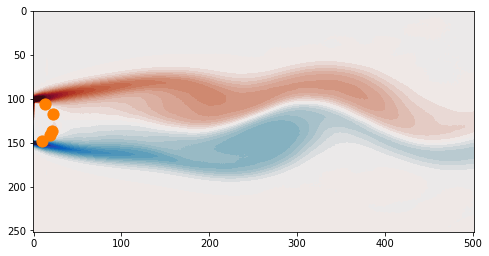

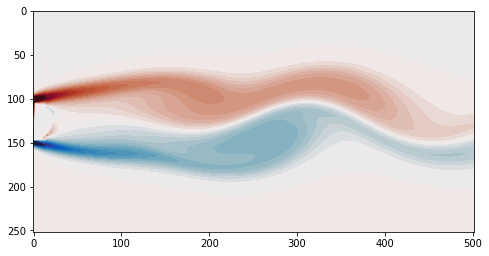

reconstruction 250


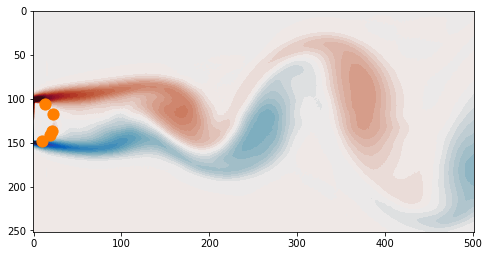

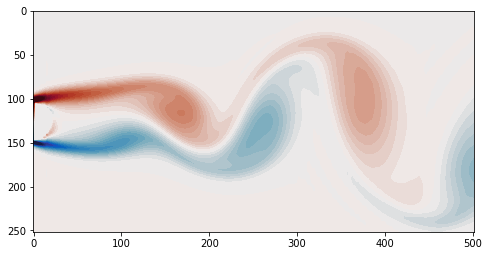

reconstruction 250


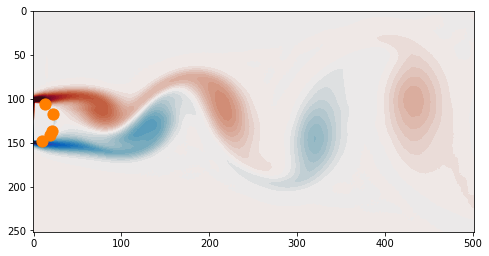

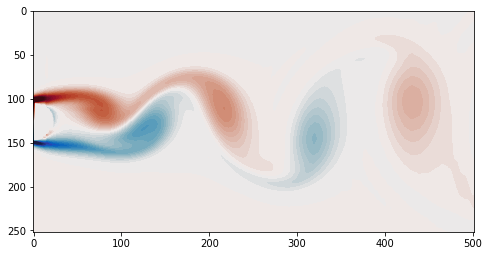

reconstruction 250


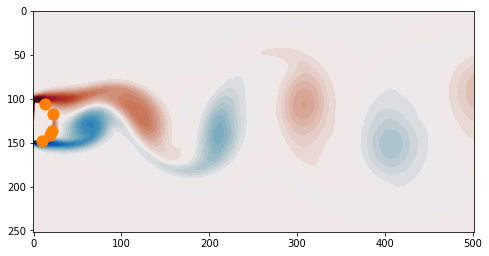

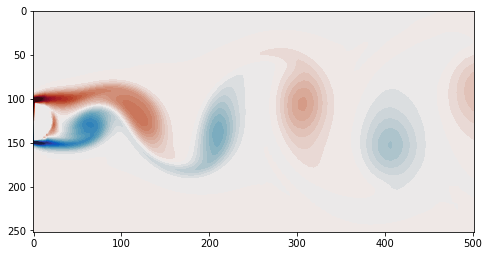

Error  5 = 0.049031772833146366
25
jijijij
reconstruction 250


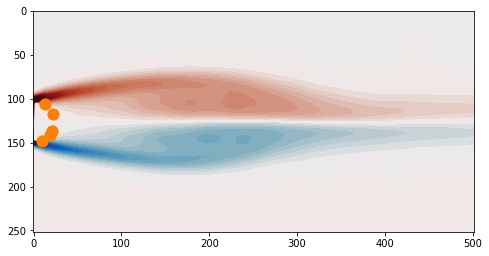

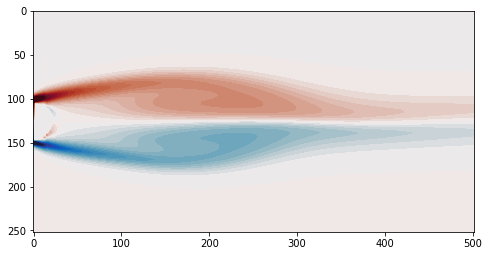

reconstruction 250


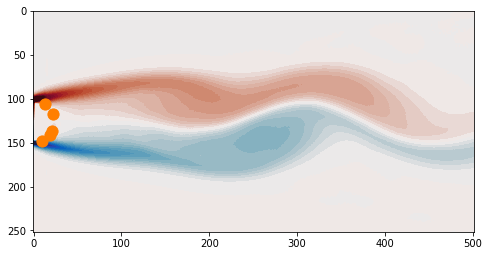

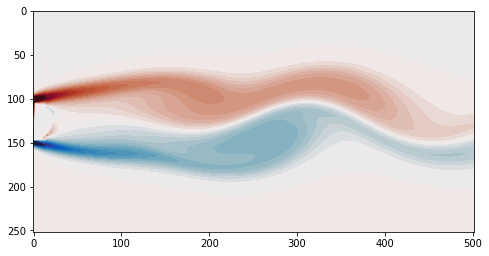

reconstruction 250


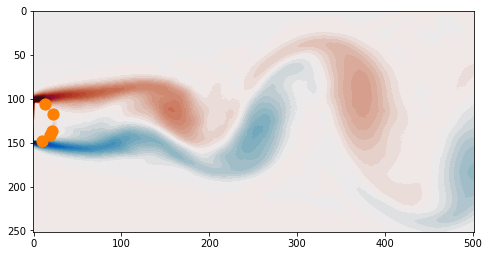

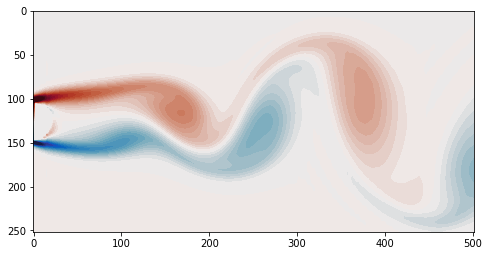

reconstruction 250


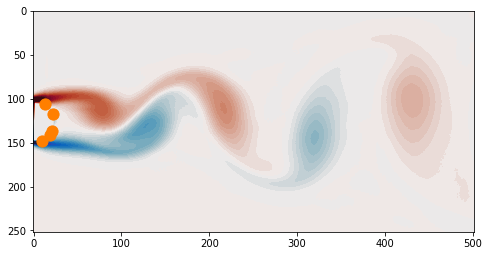

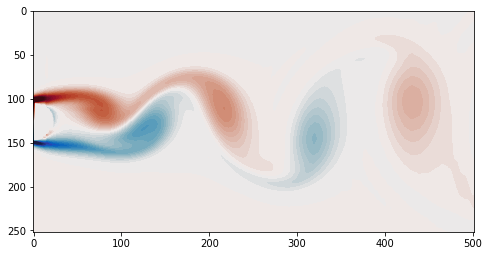

reconstruction 250


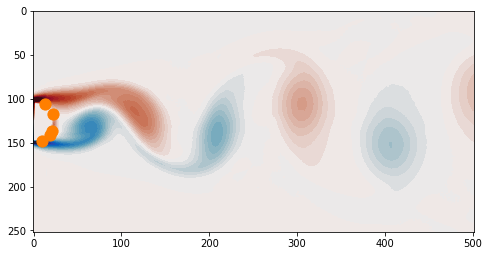

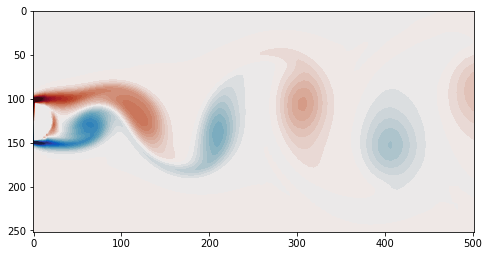

Error  5 = 0.06618922538731152
50
jijijij
reconstruction 250


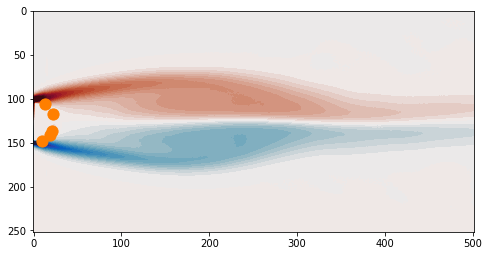

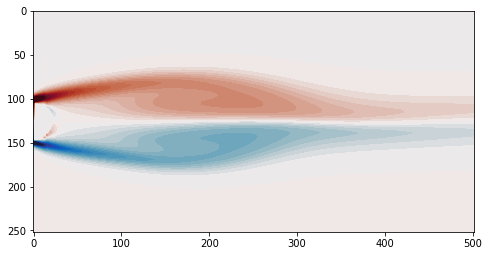

reconstruction 250


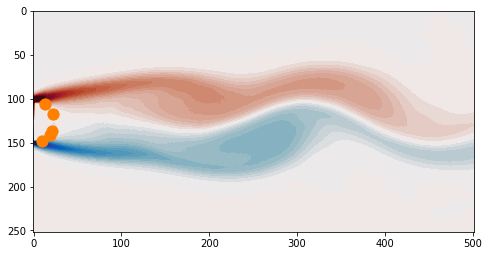

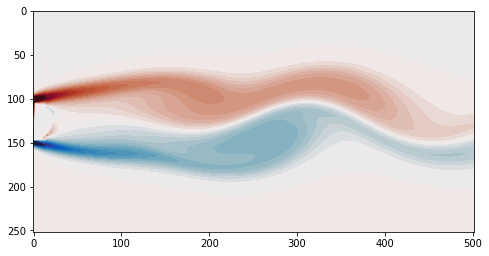

reconstruction 250


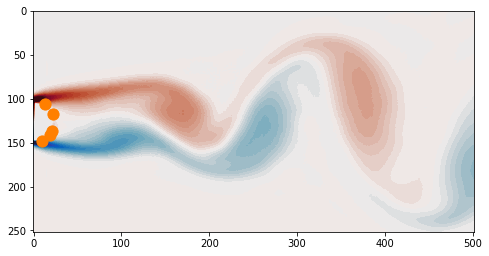

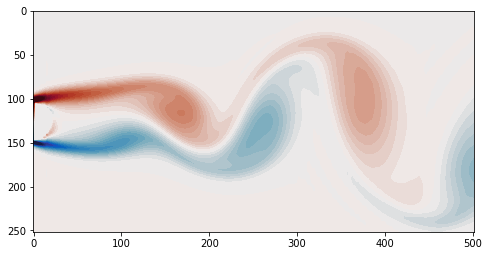

reconstruction 250


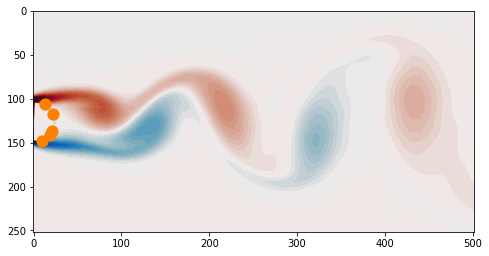

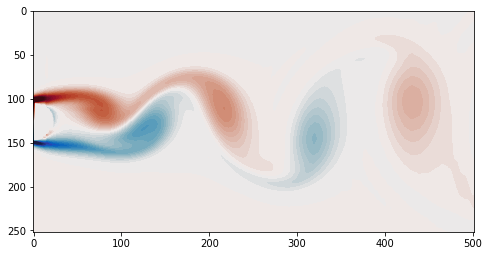

reconstruction 250


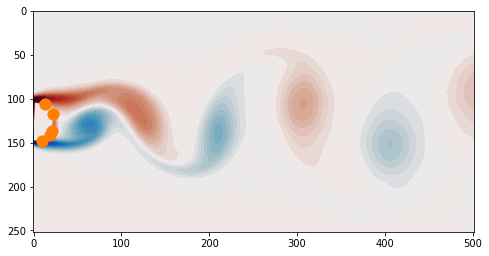

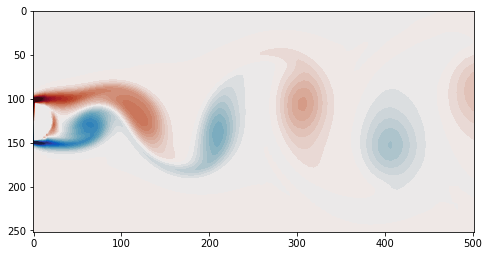

Error  5 = 0.05679956528173834
5
Error 5 0.3299412720803431


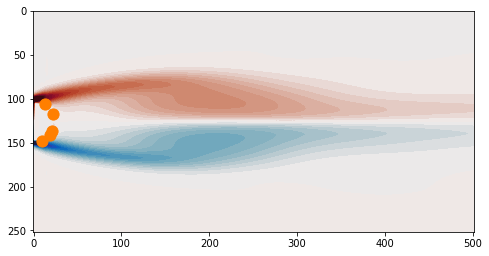

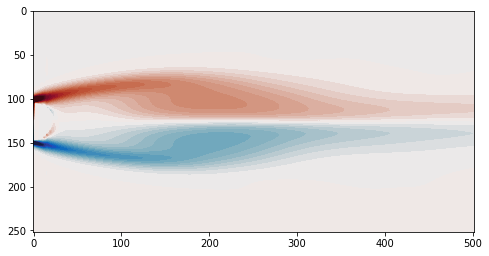

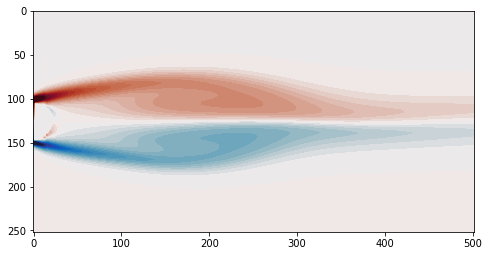

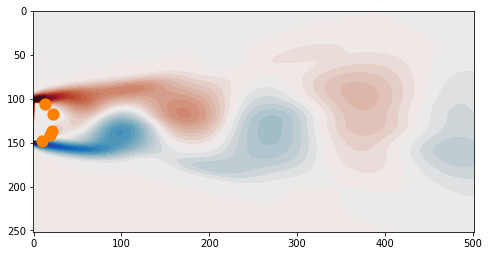

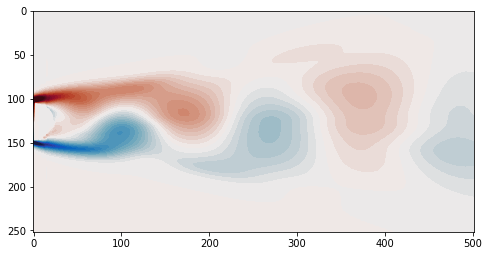

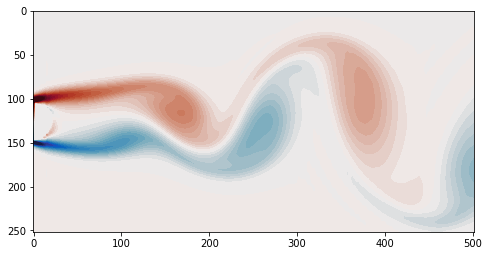

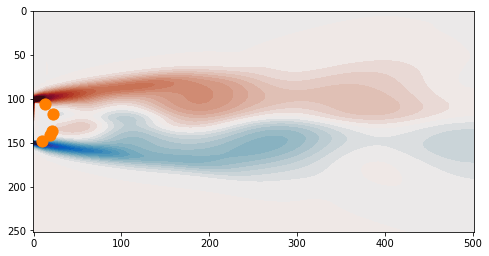

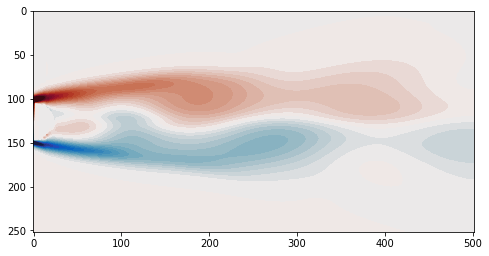

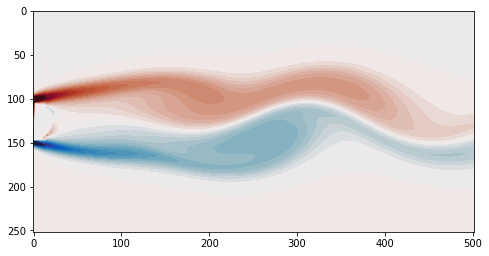

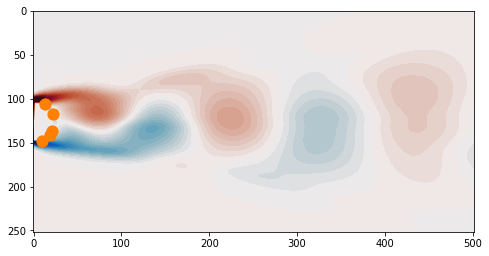

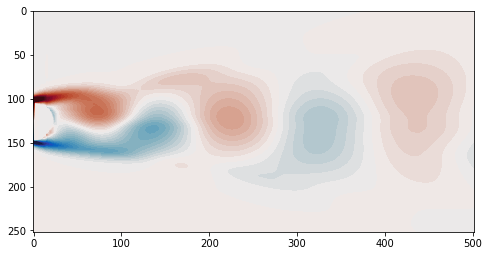

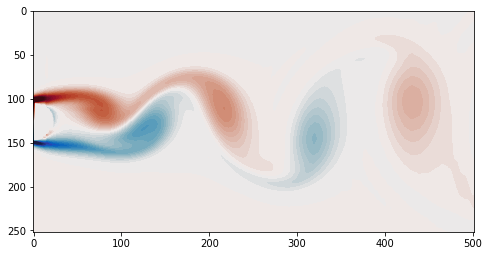

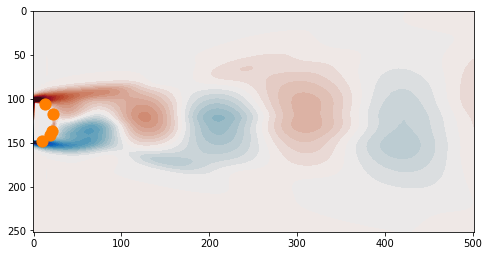

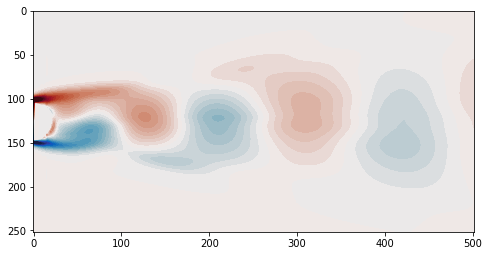

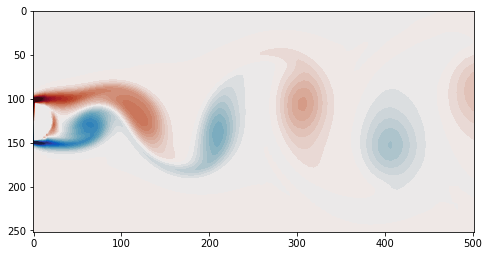

15
Error 5 0.18237357066198287


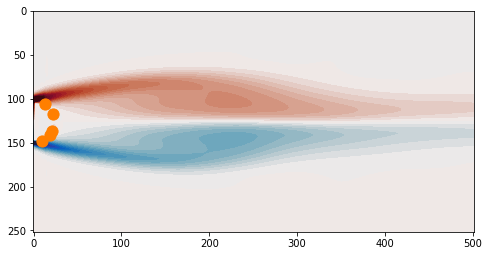

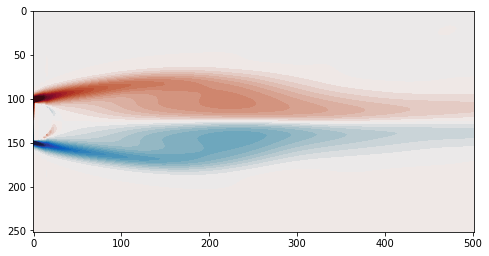

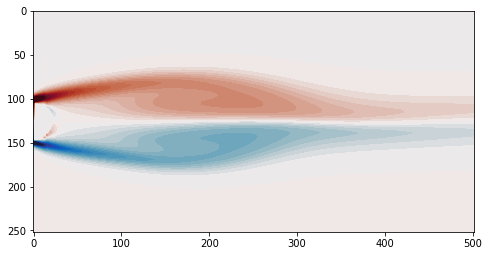

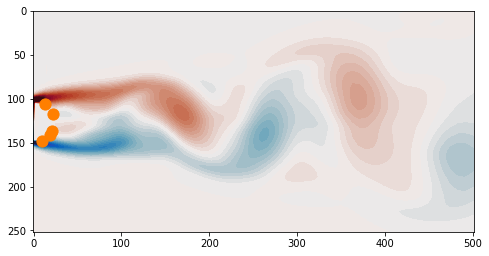

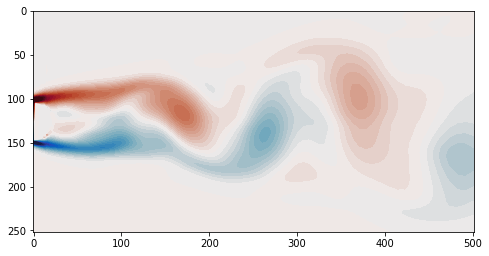

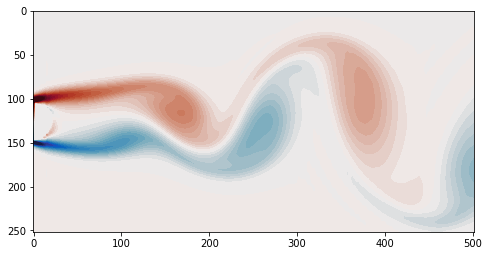

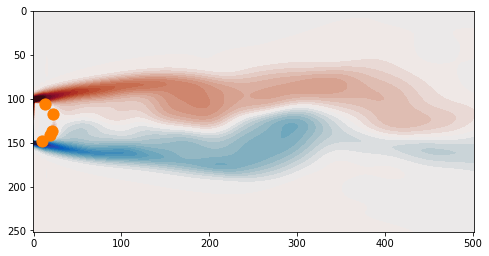

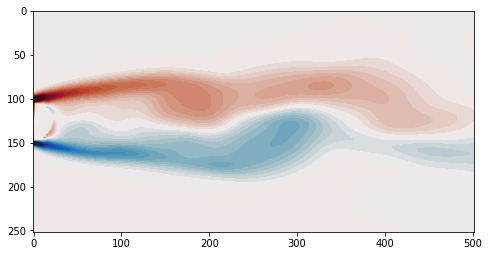

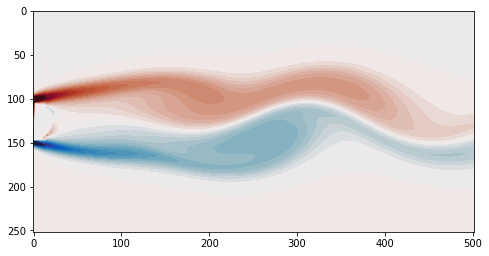

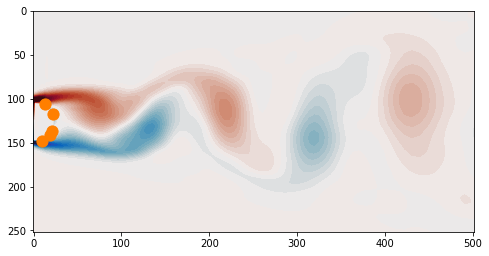

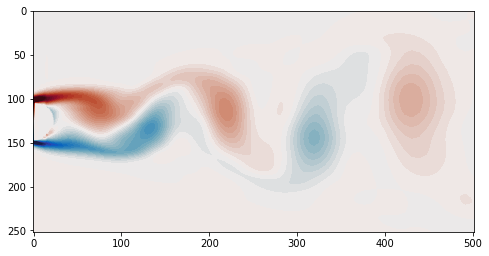

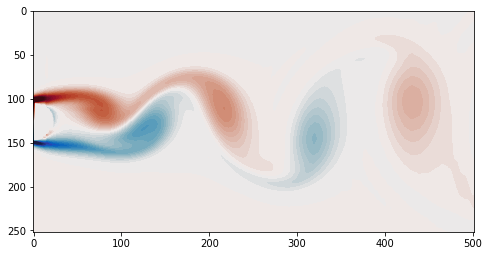

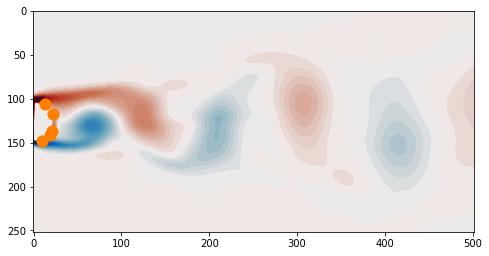

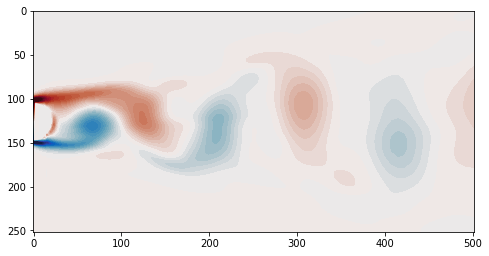

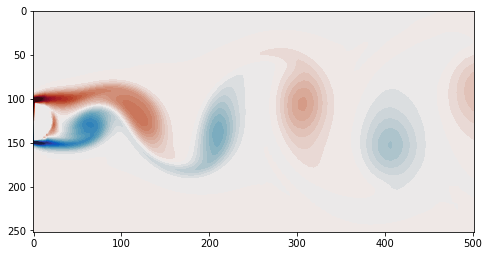

25
Error 5 0.11489985571971567


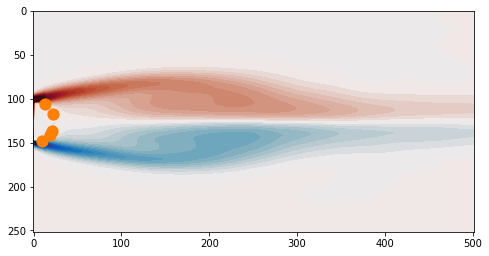

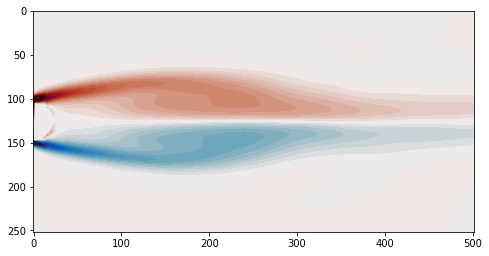

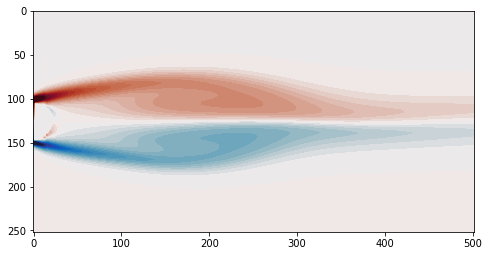

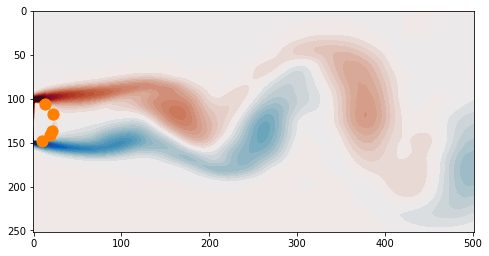

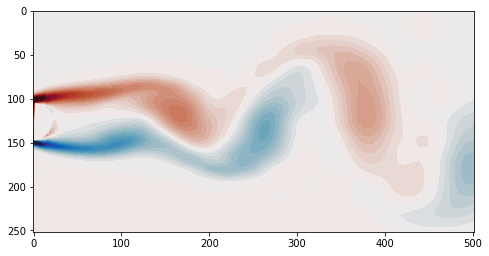

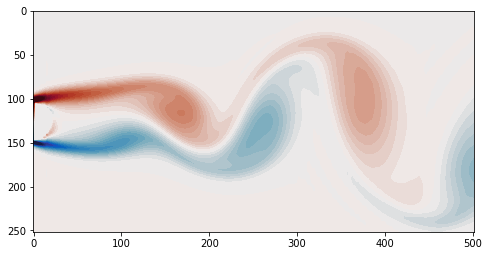

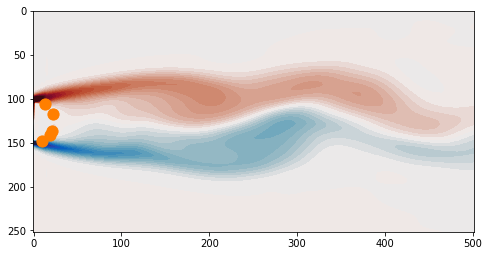

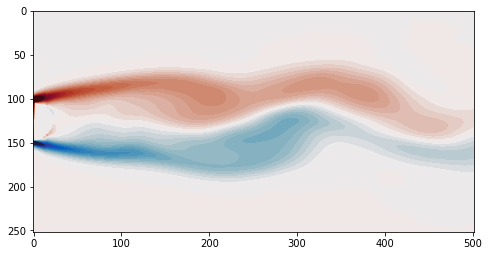

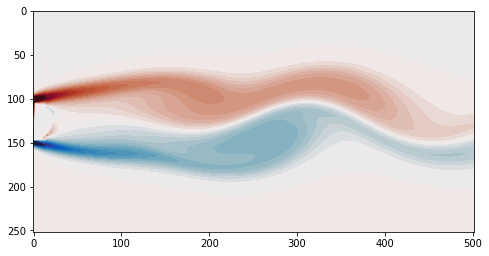

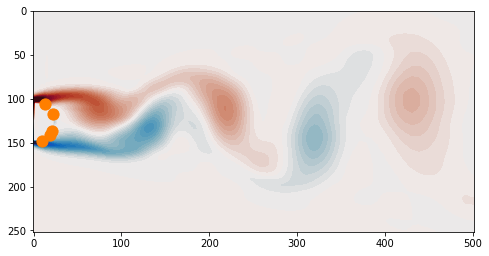

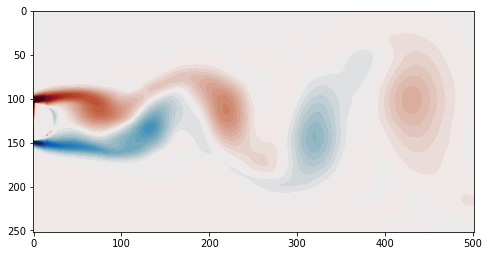

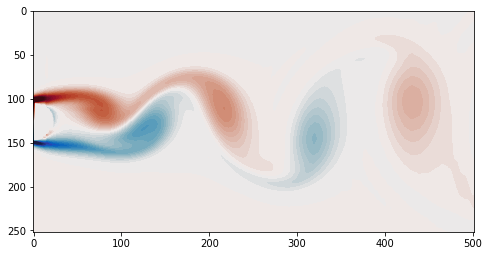

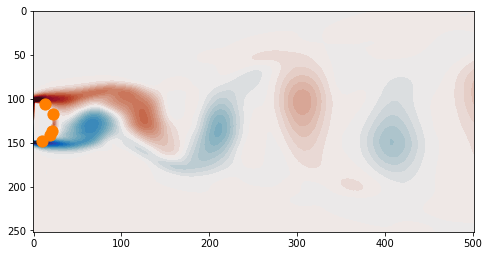

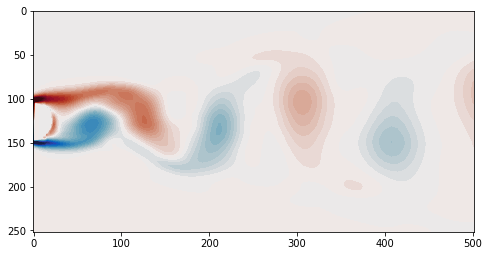

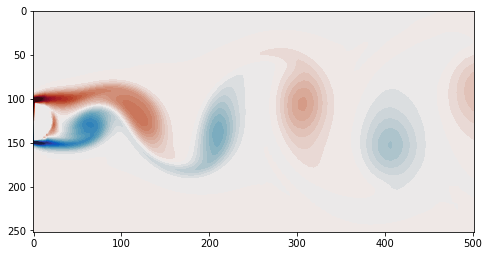

50
Error 5 0.08086318595351734


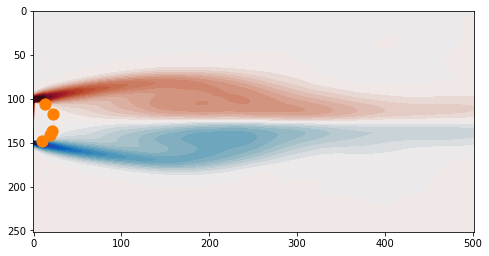

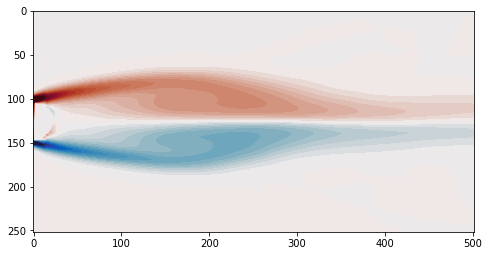

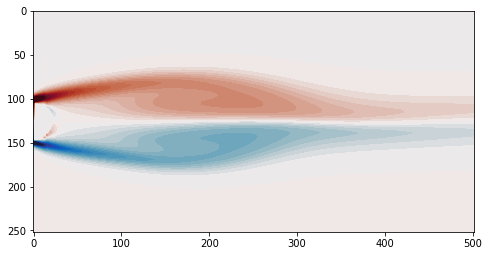

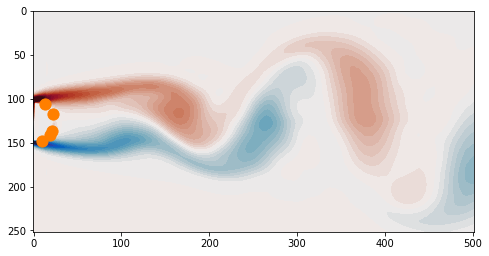

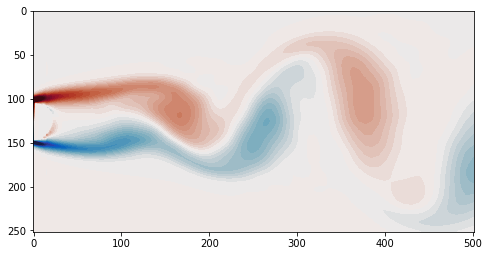

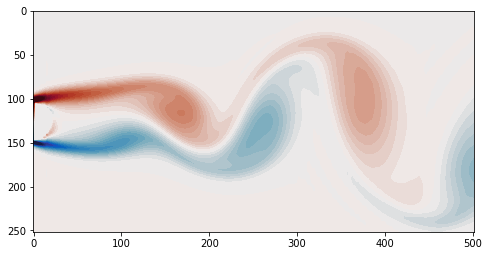

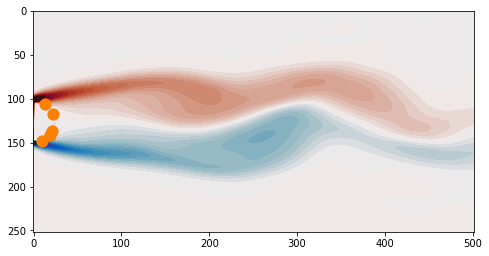

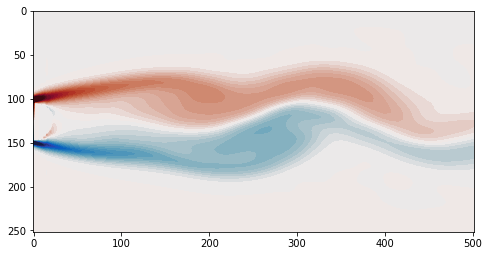

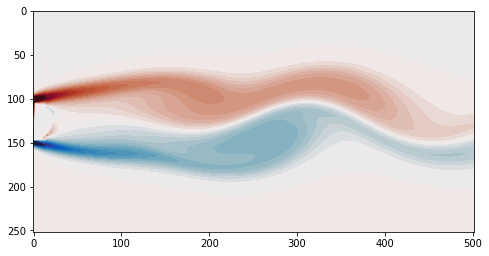

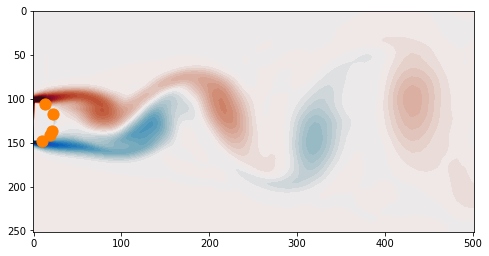

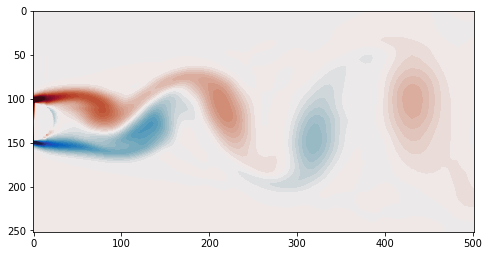

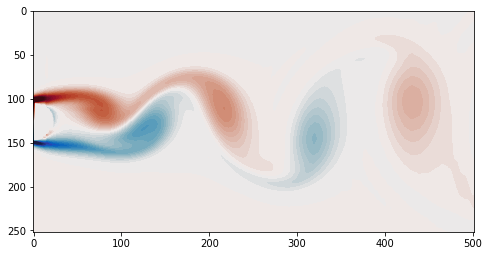

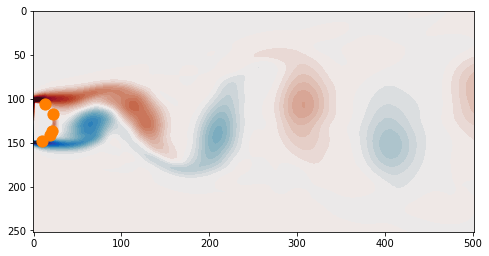

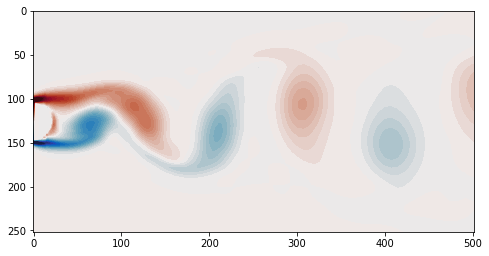

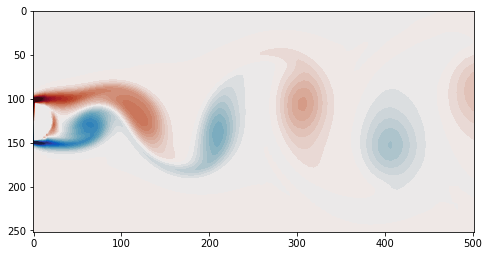

In [ ]:
for bn in [5,15,25,50]:
  print(bn)
  s =5
  seq_len = 11
  FR_rnn(s,seq_len, bn)
for bn in [5,15,25,50]:
  print(bn)
  s= 5
  FR_ADS(s, bn)
for bn in [5,15,25,50]:
  print(bn)
  s= 5
  FR_PDS(s, bn)